# Task 4: To process EMG signals and classify fatigue and non-fatigue muscle activity

This experiment presents muscle activity experiments and EMG recording. Each recorded file has EEG signals which have fatigue and non-fatigue segments. We need to do a binary classification of these segments.

In [182]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 1. Import Libraries and define basic functions and constants

Import Libraries

In [183]:
import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # new model 1
from xgboost import XGBClassifier # new model 2
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.signal import welch
from scipy.stats import entropy, skew, kurtosis
from sklearn.decomposition import PCA


from scipy.signal import butter, filtfilt, freqz, iirnotch
import pywt
from pywt import scale2frequency, cwt
from scipy.stats import entropy
from sklearn import svm
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch


In [184]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):

    cm = confusion_matrix(y_true, y_pred, labels=classes)

    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=True,
                xticklabels=classes, yticklabels=classes)

    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Find sampling rate of EMG signal

In [185]:
# finding sampling rate
file1 = pd.read_csv('/content/drive/MyDrive/Myelin-H/EMG-2/EMG/U1Ex3Rep1.csv', header = None)
file1

,0,1,2
0,1.8054,-0.000059,0
1,1.8059,-0.000070,0
2,1.8064,-0.000068,0
3,1.8069,-0.000059,0
4,1.8074,-0.000054,0
...,...,...,...
57126,31.4670,0.000052,1
57127,31.4670,0.000040,1
57128,31.4680,0.000020,1
57129,31.4680,0.000001,1


In [186]:
# given difference between each point is 0.0005 s (0.5 ms)
sampling_rate = int(1/0.0005)

print(f"Sampling rate of EMG signal = {sampling_rate}")

Sampling rate of EMG signal = 2000


## 2. Creating dataset from files

1. Each .csv file corresponds to a EMG recording
2. The EMG data is segmented into 0.5 seconds segments and stored into a new dataframe (emg_df) as new rows
3. For each row, the fatigue(1)/non-fatigue(0) target labels also added, based on the mode of the labels (highest occurence) of the label in each signal

In [187]:
emg = '/content/drive/MyDrive/Myelin-H/EMG-2/EMG'
csv_files = glob.glob(os.path.join(emg, "*.csv"))

emg_df = pd.DataFrame()

window = 0.5  # sliding 0.5 second window to segment EMG signal
num_samples = int(sampling_rate * window)

for file in csv_files:

    data = pd.read_csv(file, header=None, names=['time', 'emg', 'target'])  # read .csv file

    if not data.empty:
        num_windows = len(data) // num_samples
        num_windows = int(num_windows)

        #print(num_windows)

        for i in range(num_windows + 1):  # +1 is to ensure the last partial window is considered
            start_index = i * num_samples
            end_index = start_index + num_samples
            window_data = data.iloc[start_index:end_index]

            if not window_data.empty:

                emg_data = window_data['emg'].values.reshape(1, -1)  # EMG data extracted and reshaped
                target_value = window_data['target'].mode()[0] if not window_data['target'].mode().empty else window_data['target'].iloc[-1] # to get final label based on maximum occurrence of label within the window

                row_to_add = pd.DataFrame(emg_data)
                row_to_add['target'] = target_value

                emg_df = pd.concat([emg_df, row_to_add], ignore_index=True)

emg_df.reset_index(drop=True, inplace=True)

Include padding of dataframe by replacing 'nan' values with 0

In [188]:
emg_df.fillna(0, inplace=True)
emg_df

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,target
0,0.000038,0.000035,0.000030,0.000028,0.000029,0.000020,-0.000006,-0.000044,-0.000101,-0.000168,...,-0.000282,-0.000249,-0.000101,0.000053,0.000144,0.000185,0.000188,0.000157,0.000115,0
1,0.000086,0.000069,0.000055,0.000042,0.000041,0.000041,0.000034,0.000031,0.000028,0.000017,...,0.000142,0.000123,0.000091,0.000048,-0.000010,-0.000087,-0.000171,-0.000204,-0.000157,0
2,-0.000083,-0.000035,0.000010,0.000084,0.000145,0.000146,0.000110,0.000073,0.000047,0.000047,...,0.000115,0.000164,0.000204,0.000267,0.000315,0.000317,0.000282,0.000236,0.000194,0
3,0.000158,0.000122,0.000082,0.000044,0.000006,-0.000039,-0.000085,-0.000118,-0.000137,-0.000147,...,-0.000187,-0.000141,-0.000058,0.000036,0.000129,0.000219,0.000287,0.000310,0.000284,0
4,0.000231,0.000170,0.000104,0.000039,-0.000017,-0.000068,-0.000117,-0.000161,-0.000211,-0.000273,...,-0.000061,-0.000064,-0.000058,-0.000034,-0.000011,-0.000027,-0.000076,-0.000095,-0.000079,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744,0.000019,0.000014,0.000011,0.000010,0.000009,0.000009,0.000010,0.000012,0.000015,0.000017,...,-0.000002,-0.000005,-0.000009,-0.000014,-0.000012,-0.000004,0.000004,0.000009,0.000015,1
4745,0.000024,0.000037,0.000049,0.000055,0.000054,0.000054,0.000053,0.000049,0.000040,0.000032,...,0.000028,0.000028,0.000024,0.000016,0.000009,0.000007,0.000010,0.000016,0.000020,1
4746,0.000024,0.000027,0.000028,0.000025,0.000020,0.000019,0.000024,0.000030,0.000031,0.000029,...,0.000012,0.000012,0.000013,0.000015,0.000014,0.000012,0.000011,0.000012,0.000013,1
4747,0.000013,0.000014,0.000014,0.000013,0.000013,0.000013,0.000013,0.000013,0.000014,0.000016,...,0.000018,0.000018,0.000018,0.000019,0.000019,0.000018,0.000016,0.000014,0.000012,1


## 3. Signal Preprocessing

Preprocessing functions:

**1. Notch filter (to filter out 60 Hz powerline noise)**

**2. Wavelet transform denoising**

**3. Bandpass filtering (to extract relevant frequencies 5 - 500 Hz)**
3. Lowpass filter
4. Highpass filter
5. Baseline correction

In [189]:
# band-pass filter
def bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# low-pass filter
def low_pass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    y = filtfilt(b, a, data)
    return y

# high-pass filter
def high_pass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high')
    y = filtfilt(b, a, data)
    return y


# notch filter
def notch_filter(data, fs, f0, Q=30):
    w0 = f0 / (fs / 2)
    b, a = iirnotch(w0, Q)
    filtered_signal = filtfilt(b, a, data)
    return filtered_signal

# baseline correction
def apply_baseline_correction(data):
    corrected_data = data.copy()
    corrected_data = data - np.mean(data)
    return corrected_data


Wavelet Transform denoise function

In [190]:
def denoise_signal(signal, wavelet_name='db4', level=None, thresholding_strategy='soft', threshold_multiplier=1.0):

    coeff = pywt.wavedec(signal, wavelet_name, mode='per', level=level)
    sigma = np.median(np.abs(coeff[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal))) * threshold_multiplier
    coeff[1:] = [pywt.threshold(i, value=threshold, mode=thresholding_strategy) for i in coeff[1:]]

    # Reconstruct the signal
    y = pywt.waverec(coeff, wavelet_name, mode='per')
    return y

In [191]:
X_data = emg_df.iloc[:, :-1]
y_data = emg_df.iloc[:, -1]

### Preprocess signal data

In [192]:
def preprocessdata(df):
    fs = sampling_rate
    f0 = 60    # Frequency to notch out
    processed_rows = []

    for i in range(len(df)):
        row = df.iloc[i].copy()

        #row = apply_baseline_correction(row) # Apply baseline correction

        #row = high_pass_filter(row, 80, fs)

        row = notch_filter(row, fs, f0, Q=30) # Apply notch filtering

        row = denoise_signal(row, wavelet_name='sym5', level=5, thresholding_strategy='soft', threshold_multiplier=2)  # to denoise using wavelet transform

        row = bandpass_filter(row, 20, 500, fs) # Apply bandpass filtering to capture relevant frequencies

        #row_df = pd.DataFrame([row])
        #row_df['target'] = df.iloc[i, -1]
        row = row[250:]
        processed_rows.append(row)


    new_df = pd.DataFrame(processed_rows)

    return new_df

processed_X_data = preprocessdata(X_data)
processed_X_data

,0,1,2,3,4,5,6,7,8,9,...,740,741,742,743,744,745,746,747,748,749
0,2.761010e-05,3.735092e-05,4.437957e-05,4.513237e-05,3.475264e-05,1.040702e-05,-2.351783e-05,-5.716109e-05,-8.538003e-05,-1.092217e-04,...,-2.131844e-04,-2.487595e-04,-2.113839e-04,-1.138282e-04,-4.664777e-06,5.963634e-05,6.577299e-05,4.605433e-05,2.337733e-05,-2.243852e-06
1,-4.388284e-05,-2.536674e-05,1.030373e-05,4.552265e-05,6.743438e-05,7.409611e-05,7.037123e-05,6.357123e-05,5.871397e-05,5.623875e-05,...,1.075899e-04,1.049138e-04,9.970541e-05,9.151413e-05,7.716526e-05,5.208742e-05,1.738183e-05,-1.354474e-05,-1.857093e-05,6.955141e-06
2,1.469858e-04,1.415789e-04,1.183946e-04,9.040697e-05,6.970477e-05,5.958617e-05,5.479928e-05,4.410444e-05,1.586311e-05,-3.525369e-05,...,-1.052068e-04,-5.509866e-05,7.962581e-06,6.496685e-05,9.817499e-05,1.004347e-04,8.459593e-05,6.823246e-05,4.152436e-05,-9.563387e-06
3,1.149708e-04,1.553199e-04,1.813241e-04,1.996009e-04,2.098722e-04,2.054624e-04,1.870388e-04,1.657370e-04,1.543268e-04,1.596418e-04,...,-3.079235e-04,-2.885168e-04,-2.500623e-04,-2.064270e-04,-1.607406e-04,-1.055216e-04,-4.472406e-05,-1.031490e-06,2.950578e-06,-2.910848e-05
4,-8.956498e-05,-8.542181e-05,-7.524836e-05,-6.504519e-05,-6.473470e-05,-8.204596e-05,-1.113438e-04,-1.341065e-04,-1.327273e-04,-1.006720e-04,...,-3.915393e-05,-2.912967e-05,-1.511862e-05,-3.562417e-06,9.120616e-07,-3.925955e-06,-2.082274e-05,-4.328038e-05,-4.506832e-05,-1.338834e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744,-1.646807e-05,-1.112413e-05,-3.972558e-06,2.740845e-06,7.278378e-06,9.266510e-06,9.434839e-06,8.962479e-06,8.306289e-06,7.077521e-06,...,1.467074e-06,-1.149329e-06,-6.797424e-06,-1.216825e-05,-1.450333e-05,-1.305312e-05,-9.101837e-06,-5.121698e-06,-2.669641e-06,-1.449236e-06
4745,4.584452e-06,9.102117e-06,1.215774e-05,1.355024e-05,1.256357e-05,8.287016e-06,1.063812e-06,-6.558912e-06,-9.141216e-06,-1.328078e-06,...,2.033051e-05,1.740532e-05,1.329702e-05,8.835984e-06,4.564184e-06,6.740791e-07,-2.368710e-06,-3.361446e-06,-8.919488e-07,4.684511e-06
4746,1.347283e-06,1.459259e-06,1.565063e-06,1.714957e-06,1.983294e-06,2.410866e-06,2.904542e-06,3.289101e-06,3.548977e-06,3.813378e-06,...,-4.225368e-06,-4.326965e-06,-4.644702e-06,-4.879799e-06,-4.979257e-06,-5.143383e-06,-5.376525e-06,-5.241006e-06,-4.128425e-06,-2.033229e-06
4747,1.623322e-06,1.297238e-06,9.193227e-07,4.559007e-07,-1.432365e-07,-9.033733e-07,-1.756426e-06,-2.573400e-06,-3.322199e-06,-4.066238e-06,...,-9.197438e-07,-9.899411e-07,-1.107784e-06,-1.217705e-06,-1.275554e-06,-1.271668e-06,-1.218298e-06,-1.132523e-06,-1.019135e-06,-8.811000e-07


Show visual comparison of before and after signal processing

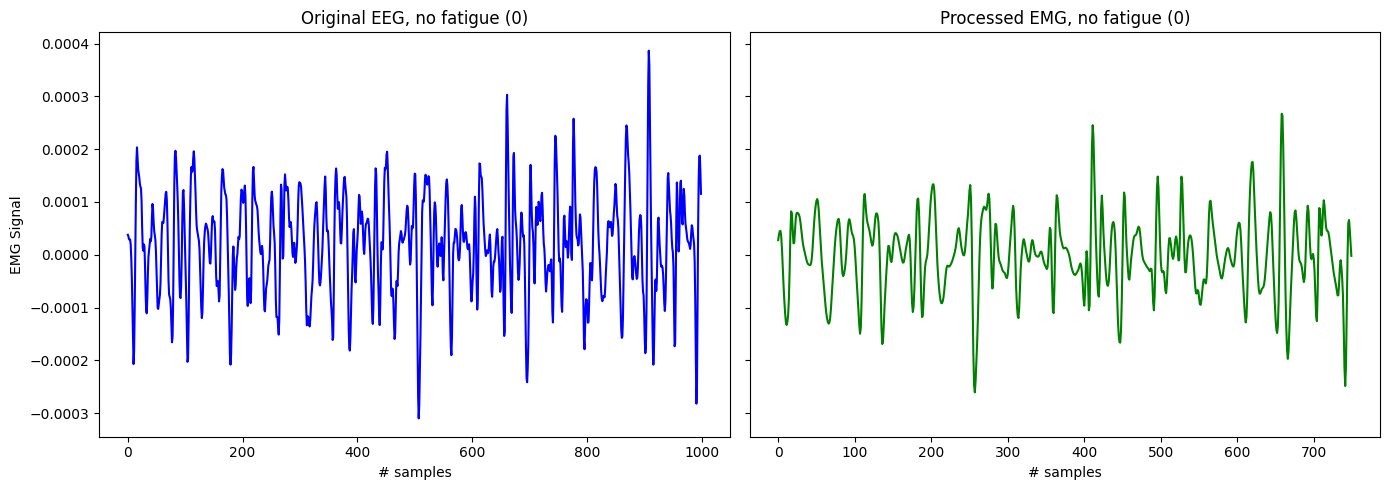

In [193]:
# showing comparison - NO FATIGUE
first_df = X_data.iloc[0, :]
first_processed_df = processed_X_data.iloc[0, :]

fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey = True)

# original
axs[0].plot(first_df, color='blue')
axs[0].set_title('Original EEG, no fatigue (0)')
axs[0].set_xlabel('# samples')
axs[0].set_ylabel('EMG Signal')

# processed
axs[1].plot(first_processed_df, color='green')
axs[1].set_title('Processed EMG, no fatigue (0)')
axs[1].set_xlabel('# samples')

plt.tight_layout()
plt.show()

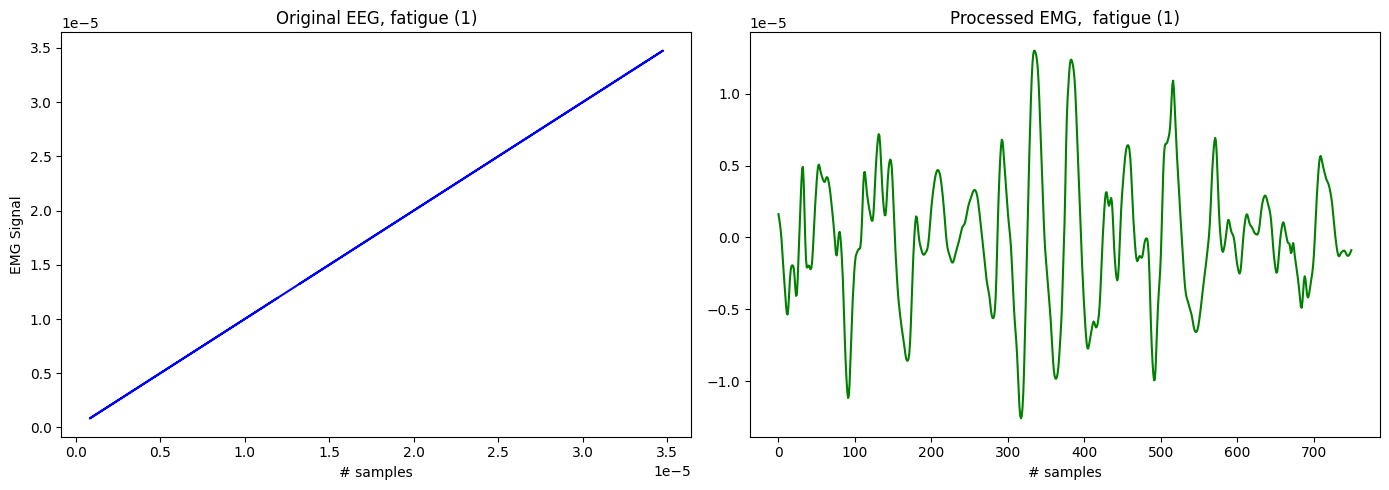

In [196]:
# showing comparison - FATIGUE
first_df = X_data.iloc[4747, :]
first_processed_df = processed_X_data.iloc[4747, :]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(first_df, first_df, color='blue')
axs[0].set_title('Original EEG, fatigue (1)')
axs[0].set_xlabel('# samples')
axs[0].set_ylabel('EMG Signal')

axs[1].plot(first_processed_df, color='green')
axs[1].set_title('Processed EMG,  fatigue (1)')
axs[1].set_xlabel('# samples')

plt.tight_layout()
plt.show()

## 4. Feature Extraction

Defining Feature functions

In [197]:
# creating features

# linear envelope
fs = sampling_rate

def extract_linear_envelope(data, fs):
    linear_envelope = low_pass_filter(data, cutoff=5, fs=fs)
    return linear_envelope

# Root Mean Square
def calculate_rms(data, window_size=60):
    rms = np.sqrt(np.convolve(data**2, np.ones(window_size)/window_size, mode='valid'))
    return rms

# Continous Wavelet transform
def cwt_wavelet_decompose(data, freq, waveletname):

    scales = np.arange(1, int(freq/10) + 1, 1)
    coefficients, frequencies = pywt.cwt(data, scales, waveletname, 1.0 / freq)

    decom_wavelets = pd.DataFrame(coefficients, index=np.round(frequencies, 2))

    return decom_wavelets

# Fast Fourier Transform
def fft_emg_features(signal):

    n = len(signal)
    freqs = np.fft.rfftfreq(n, d=1/fs)
    fft_values = np.abs(np.fft.rfft(signal))

    # Spectral power
    power = np.square(fft_values)

    # Mean frequency
    mean_frequency = np.sum(power * freqs) / np.sum(power)

    # Median frequency
    cumulative_power = np.cumsum(power)
    total_power = cumulative_power[-1]
    median_frequency = freqs[np.where(cumulative_power >= total_power / 2)[0][0]]

    peak_frequency = freqs[np.argmax(power)]

    total_spectral_power = np.sum(power)

    features = [mean_frequency, median_frequency, peak_frequency, total_spectral_power] # return all stats

    FFT_statistics = np.array(features).T

    return FFT_statistics

# Entropy
def shannon_entropy(data):

    hist, _ = np.histogram(data, bins=10, density=True)
    hist = hist[hist > 0]
    return entropy(hist, base=2)


def dwt_emg_features(signal, wavelet='db4'):

    coeffs = pywt.wavedec(signal, wavelet, mode='per')

    concatenated_coeffs = np.concatenate(coeffs)

    mean_absolute_power = np.mean(np.abs(concatenated_coeffs))
    mean_average_value = np.mean(concatenated_coeffs)
    std_deviation = np.std(concatenated_coeffs)
    variance = np.var(concatenated_coeffs)

    features = [mean_absolute_power, mean_average_value, std_deviation, variance]  # return all stats
    dwt_statistics = np.array(features).T

    return dwt_statistics


In [205]:
def power_spectral_density(data, fs):
    f, Pxx = welch(data, fs, nperseg=1024)
    return np.mean(Pxx), np.median(Pxx), np.sum(Pxx)


def time_domain_features(data):
    MAV = np.mean(np.abs(data))
    ZC = np.sum(np.diff(np.sign(data)) != 0)
    SSC = np.sum(np.diff(np.sign(np.diff(data))) != 0)
    WL = np.sum(np.abs(np.diff(data)))
    return [MAV, ZC, SSC, WL]

def statistical_features(data):
    mean = np.mean(data)
    std = np.std(data)
    skewness = skew(data)
    kurt = kurtosis(data)
    return [mean, std, skewness, kurt]


### Feature Data 1: Linear Envelope + RMS

In [198]:
def feature1_env_rms(processed_data):

  processed_data2 = extract_linear_envelope(processed_data, fs)
  features1_data  = calculate_rms(processed_data2, window_size=60)

  return features1_data

### Feature Data 2: Continous Wavelet Transform (CWT)

In [201]:
def feature2_CWT(processed_data):

  processed_data2 = cwt_wavelet_decompose(processed_data, fs, 'morl')
  features2_data = processed_data2[0]


  return features2_data

### Feature Data 3: Fast Fourier Transform + Statistics

In [202]:
def feature3_FFTstat(processed_data):

  features3_data = fft_emg_features(processed_data)    # returns FFT stats - mean_frequency, median_frequency, peak_frequency, total_spectral_power

  return features3_data

### Feature Data 4: DWT + Statistics

In [203]:
def feature4_DWTstat(processed_data):

  features4_data = dwt_emg_features(processed_data)  # return DWT stats - mean_absolute_power, mean_average_value, std_deviation, variance

  return features4_data

### Feature Data 5: FFT + Entropy

In [204]:
def feature5_FFT_entropy(processed_data):

  processed_data2 = fft_emg_features(processed_data)
  processed_data3 = shannon_entropy(processed_data)

  features5_data = np.append(processed_data2, processed_data3)   # returns FFT stats AND entropy

  return features5_data

### Features Data 6: All combined

In [206]:
def combine_features(row, fs):
    features_env_rms = feature1_env_rms(row)
    features_CWT = feature2_CWT(row)
    #features_FFTstat = feature3_FFTstat(row)
    feature_DWTstat = feature4_DWTstat(row)
    features_FFT_entropy = feature5_FFT_entropy(row)
    time_features = time_domain_features(row)
    psd_features = power_spectral_density(row, fs)
    stat_features = statistical_features(row)

    combined_features = np.hstack((features_env_rms, features_CWT, feature_DWTstat, features_FFT_entropy, time_features, psd_features, stat_features))
    return combined_features


### Creating X_data processed based on feature data 1, 2, 3, 4, 5 or 6

In [168]:
feature_dataset_list_env_rms = []
feature_dataset_list_cwt = []
feature_dataset_list_FFTstat = []
feature_dataset_list_DWTstat = []
feature_dataset_list_FFT_entropy = []
feature_data_list_combine_features = []


for i in range(len(X_data)):

    row = X_data.iloc[i]

    feature_dataset_list_env_rms.append(pd.DataFrame([feature1_env_rms(row)]))
    feature_dataset_list_cwt.append(pd.DataFrame([feature2_CWT(row)]))
    feature_dataset_list_FFTstat.append(pd.DataFrame([feature3_FFTstat(row)]))
    feature_dataset_list_DWTstat.append(pd.DataFrame([feature4_DWTstat(row)]))
    feature_dataset_list_FFT_entropy.append(pd.DataFrame([feature5_FFT_entropy(row)]))
    feature_data_list_combine_features.append(pd.DataFrame([combine_features(row, fs)]))


#Concatenate all data frames in the list into a single DataFrame
feature_dataset_list_env_rms = pd.concat(feature_dataset_list_env_rms, ignore_index=True)
feature_dataset_list_cwt = pd.concat(feature_dataset_list_cwt, ignore_index=True)
feature_dataset_list_FFTstat = pd.concat(feature_dataset_list_FFTstat, ignore_index=True)
feature_dataset_list_DWTstat = pd.concat(feature_dataset_list_DWTstat, ignore_index=True)
feature_dataset_list_FFT_entropy = pd.concat(feature_dataset_list_FFT_entropy, ignore_index=True)
feature_data_list_combine_features = pd.concat(feature_data_list_combine_features, ignore_index=True)


/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 1000, using nperseg = 1000
  warnings.warn('nperseg = {0:d} is greater than input length '


In [169]:
feature_data_list_combine_features

,0,1,2,3,4,5,6,7,8,9,...,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160
0,0.000091,0.000090,0.000089,0.000088,0.000087,0.000086,0.000085,0.000084,0.000083,0.000082,...,113.0,218.0,0.029152,8.229287e-12,5.997556e-14,4.122873e-09,2.017843e-05,0.000095,-0.160423,0.373945
1,0.000065,0.000064,0.000064,0.000063,0.000063,0.000062,0.000061,0.000061,0.000060,0.000059,...,123.0,190.0,0.042696,1.934585e-11,1.737965e-13,9.692269e-09,2.043746e-05,0.000138,-0.338577,1.431599
2,0.000066,0.000065,0.000064,0.000063,0.000062,0.000060,0.000059,0.000058,0.000057,0.000056,...,128.0,190.0,0.039535,1.747483e-11,1.438863e-13,8.754892e-09,2.086692e-05,0.000132,-0.008674,0.487231
3,0.000165,0.000163,0.000161,0.000158,0.000156,0.000154,0.000152,0.000150,0.000148,0.000146,...,96.0,203.0,0.042149,2.166243e-11,8.678861e-14,1.085288e-08,2.058991e-05,0.000147,-0.125549,0.303927
4,0.000255,0.000251,0.000248,0.000245,0.000241,0.000238,0.000235,0.000231,0.000228,0.000225,...,107.0,200.0,0.037976,1.719417e-11,8.224679e-14,8.614280e-09,1.732743e-05,0.000136,-0.269279,0.391615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,...,69.0,191.0,0.006425,9.852190e-13,3.213890e-15,4.935947e-10,1.884846e-05,0.000028,-0.224758,2.111099
4745,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,...,48.0,199.0,0.005722,3.711563e-13,1.129770e-15,1.859493e-10,1.953194e-05,0.000026,-0.209042,2.785715
4746,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,...,8.0,300.0,0.002009,8.531091e-14,5.610402e-16,4.274077e-11,1.949047e-05,0.000014,-1.013026,8.270678
4747,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,...,0.0,323.0,0.001170,5.606524e-14,4.264781e-16,2.808869e-11,1.930585e-05,0.000007,-0.170902,-0.453362


# 5. Feature Selection - for combined feature dataset

Reducing dimensionality of the combined feature dataset (because it has the highest no. of 1161 columns)

## PCA

In [170]:
from sklearn.decomposition import PCA

def apply_pca(features, n_components=5):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(features)
    return principal_components


In [136]:
scaler = StandardScaler()
feature_data_list_combined_scaled = scaler.fit_transform(feature_data_list_combine_features)

In [172]:
n_components = 10  # taking 10 components
principal_components = apply_pca(feature_data_list_combine_features, n_components=n_components)
principal_df = pd.DataFrame(principal_components)
principal_df

,0,1,2,3,4,5,6,7,8,9
0,-15.713299,-58.379412,-43.850775,10.914752,4.299930,-4.358757,-0.302128,0.068786,0.005881,-0.001643
1,-41.727708,-51.512665,-50.648303,-2.883508,10.232802,-5.877674,-0.030174,-0.076774,0.010697,-0.011565
2,-50.394417,-60.913019,-11.411077,-9.898062,-2.829105,2.117942,0.117831,0.055518,0.003531,-0.006812
3,-29.524131,-46.463637,-23.222164,16.462567,10.725430,-9.575512,-0.657685,0.128492,0.009695,-0.007155
4,-26.425409,-42.734753,-24.330966,2.688613,4.816684,-4.360565,-0.108878,0.212443,0.007107,-0.007433
...,...,...,...,...,...,...,...,...,...,...
4744,20.062622,32.645212,-0.028757,-10.245981,0.785897,0.215012,0.304099,-0.169599,-0.004638,0.000271
4745,40.335419,48.715335,13.847638,-6.840569,10.954033,-6.073772,-0.229205,-0.215399,-0.004886,0.000878
4746,130.942932,20.634342,37.081627,46.684787,4.612599,0.373196,0.459563,-0.375045,0.001929,-0.004686
4747,152.969066,15.681053,43.000782,57.176158,-6.126722,-3.852070,-0.994909,0.629268,0.004225,0.001417


# 6. Machine Learning & Deep Learning Classification

Classifying labels "1" (fatigue), "0" (no fatigue)

## Splitting dataset into train and test

In [55]:
# feature_dataset_list_env_rms = pd.concat(feature_dataset_list_env_rms, ignore_index=True)
# feature_dataset_list_cwt = pd.concat(feature_dataset_list_cwt, ignore_index=True)
# feature_dataset_list_FFTstat = pd.concat(feature_dataset_list_FFTstat, ignore_index=True)
# feature_dataset_list_DWTstat = pd.concat(feature_dataset_list_DWTstat, ignore_index=True)
# feature_dataset_list_FFT_entropy = pd.concat(feature_dataset_list_FFT_entropy, ignore_index=True)
# feature_data_list_combine_features = pd.concat(feature_data_list_combine_features, ignore_index=True)
# principal_df

In [173]:
# Splitting dataset into training and test sets
X = principal_df.values         # change feature dataset here
y = y_data.values

# Split into training and test sets (90% training, 10% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print("Training-Val set size:", X_train_val.shape, y_train_val.shape)
print("Test set size:", X_test.shape, y_test.shape)

#Standardize the data
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

Training-Val set size: (4274, 10) (4274,)
Test set size: (475, 10) (475,)


## 6a. Support Vector Machine (SVM)

(475,)
(475,)
Test Accuracy: 0.6105263157894737


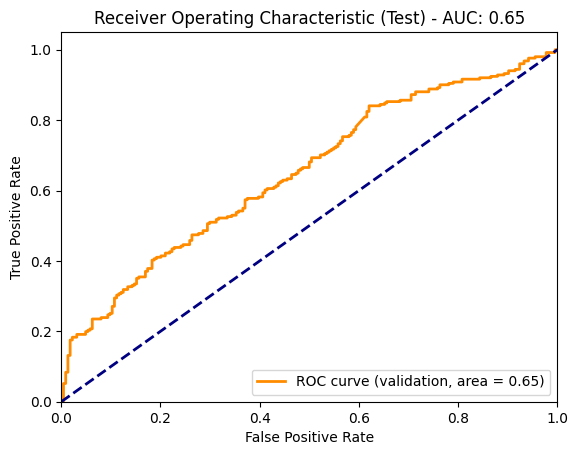

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.67      0.35      0.46       224
           1       0.59      0.84      0.70       251

    accuracy                           0.61       475
   macro avg       0.63      0.60      0.58       475
weighted avg       0.63      0.61      0.58       475



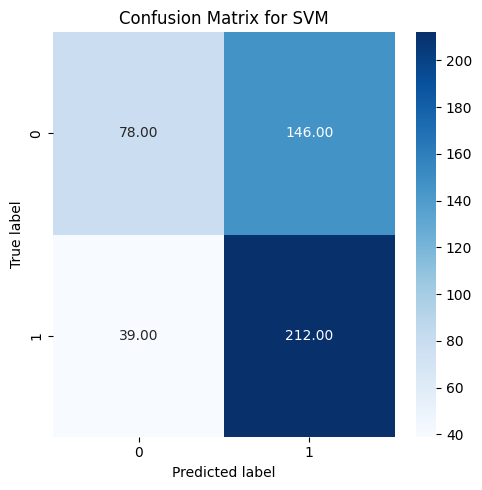

In [157]:
#SVM
LSVM = svm.SVC(kernel='linear', probability=True)
LSVM.fit(X_train_val, y_train_val)
y_test_pred = LSVM.predict(X_test)
print(y_test_pred.shape)
print(y_test.shape)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
y_test_prob = LSVM.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()

plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (validation, area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
classes = [0, 1]
plot_confusion_matrix(y_test, y_test_pred, classes, title='Confusion Matrix for SVM')

# cm_test = confusion_matrix(y_test, y_test_pred)
# print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))


### Hyper-parameter tuning SVM model

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Hyperparameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Test Accuracy: 0.6631578947368421


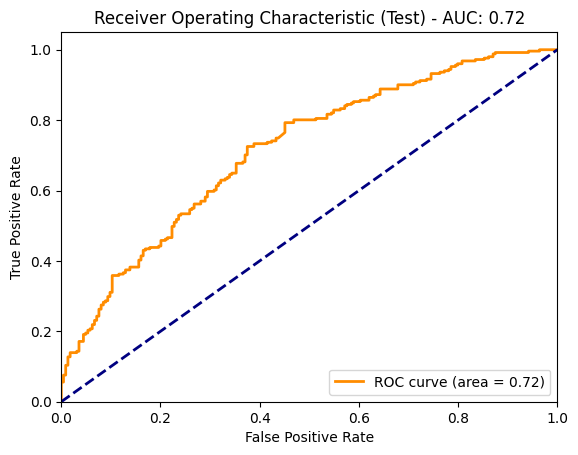

Confusion Matrix (Test):
 [[126  98]
 [ 62 189]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.67      0.56      0.61       224
           1       0.66      0.75      0.70       251

    accuracy                           0.66       475
   macro avg       0.66      0.66      0.66       475
weighted avg       0.66      0.66      0.66       475



In [181]:
from sklearn.svm import SVC
# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1],  # Regularization strength
    'kernel': ['linear', 'rbf'],  # Linear and RBF kernels
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf'
}

svm_model = SVC(probability=True, random_state=42)

# GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_val, y_train_val)

print("Best Hyperparameters:", grid_search.best_params_)

# Train the model with the best hyperparameters on the entire training+validation set
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
y_test_prob = best_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))

## 6b. Deep Learning

In [175]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [176]:
def create_model(input_dim, layers, dropout_rate):
    class DynamicMLP(nn.Module):
        def __init__(self, input_dim, layers, dropout_rate):
            super(DynamicMLP, self).__init__()
            self.layers = nn.ModuleList()
            prev_dim = input_dim
            for layer_size in layers:
                self.layers.append(nn.Linear(prev_dim, layer_size))
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(dropout_rate))
                prev_dim = layer_size
            self.layers.append(nn.Linear(prev_dim, 1))
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            for layer in self.layers:
                x = layer(x)
            x = self.sigmoid(x)
            return x

    return DynamicMLP(input_dim, layers, dropout_rate)


input_size = X_train_val.shape[1]
layers = [2000, 1024, 1024, 1024, 1024, 512, 512, 512, 512]
dropout_rate = 0.15

model = create_model(input_size, layers, dropout_rate)

# Print model's architecture
print(model)

DynamicMLP(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=2000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=2000, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.15, inplace=False)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.15, inplace=False)
    (9): Linear(in_features=1024, out_features=1024, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.15, inplace=False)
    (12): Linear(in_features=1024, out_features=1024, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.15, inplace=False)
    (15): Linear(in_features=1024, out_features=512, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.15, inplace=False)
    (18): Linear(in_features=512, out_features=512, bias=True)
    (19): ReLU()
    (20): Dropout(p=0.15, inplace=False)
    (21): Linear(in_features=512, out_features=512, bias=True)
    (22): ReLU()
    (23): Dropout(p=0.15, inplace=Fals

In [179]:
# parameters
epochs = 50
learning_rate = 0.0001
batch = 32
# layers = (512, 256, 128)
#dropout_rate = 0.1

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience= epochs // 10, verbose=True)

train_loader = DataLoader(train_dataset, batch_size= batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= batch, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size= batch, shuffle=False)

best_val_loss = float('inf')
early_stopping_patience = epochs // 5
early_stopping_counter = 0
num_epochs = epochs

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)

            preds = (outputs > 0.5).float()
            correct_predictions += (preds == y_batch).sum().item()
            total_predictions += y_batch.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_accuracy = correct_predictions / total_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

    scheduler.step(epoch_val_loss)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping")
            break

model.load_state_dict(torch.load('best_model.pth'))



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.5584, Val Loss: 0.6033, Val Accuracy: 0.6690
Epoch 2/50, Train Loss: 0.5529, Val Loss: 0.6217, Val Accuracy: 0.6667
Epoch 3/50, Train Loss: 0.5468, Val Loss: 0.5959, Val Accuracy: 0.6702
Epoch 4/50, Train Loss: 0.5449, Val Loss: 0.5922, Val Accuracy: 0.6596
Epoch 5/50, Train Loss: 0.5386, Val Loss: 0.5868, Val Accuracy: 0.6807
Epoch 6/50, Train Loss: 0.5340, Val Loss: 0.6490, Val Accuracy: 0.6725
Epoch 7/50, Train Loss: 0.5290, Val Loss: 0.6073, Val Accuracy: 0.6550
Epoch 8/50, Train Loss: 0.5254, Val Loss: 0.6133, Val Accuracy: 0.6678
Epoch 9/50, Train Loss: 0.5134, Val Loss: 0.5954, Val Accuracy: 0.6515
Epoch 10/50, Train Loss: 0.5152, Val Loss: 0.6014, Val Accuracy: 0.6632
Epoch 11/50, Train Loss: 0.5040, Val Loss: 0.6291, Val Accuracy: 0.6655
Epoch 12/50, Train Loss: 0.4824, Val Loss: 0.5991, Val Accuracy: 0.6784
Epoch 13/50, Train Loss: 0.4673, Val Loss: 0.6053, Val Accuracy: 0.6772
Epoch 14/50, Train Loss: 0.4647, Val Loss: 0.6110, Val Accuracy: 0.6749
E

<All keys matched successfully>

Test Accuracy: 0.6842105263157895


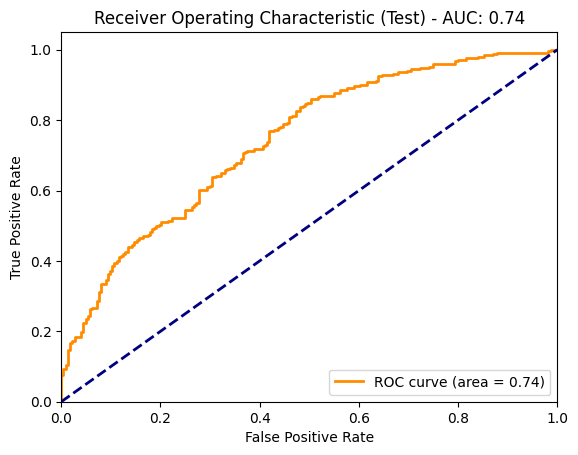

Confusion Matrix (Test):
 [[114 110]
 [ 40 211]]
Classification Report (Test):
               precision    recall  f1-score   support

         0.0       0.74      0.51      0.60       224
         1.0       0.66      0.84      0.74       251

    accuracy                           0.68       475
   macro avg       0.70      0.67      0.67       475
weighted avg       0.70      0.68      0.67       475



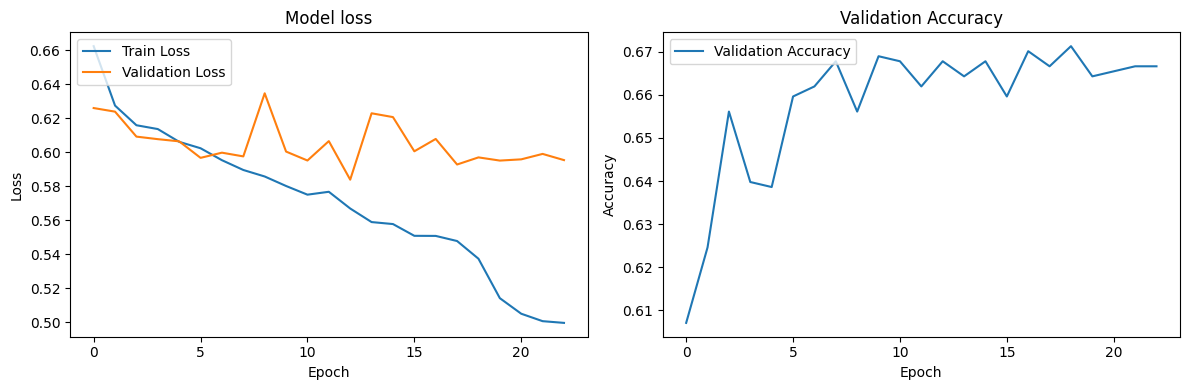

In [178]:
# For evaluation
model.eval()

y_test_pred_prob = []
y_test_true = []
test_loader = DataLoader(test_dataset, batch_size= batch, shuffle=False)  # Ensure test_loader here as well
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        y_test_pred_prob.append(outputs.numpy())
        y_test_true.append(y_batch.numpy())
y_test_pred_prob = np.vstack(y_test_pred_prob).ravel()
y_test_true = np.vstack(y_test_true).ravel()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

test_accuracy = accuracy_score(y_test_true, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test_true, y_test_pred)
print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test_true, y_test_pred))

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Hyperparameter tuning Deep learning model

Epoch 1/50, Train Loss: 0.6332, Val Loss: 0.6375, Val Accuracy: 0.6187
Epoch 2/50, Train Loss: 0.6168, Val Loss: 0.6076, Val Accuracy: 0.6456
Epoch 3/50, Train Loss: 0.6070, Val Loss: 0.6069, Val Accuracy: 0.6608
Epoch 4/50, Train Loss: 0.6040, Val Loss: 0.6062, Val Accuracy: 0.6655
Epoch 5/50, Train Loss: 0.5926, Val Loss: 0.6295, Val Accuracy: 0.6585
Epoch 6/50, Train Loss: 0.5871, Val Loss: 0.6137, Val Accuracy: 0.6503
Epoch 7/50, Train Loss: 0.5806, Val Loss: 0.5957, Val Accuracy: 0.6573
Epoch 8/50, Train Loss: 0.5786, Val Loss: 0.6017, Val Accuracy: 0.6667
Epoch 9/50, Train Loss: 0.5685, Val Loss: 0.6034, Val Accuracy: 0.6620
Epoch 10/50, Train Loss: 0.5629, Val Loss: 0.5951, Val Accuracy: 0.6620
Epoch 11/50, Train Loss: 0.5544, Val Loss: 0.6066, Val Accuracy: 0.6444
Epoch 12/50, Train Loss: 0.5534, Val Loss: 0.6047, Val Accuracy: 0.6667
Epoch 13/50, Train Loss: 0.5455, Val Loss: 0.6128, Val Accuracy: 0.6632
Epoch 14/50, Train Loss: 0.5416, Val Loss: 0.6368, Val Accuracy: 0.6772
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6439, Val Loss: 0.6248, Val Accuracy: 0.6199
Epoch 2/50, Train Loss: 0.6176, Val Loss: 0.6145, Val Accuracy: 0.6374
Epoch 3/50, Train Loss: 0.6142, Val Loss: 0.6043, Val Accuracy: 0.6515
Epoch 4/50, Train Loss: 0.6047, Val Loss: 0.6058, Val Accuracy: 0.6608
Epoch 5/50, Train Loss: 0.5972, Val Loss: 0.6018, Val Accuracy: 0.6643
Epoch 6/50, Train Loss: 0.5874, Val Loss: 0.5999, Val Accuracy: 0.6456
Epoch 7/50, Train Loss: 0.5817, Val Loss: 0.5967, Val Accuracy: 0.6573
Epoch 8/50, Train Loss: 0.5832, Val Loss: 0.5923, Val Accuracy: 0.6667
Epoch 9/50, Train Loss: 0.5771, Val Loss: 0.6022, Val Accuracy: 0.6725
Epoch 10/50, Train Loss: 0.5762, Val Loss: 0.5892, Val Accuracy: 0.6573
Epoch 11/50, Train Loss: 0.5694, Val Loss: 0.5986, Val Accuracy: 0.6655
Epoch 12/50, Train Loss: 0.5691, Val Loss: 0.6133, Val Accuracy: 0.6632
Epoch 13/50, Train Loss: 0.5622, Val Loss: 0.5938, Val Accuracy: 0.6667
Epoch 14/50, Train Loss: 0.5531, Val Loss: 0.6001, Val Accuracy: 0.6538
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6439, Val Loss: 0.6244, Val Accuracy: 0.6327
Epoch 2/50, Train Loss: 0.6204, Val Loss: 0.6154, Val Accuracy: 0.6398
Epoch 3/50, Train Loss: 0.6103, Val Loss: 0.6117, Val Accuracy: 0.6433
Epoch 4/50, Train Loss: 0.6025, Val Loss: 0.6060, Val Accuracy: 0.6573
Epoch 5/50, Train Loss: 0.5969, Val Loss: 0.5939, Val Accuracy: 0.6643
Epoch 6/50, Train Loss: 0.5938, Val Loss: 0.5909, Val Accuracy: 0.6608
Epoch 7/50, Train Loss: 0.5879, Val Loss: 0.6003, Val Accuracy: 0.6526
Epoch 8/50, Train Loss: 0.5855, Val Loss: 0.5894, Val Accuracy: 0.6667
Epoch 9/50, Train Loss: 0.5825, Val Loss: 0.5859, Val Accuracy: 0.6690
Epoch 10/50, Train Loss: 0.5716, Val Loss: 0.5865, Val Accuracy: 0.6538
Epoch 11/50, Train Loss: 0.5717, Val Loss: 0.5911, Val Accuracy: 0.6760
Epoch 12/50, Train Loss: 0.5649, Val Loss: 0.5968, Val Accuracy: 0.6585
Epoch 13/50, Train Loss: 0.5666, Val Loss: 0.5839, Val Accuracy: 0.6632
Epoch 14/50, Train Loss: 0.5602, Val Loss: 0.5788, Val Accuracy: 0.6725
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6474, Val Loss: 0.6345, Val Accuracy: 0.6117
Epoch 2/50, Train Loss: 0.6220, Val Loss: 0.6157, Val Accuracy: 0.6222
Epoch 3/50, Train Loss: 0.6162, Val Loss: 0.6142, Val Accuracy: 0.6351
Epoch 4/50, Train Loss: 0.6074, Val Loss: 0.6060, Val Accuracy: 0.6351
Epoch 5/50, Train Loss: 0.6032, Val Loss: 0.6003, Val Accuracy: 0.6433
Epoch 6/50, Train Loss: 0.6007, Val Loss: 0.5983, Val Accuracy: 0.6444
Epoch 7/50, Train Loss: 0.5917, Val Loss: 0.5990, Val Accuracy: 0.6550
Epoch 8/50, Train Loss: 0.5910, Val Loss: 0.6068, Val Accuracy: 0.6503
Epoch 9/50, Train Loss: 0.5889, Val Loss: 0.6032, Val Accuracy: 0.6561
Epoch 10/50, Train Loss: 0.5785, Val Loss: 0.6088, Val Accuracy: 0.6596
Epoch 11/50, Train Loss: 0.5819, Val Loss: 0.5961, Val Accuracy: 0.6632
Epoch 12/50, Train Loss: 0.5786, Val Loss: 0.5937, Val Accuracy: 0.6749
Epoch 13/50, Train Loss: 0.5731, Val Loss: 0.5918, Val Accuracy: 0.6643
Epoch 14/50, Train Loss: 0.5683, Val Loss: 0.5902, Val Accuracy: 0.6678
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6397, Val Loss: 0.6241, Val Accuracy: 0.6246
Epoch 2/50, Train Loss: 0.6157, Val Loss: 0.6202, Val Accuracy: 0.6351
Epoch 3/50, Train Loss: 0.6049, Val Loss: 0.6017, Val Accuracy: 0.6526
Epoch 4/50, Train Loss: 0.5976, Val Loss: 0.5944, Val Accuracy: 0.6585
Epoch 5/50, Train Loss: 0.5899, Val Loss: 0.5967, Val Accuracy: 0.6550
Epoch 6/50, Train Loss: 0.5826, Val Loss: 0.5968, Val Accuracy: 0.6667
Epoch 7/50, Train Loss: 0.5808, Val Loss: 0.5911, Val Accuracy: 0.6749
Epoch 8/50, Train Loss: 0.5752, Val Loss: 0.5939, Val Accuracy: 0.6468
Epoch 9/50, Train Loss: 0.5698, Val Loss: 0.5856, Val Accuracy: 0.6702
Epoch 10/50, Train Loss: 0.5618, Val Loss: 0.5974, Val Accuracy: 0.6515
Epoch 11/50, Train Loss: 0.5594, Val Loss: 0.5968, Val Accuracy: 0.6573
Epoch 12/50, Train Loss: 0.5559, Val Loss: 0.5850, Val Accuracy: 0.6561
Epoch 13/50, Train Loss: 0.5522, Val Loss: 0.5839, Val Accuracy: 0.6690
Epoch 14/50, Train Loss: 0.5557, Val Loss: 0.5862, Val Accuracy: 0.6655
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6407, Val Loss: 0.6260, Val Accuracy: 0.6140
Epoch 2/50, Train Loss: 0.6245, Val Loss: 0.6154, Val Accuracy: 0.6386
Epoch 3/50, Train Loss: 0.6146, Val Loss: 0.6107, Val Accuracy: 0.6433
Epoch 4/50, Train Loss: 0.6046, Val Loss: 0.5979, Val Accuracy: 0.6526
Epoch 5/50, Train Loss: 0.6000, Val Loss: 0.6054, Val Accuracy: 0.6386
Epoch 6/50, Train Loss: 0.5934, Val Loss: 0.6043, Val Accuracy: 0.6550
Epoch 7/50, Train Loss: 0.5894, Val Loss: 0.5992, Val Accuracy: 0.6585
Epoch 8/50, Train Loss: 0.5898, Val Loss: 0.5947, Val Accuracy: 0.6573
Epoch 9/50, Train Loss: 0.5843, Val Loss: 0.5910, Val Accuracy: 0.6608
Epoch 10/50, Train Loss: 0.5768, Val Loss: 0.5943, Val Accuracy: 0.6585
Epoch 11/50, Train Loss: 0.5746, Val Loss: 0.6135, Val Accuracy: 0.6643
Epoch 12/50, Train Loss: 0.5729, Val Loss: 0.5900, Val Accuracy: 0.6526
Epoch 13/50, Train Loss: 0.5687, Val Loss: 0.5895, Val Accuracy: 0.6655
Epoch 14/50, Train Loss: 0.5634, Val Loss: 0.5852, Val Accuracy: 0.6772
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6394, Val Loss: 0.6106, Val Accuracy: 0.6257
Epoch 2/100, Train Loss: 0.6130, Val Loss: 0.6020, Val Accuracy: 0.6316
Epoch 3/100, Train Loss: 0.6048, Val Loss: 0.6045, Val Accuracy: 0.6398
Epoch 4/100, Train Loss: 0.5980, Val Loss: 0.6007, Val Accuracy: 0.6596
Epoch 5/100, Train Loss: 0.5905, Val Loss: 0.5997, Val Accuracy: 0.6608
Epoch 6/100, Train Loss: 0.5860, Val Loss: 0.6031, Val Accuracy: 0.6573
Epoch 7/100, Train Loss: 0.5818, Val Loss: 0.6137, Val Accuracy: 0.6643
Epoch 8/100, Train Loss: 0.5761, Val Loss: 0.6073, Val Accuracy: 0.6842
Epoch 9/100, Train Loss: 0.5675, Val Loss: 0.5857, Val Accuracy: 0.6608
Epoch 10/100, Train Loss: 0.5696, Val Loss: 0.5931, Val Accuracy: 0.6585
Epoch 11/100, Train Loss: 0.5575, Val Loss: 0.5952, Val Accuracy: 0.6456
Epoch 12/100, Train Loss: 0.5518, Val Loss: 0.6009, Val Accuracy: 0.6690
Epoch 13/100, Train Loss: 0.5470, Val Loss: 0.5931, Val Accuracy: 0.6865
Epoch 14/100, Train Loss: 0.5439, Val Loss: 0.5914, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6450, Val Loss: 0.6240, Val Accuracy: 0.6351
Epoch 2/100, Train Loss: 0.6180, Val Loss: 0.6126, Val Accuracy: 0.6456
Epoch 3/100, Train Loss: 0.6075, Val Loss: 0.6065, Val Accuracy: 0.6444
Epoch 4/100, Train Loss: 0.5987, Val Loss: 0.6338, Val Accuracy: 0.6456
Epoch 5/100, Train Loss: 0.6001, Val Loss: 0.6082, Val Accuracy: 0.6678
Epoch 6/100, Train Loss: 0.5862, Val Loss: 0.6021, Val Accuracy: 0.6620
Epoch 7/100, Train Loss: 0.5913, Val Loss: 0.5998, Val Accuracy: 0.6596
Epoch 8/100, Train Loss: 0.5840, Val Loss: 0.5917, Val Accuracy: 0.6585
Epoch 9/100, Train Loss: 0.5710, Val Loss: 0.6090, Val Accuracy: 0.6538
Epoch 10/100, Train Loss: 0.5718, Val Loss: 0.6036, Val Accuracy: 0.6643
Epoch 11/100, Train Loss: 0.5655, Val Loss: 0.6017, Val Accuracy: 0.6690
Epoch 12/100, Train Loss: 0.5586, Val Loss: 0.6128, Val Accuracy: 0.6596
Epoch 13/100, Train Loss: 0.5561, Val Loss: 0.5899, Val Accuracy: 0.6737
Epoch 14/100, Train Loss: 0.5482, Val Loss: 0.6007, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6419, Val Loss: 0.6269, Val Accuracy: 0.6281
Epoch 2/100, Train Loss: 0.6196, Val Loss: 0.6159, Val Accuracy: 0.6292
Epoch 3/100, Train Loss: 0.6089, Val Loss: 0.6007, Val Accuracy: 0.6526
Epoch 4/100, Train Loss: 0.6035, Val Loss: 0.6151, Val Accuracy: 0.6421
Epoch 5/100, Train Loss: 0.5974, Val Loss: 0.5889, Val Accuracy: 0.6643
Epoch 6/100, Train Loss: 0.5926, Val Loss: 0.5908, Val Accuracy: 0.6655
Epoch 7/100, Train Loss: 0.5845, Val Loss: 0.5944, Val Accuracy: 0.6643
Epoch 8/100, Train Loss: 0.5808, Val Loss: 0.5881, Val Accuracy: 0.6468
Epoch 9/100, Train Loss: 0.5776, Val Loss: 0.5872, Val Accuracy: 0.6702
Epoch 10/100, Train Loss: 0.5706, Val Loss: 0.5940, Val Accuracy: 0.6690
Epoch 11/100, Train Loss: 0.5658, Val Loss: 0.5838, Val Accuracy: 0.6772
Epoch 12/100, Train Loss: 0.5661, Val Loss: 0.5813, Val Accuracy: 0.6690
Epoch 13/100, Train Loss: 0.5559, Val Loss: 0.5843, Val Accuracy: 0.6760
Epoch 14/100, Train Loss: 0.5505, Val Loss: 0.5838, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6433, Val Loss: 0.6210, Val Accuracy: 0.6234
Epoch 2/100, Train Loss: 0.6234, Val Loss: 0.6322, Val Accuracy: 0.6152
Epoch 3/100, Train Loss: 0.6200, Val Loss: 0.6081, Val Accuracy: 0.6421
Epoch 4/100, Train Loss: 0.6118, Val Loss: 0.6097, Val Accuracy: 0.6409
Epoch 5/100, Train Loss: 0.6042, Val Loss: 0.5965, Val Accuracy: 0.6480
Epoch 6/100, Train Loss: 0.5995, Val Loss: 0.6112, Val Accuracy: 0.6456
Epoch 7/100, Train Loss: 0.5934, Val Loss: 0.5988, Val Accuracy: 0.6550
Epoch 8/100, Train Loss: 0.5916, Val Loss: 0.6009, Val Accuracy: 0.6655
Epoch 9/100, Train Loss: 0.5954, Val Loss: 0.6121, Val Accuracy: 0.6585
Epoch 10/100, Train Loss: 0.5847, Val Loss: 0.5940, Val Accuracy: 0.6620
Epoch 11/100, Train Loss: 0.5849, Val Loss: 0.6034, Val Accuracy: 0.6667
Epoch 12/100, Train Loss: 0.5805, Val Loss: 0.5943, Val Accuracy: 0.6702
Epoch 13/100, Train Loss: 0.5798, Val Loss: 0.5981, Val Accuracy: 0.6725
Epoch 14/100, Train Loss: 0.5791, Val Loss: 0.5881, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6373, Val Loss: 0.6360, Val Accuracy: 0.6000
Epoch 2/100, Train Loss: 0.6192, Val Loss: 0.6137, Val Accuracy: 0.6327
Epoch 3/100, Train Loss: 0.6067, Val Loss: 0.6081, Val Accuracy: 0.6327
Epoch 4/100, Train Loss: 0.6007, Val Loss: 0.6006, Val Accuracy: 0.6456
Epoch 5/100, Train Loss: 0.5924, Val Loss: 0.6036, Val Accuracy: 0.6596
Epoch 6/100, Train Loss: 0.5902, Val Loss: 0.6001, Val Accuracy: 0.6515
Epoch 7/100, Train Loss: 0.5851, Val Loss: 0.5959, Val Accuracy: 0.6561
Epoch 8/100, Train Loss: 0.5776, Val Loss: 0.5965, Val Accuracy: 0.6713
Epoch 9/100, Train Loss: 0.5752, Val Loss: 0.5918, Val Accuracy: 0.6772
Epoch 10/100, Train Loss: 0.5664, Val Loss: 0.5984, Val Accuracy: 0.6667
Epoch 11/100, Train Loss: 0.5650, Val Loss: 0.5972, Val Accuracy: 0.6749
Epoch 12/100, Train Loss: 0.5588, Val Loss: 0.5939, Val Accuracy: 0.6795
Epoch 13/100, Train Loss: 0.5500, Val Loss: 0.6038, Val Accuracy: 0.6632
Epoch 14/100, Train Loss: 0.5471, Val Loss: 0.6011, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6442, Val Loss: 0.6206, Val Accuracy: 0.6222
Epoch 2/100, Train Loss: 0.6211, Val Loss: 0.6189, Val Accuracy: 0.6257
Epoch 3/100, Train Loss: 0.6137, Val Loss: 0.6061, Val Accuracy: 0.6281
Epoch 4/100, Train Loss: 0.6041, Val Loss: 0.6001, Val Accuracy: 0.6538
Epoch 5/100, Train Loss: 0.6003, Val Loss: 0.5976, Val Accuracy: 0.6538
Epoch 6/100, Train Loss: 0.5959, Val Loss: 0.6037, Val Accuracy: 0.6515
Epoch 7/100, Train Loss: 0.5920, Val Loss: 0.5912, Val Accuracy: 0.6620
Epoch 8/100, Train Loss: 0.5822, Val Loss: 0.5897, Val Accuracy: 0.6678
Epoch 9/100, Train Loss: 0.5849, Val Loss: 0.6029, Val Accuracy: 0.6713
Epoch 10/100, Train Loss: 0.5785, Val Loss: 0.5963, Val Accuracy: 0.6655
Epoch 11/100, Train Loss: 0.5741, Val Loss: 0.6086, Val Accuracy: 0.6456
Epoch 12/100, Train Loss: 0.5710, Val Loss: 0.5990, Val Accuracy: 0.6655
Epoch 13/100, Train Loss: 0.5680, Val Loss: 0.5947, Val Accuracy: 0.6795
Epoch 14/100, Train Loss: 0.5615, Val Loss: 0.5973, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6364, Val Loss: 0.6135, Val Accuracy: 0.6164
Epoch 2/50, Train Loss: 0.6157, Val Loss: 0.6230, Val Accuracy: 0.6409
Epoch 3/50, Train Loss: 0.6030, Val Loss: 0.6087, Val Accuracy: 0.6386
Epoch 4/50, Train Loss: 0.6005, Val Loss: 0.6030, Val Accuracy: 0.6515
Epoch 5/50, Train Loss: 0.5887, Val Loss: 0.6095, Val Accuracy: 0.6468
Epoch 6/50, Train Loss: 0.5834, Val Loss: 0.5878, Val Accuracy: 0.6655
Epoch 7/50, Train Loss: 0.5787, Val Loss: 0.6033, Val Accuracy: 0.6678
Epoch 8/50, Train Loss: 0.5734, Val Loss: 0.6041, Val Accuracy: 0.6515
Epoch 9/50, Train Loss: 0.5657, Val Loss: 0.6099, Val Accuracy: 0.6655
Epoch 10/50, Train Loss: 0.5696, Val Loss: 0.5872, Val Accuracy: 0.6667
Epoch 11/50, Train Loss: 0.5601, Val Loss: 0.5937, Val Accuracy: 0.6620
Epoch 12/50, Train Loss: 0.5521, Val Loss: 0.5875, Val Accuracy: 0.6667
Epoch 13/50, Train Loss: 0.5433, Val Loss: 0.5971, Val Accuracy: 0.6772
Epoch 14/50, Train Loss: 0.5453, Val Loss: 0.5911, Val Accuracy: 0.6830
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6344, Val Loss: 0.6252, Val Accuracy: 0.6175
Epoch 2/50, Train Loss: 0.6180, Val Loss: 0.6015, Val Accuracy: 0.6503
Epoch 3/50, Train Loss: 0.6080, Val Loss: 0.6018, Val Accuracy: 0.6526
Epoch 4/50, Train Loss: 0.6016, Val Loss: 0.6117, Val Accuracy: 0.6515
Epoch 5/50, Train Loss: 0.5979, Val Loss: 0.5917, Val Accuracy: 0.6690
Epoch 6/50, Train Loss: 0.5882, Val Loss: 0.6103, Val Accuracy: 0.6585
Epoch 7/50, Train Loss: 0.5867, Val Loss: 0.5906, Val Accuracy: 0.6596
Epoch 8/50, Train Loss: 0.5774, Val Loss: 0.6104, Val Accuracy: 0.6678
Epoch 9/50, Train Loss: 0.5785, Val Loss: 0.5884, Val Accuracy: 0.6749
Epoch 10/50, Train Loss: 0.5693, Val Loss: 0.5865, Val Accuracy: 0.6526
Epoch 11/50, Train Loss: 0.5634, Val Loss: 0.5983, Val Accuracy: 0.6713
Epoch 12/50, Train Loss: 0.5556, Val Loss: 0.5920, Val Accuracy: 0.6713
Epoch 13/50, Train Loss: 0.5577, Val Loss: 0.5906, Val Accuracy: 0.6725
Epoch 14/50, Train Loss: 0.5563, Val Loss: 0.6068, Val Accuracy: 0.6749
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6469, Val Loss: 0.6201, Val Accuracy: 0.6374
Epoch 2/50, Train Loss: 0.6240, Val Loss: 0.6147, Val Accuracy: 0.6398
Epoch 3/50, Train Loss: 0.6138, Val Loss: 0.6105, Val Accuracy: 0.6339
Epoch 4/50, Train Loss: 0.6071, Val Loss: 0.6124, Val Accuracy: 0.6409
Epoch 5/50, Train Loss: 0.6022, Val Loss: 0.6047, Val Accuracy: 0.6444
Epoch 6/50, Train Loss: 0.5955, Val Loss: 0.6046, Val Accuracy: 0.6456
Epoch 7/50, Train Loss: 0.5939, Val Loss: 0.6030, Val Accuracy: 0.6421
Epoch 8/50, Train Loss: 0.5883, Val Loss: 0.5925, Val Accuracy: 0.6561
Epoch 9/50, Train Loss: 0.5836, Val Loss: 0.5973, Val Accuracy: 0.6713
Epoch 10/50, Train Loss: 0.5837, Val Loss: 0.5943, Val Accuracy: 0.6550
Epoch 11/50, Train Loss: 0.5732, Val Loss: 0.5938, Val Accuracy: 0.6655
Epoch 12/50, Train Loss: 0.5729, Val Loss: 0.5950, Val Accuracy: 0.6620
Epoch 13/50, Train Loss: 0.5667, Val Loss: 0.5887, Val Accuracy: 0.6667
Epoch 14/50, Train Loss: 0.5658, Val Loss: 0.5935, Val Accuracy: 0.6737
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6564, Val Loss: 0.6271, Val Accuracy: 0.6070
Epoch 2/50, Train Loss: 0.6274, Val Loss: 0.6299, Val Accuracy: 0.6199
Epoch 3/50, Train Loss: 0.6166, Val Loss: 0.6137, Val Accuracy: 0.6292
Epoch 4/50, Train Loss: 0.6132, Val Loss: 0.6081, Val Accuracy: 0.6456
Epoch 5/50, Train Loss: 0.6093, Val Loss: 0.6007, Val Accuracy: 0.6480
Epoch 6/50, Train Loss: 0.6030, Val Loss: 0.6117, Val Accuracy: 0.6480
Epoch 7/50, Train Loss: 0.6012, Val Loss: 0.6055, Val Accuracy: 0.6503
Epoch 8/50, Train Loss: 0.5939, Val Loss: 0.5922, Val Accuracy: 0.6596
Epoch 9/50, Train Loss: 0.5925, Val Loss: 0.6000, Val Accuracy: 0.6596
Epoch 10/50, Train Loss: 0.5896, Val Loss: 0.5957, Val Accuracy: 0.6585
Epoch 11/50, Train Loss: 0.5909, Val Loss: 0.5998, Val Accuracy: 0.6550
Epoch 12/50, Train Loss: 0.5839, Val Loss: 0.5915, Val Accuracy: 0.6632
Epoch 13/50, Train Loss: 0.5811, Val Loss: 0.5987, Val Accuracy: 0.6702
Epoch 14/50, Train Loss: 0.5787, Val Loss: 0.5968, Val Accuracy: 0.6468
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6409, Val Loss: 0.6196, Val Accuracy: 0.6327
Epoch 2/50, Train Loss: 0.6155, Val Loss: 0.6035, Val Accuracy: 0.6456
Epoch 3/50, Train Loss: 0.6065, Val Loss: 0.6178, Val Accuracy: 0.6550
Epoch 4/50, Train Loss: 0.5971, Val Loss: 0.6110, Val Accuracy: 0.6503
Epoch 5/50, Train Loss: 0.5898, Val Loss: 0.5939, Val Accuracy: 0.6643
Epoch 6/50, Train Loss: 0.5890, Val Loss: 0.5900, Val Accuracy: 0.6678
Epoch 7/50, Train Loss: 0.5844, Val Loss: 0.5927, Val Accuracy: 0.6632
Epoch 8/50, Train Loss: 0.5782, Val Loss: 0.5989, Val Accuracy: 0.6620
Epoch 9/50, Train Loss: 0.5686, Val Loss: 0.5915, Val Accuracy: 0.6596
Epoch 10/50, Train Loss: 0.5673, Val Loss: 0.5853, Val Accuracy: 0.6749
Epoch 11/50, Train Loss: 0.5607, Val Loss: 0.6131, Val Accuracy: 0.6573
Epoch 12/50, Train Loss: 0.5555, Val Loss: 0.5898, Val Accuracy: 0.6667
Epoch 13/50, Train Loss: 0.5561, Val Loss: 0.6050, Val Accuracy: 0.6585
Epoch 14/50, Train Loss: 0.5484, Val Loss: 0.5940, Val Accuracy: 0.6608
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6392, Val Loss: 0.6151, Val Accuracy: 0.6386
Epoch 2/50, Train Loss: 0.6167, Val Loss: 0.6128, Val Accuracy: 0.6351
Epoch 3/50, Train Loss: 0.6137, Val Loss: 0.6027, Val Accuracy: 0.6503
Epoch 4/50, Train Loss: 0.6053, Val Loss: 0.6286, Val Accuracy: 0.6363
Epoch 5/50, Train Loss: 0.6011, Val Loss: 0.6002, Val Accuracy: 0.6620
Epoch 6/50, Train Loss: 0.5957, Val Loss: 0.5974, Val Accuracy: 0.6608
Epoch 7/50, Train Loss: 0.5890, Val Loss: 0.5922, Val Accuracy: 0.6667
Epoch 8/50, Train Loss: 0.5834, Val Loss: 0.5964, Val Accuracy: 0.6690
Epoch 9/50, Train Loss: 0.5801, Val Loss: 0.5868, Val Accuracy: 0.6585
Epoch 10/50, Train Loss: 0.5749, Val Loss: 0.5835, Val Accuracy: 0.6819
Epoch 11/50, Train Loss: 0.5771, Val Loss: 0.5850, Val Accuracy: 0.6865
Epoch 12/50, Train Loss: 0.5751, Val Loss: 0.5916, Val Accuracy: 0.6713
Epoch 13/50, Train Loss: 0.5651, Val Loss: 0.5884, Val Accuracy: 0.6760
Epoch 14/50, Train Loss: 0.5662, Val Loss: 0.5928, Val Accuracy: 0.6725
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6358, Val Loss: 0.6169, Val Accuracy: 0.6327
Epoch 2/100, Train Loss: 0.6083, Val Loss: 0.6162, Val Accuracy: 0.6234
Epoch 3/100, Train Loss: 0.6035, Val Loss: 0.6049, Val Accuracy: 0.6456
Epoch 4/100, Train Loss: 0.5946, Val Loss: 0.6127, Val Accuracy: 0.6667
Epoch 5/100, Train Loss: 0.5908, Val Loss: 0.6139, Val Accuracy: 0.6620
Epoch 6/100, Train Loss: 0.5853, Val Loss: 0.6010, Val Accuracy: 0.6456
Epoch 7/100, Train Loss: 0.5830, Val Loss: 0.6025, Val Accuracy: 0.6737
Epoch 8/100, Train Loss: 0.5756, Val Loss: 0.5958, Val Accuracy: 0.6667
Epoch 9/100, Train Loss: 0.5687, Val Loss: 0.5948, Val Accuracy: 0.6503
Epoch 10/100, Train Loss: 0.5636, Val Loss: 0.5809, Val Accuracy: 0.6725
Epoch 11/100, Train Loss: 0.5511, Val Loss: 0.5820, Val Accuracy: 0.6936
Epoch 12/100, Train Loss: 0.5508, Val Loss: 0.6097, Val Accuracy: 0.6702
Epoch 13/100, Train Loss: 0.5538, Val Loss: 0.6090, Val Accuracy: 0.6737
Epoch 14/100, Train Loss: 0.5427, Val Loss: 0.6049, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6410, Val Loss: 0.6168, Val Accuracy: 0.6152
Epoch 2/100, Train Loss: 0.6143, Val Loss: 0.6159, Val Accuracy: 0.6339
Epoch 3/100, Train Loss: 0.6152, Val Loss: 0.6196, Val Accuracy: 0.6433
Epoch 4/100, Train Loss: 0.6000, Val Loss: 0.6046, Val Accuracy: 0.6526
Epoch 5/100, Train Loss: 0.5990, Val Loss: 0.5938, Val Accuracy: 0.6456
Epoch 6/100, Train Loss: 0.5894, Val Loss: 0.6082, Val Accuracy: 0.6480
Epoch 7/100, Train Loss: 0.5912, Val Loss: 0.5959, Val Accuracy: 0.6491
Epoch 8/100, Train Loss: 0.5837, Val Loss: 0.6056, Val Accuracy: 0.6468
Epoch 9/100, Train Loss: 0.5767, Val Loss: 0.5869, Val Accuracy: 0.6795
Epoch 10/100, Train Loss: 0.5805, Val Loss: 0.5873, Val Accuracy: 0.6655
Epoch 11/100, Train Loss: 0.5730, Val Loss: 0.5844, Val Accuracy: 0.6830
Epoch 12/100, Train Loss: 0.5655, Val Loss: 0.5819, Val Accuracy: 0.6749
Epoch 13/100, Train Loss: 0.5567, Val Loss: 0.5936, Val Accuracy: 0.6596
Epoch 14/100, Train Loss: 0.5559, Val Loss: 0.5883, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6479, Val Loss: 0.6405, Val Accuracy: 0.5883
Epoch 2/100, Train Loss: 0.6238, Val Loss: 0.6225, Val Accuracy: 0.6246
Epoch 3/100, Train Loss: 0.6172, Val Loss: 0.6152, Val Accuracy: 0.6374
Epoch 4/100, Train Loss: 0.6101, Val Loss: 0.6098, Val Accuracy: 0.6398
Epoch 5/100, Train Loss: 0.6034, Val Loss: 0.6127, Val Accuracy: 0.6480
Epoch 6/100, Train Loss: 0.6036, Val Loss: 0.5984, Val Accuracy: 0.6643
Epoch 7/100, Train Loss: 0.5964, Val Loss: 0.5934, Val Accuracy: 0.6585
Epoch 8/100, Train Loss: 0.5900, Val Loss: 0.5970, Val Accuracy: 0.6573
Epoch 9/100, Train Loss: 0.5841, Val Loss: 0.6172, Val Accuracy: 0.6515
Epoch 10/100, Train Loss: 0.5846, Val Loss: 0.5960, Val Accuracy: 0.6643
Epoch 11/100, Train Loss: 0.5795, Val Loss: 0.5913, Val Accuracy: 0.6702
Epoch 12/100, Train Loss: 0.5733, Val Loss: 0.5867, Val Accuracy: 0.6690
Epoch 13/100, Train Loss: 0.5697, Val Loss: 0.5928, Val Accuracy: 0.6667
Epoch 14/100, Train Loss: 0.5647, Val Loss: 0.5888, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6497, Val Loss: 0.6207, Val Accuracy: 0.6327
Epoch 2/100, Train Loss: 0.6236, Val Loss: 0.6142, Val Accuracy: 0.6398
Epoch 3/100, Train Loss: 0.6176, Val Loss: 0.6103, Val Accuracy: 0.6444
Epoch 4/100, Train Loss: 0.6094, Val Loss: 0.6107, Val Accuracy: 0.6515
Epoch 5/100, Train Loss: 0.6049, Val Loss: 0.6120, Val Accuracy: 0.6433
Epoch 6/100, Train Loss: 0.5975, Val Loss: 0.6045, Val Accuracy: 0.6561
Epoch 7/100, Train Loss: 0.5979, Val Loss: 0.6031, Val Accuracy: 0.6526
Epoch 8/100, Train Loss: 0.5927, Val Loss: 0.6037, Val Accuracy: 0.6550
Epoch 9/100, Train Loss: 0.5872, Val Loss: 0.5892, Val Accuracy: 0.6690
Epoch 10/100, Train Loss: 0.5896, Val Loss: 0.5881, Val Accuracy: 0.6643
Epoch 11/100, Train Loss: 0.5850, Val Loss: 0.5924, Val Accuracy: 0.6596
Epoch 12/100, Train Loss: 0.5829, Val Loss: 0.6055, Val Accuracy: 0.6620
Epoch 13/100, Train Loss: 0.5783, Val Loss: 0.5853, Val Accuracy: 0.6760
Epoch 14/100, Train Loss: 0.5760, Val Loss: 0.5876, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6390, Val Loss: 0.6268, Val Accuracy: 0.6281
Epoch 2/100, Train Loss: 0.6203, Val Loss: 0.6244, Val Accuracy: 0.6304
Epoch 3/100, Train Loss: 0.6098, Val Loss: 0.5998, Val Accuracy: 0.6491
Epoch 4/100, Train Loss: 0.5994, Val Loss: 0.5961, Val Accuracy: 0.6643
Epoch 5/100, Train Loss: 0.5946, Val Loss: 0.5954, Val Accuracy: 0.6550
Epoch 6/100, Train Loss: 0.5913, Val Loss: 0.6199, Val Accuracy: 0.6596
Epoch 7/100, Train Loss: 0.5835, Val Loss: 0.5989, Val Accuracy: 0.6596
Epoch 8/100, Train Loss: 0.5772, Val Loss: 0.6066, Val Accuracy: 0.6608
Epoch 9/100, Train Loss: 0.5721, Val Loss: 0.5947, Val Accuracy: 0.6643
Epoch 10/100, Train Loss: 0.5696, Val Loss: 0.6016, Val Accuracy: 0.6596
Epoch 11/100, Train Loss: 0.5636, Val Loss: 0.6035, Val Accuracy: 0.6585
Epoch 12/100, Train Loss: 0.5630, Val Loss: 0.5953, Val Accuracy: 0.6643
Epoch 13/100, Train Loss: 0.5584, Val Loss: 0.6014, Val Accuracy: 0.6561
Epoch 14/100, Train Loss: 0.5459, Val Loss: 0.5951, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6464, Val Loss: 0.6182, Val Accuracy: 0.6339
Epoch 2/100, Train Loss: 0.6182, Val Loss: 0.6163, Val Accuracy: 0.6363
Epoch 3/100, Train Loss: 0.6113, Val Loss: 0.6049, Val Accuracy: 0.6374
Epoch 4/100, Train Loss: 0.6052, Val Loss: 0.6043, Val Accuracy: 0.6515
Epoch 5/100, Train Loss: 0.5981, Val Loss: 0.6054, Val Accuracy: 0.6573
Epoch 6/100, Train Loss: 0.5956, Val Loss: 0.5972, Val Accuracy: 0.6538
Epoch 7/100, Train Loss: 0.5899, Val Loss: 0.6006, Val Accuracy: 0.6643
Epoch 8/100, Train Loss: 0.5810, Val Loss: 0.6043, Val Accuracy: 0.6596
Epoch 9/100, Train Loss: 0.5826, Val Loss: 0.5960, Val Accuracy: 0.6713
Epoch 10/100, Train Loss: 0.5741, Val Loss: 0.5991, Val Accuracy: 0.6573
Epoch 11/100, Train Loss: 0.5719, Val Loss: 0.5911, Val Accuracy: 0.6784
Epoch 12/100, Train Loss: 0.5725, Val Loss: 0.5923, Val Accuracy: 0.6515
Epoch 13/100, Train Loss: 0.5647, Val Loss: 0.5962, Val Accuracy: 0.6760
Epoch 14/100, Train Loss: 0.5636, Val Loss: 0.5864, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.8027, Val Loss: 0.6285, Val Accuracy: 0.6292
Epoch 2/50, Train Loss: 0.6392, Val Loss: 0.6389, Val Accuracy: 0.6199
Epoch 3/50, Train Loss: 0.6342, Val Loss: 0.6260, Val Accuracy: 0.6316
Epoch 4/50, Train Loss: 0.6242, Val Loss: 0.6244, Val Accuracy: 0.6503
Epoch 5/50, Train Loss: 0.6286, Val Loss: 0.6295, Val Accuracy: 0.6269
Epoch 6/50, Train Loss: 0.6191, Val Loss: 0.6216, Val Accuracy: 0.6480
Epoch 7/50, Train Loss: 0.6110, Val Loss: 0.6133, Val Accuracy: 0.6281
Epoch 8/50, Train Loss: 0.6136, Val Loss: 0.6090, Val Accuracy: 0.6480
Epoch 9/50, Train Loss: 0.6083, Val Loss: 0.6000, Val Accuracy: 0.6363
Epoch 10/50, Train Loss: 0.6033, Val Loss: 0.6418, Val Accuracy: 0.6503
Epoch 11/50, Train Loss: 0.6060, Val Loss: 0.6016, Val Accuracy: 0.6433
Epoch 12/50, Train Loss: 0.6011, Val Loss: 0.6020, Val Accuracy: 0.6526
Epoch 13/50, Train Loss: 0.5968, Val Loss: 0.5962, Val Accuracy: 0.6304
Epoch 14/50, Train Loss: 0.6009, Val Loss: 0.6072, Val Accuracy: 0.6480
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.7054, Val Loss: 0.6212, Val Accuracy: 0.6269
Epoch 2/50, Train Loss: 0.6426, Val Loss: 0.6462, Val Accuracy: 0.6257
Epoch 3/50, Train Loss: 0.6336, Val Loss: 0.6147, Val Accuracy: 0.6339
Epoch 4/50, Train Loss: 0.6298, Val Loss: 0.6240, Val Accuracy: 0.6316
Epoch 5/50, Train Loss: 0.6229, Val Loss: 0.6090, Val Accuracy: 0.6327
Epoch 6/50, Train Loss: 0.6270, Val Loss: 0.6180, Val Accuracy: 0.6351
Epoch 7/50, Train Loss: 0.6382, Val Loss: 0.6286, Val Accuracy: 0.6433
Epoch 8/50, Train Loss: 0.6258, Val Loss: 0.6227, Val Accuracy: 0.6292
Epoch 9/50, Train Loss: 0.6205, Val Loss: 0.6331, Val Accuracy: 0.6398
Epoch 10/50, Train Loss: 0.6267, Val Loss: 0.6147, Val Accuracy: 0.6246
Epoch 11/50, Train Loss: 0.6185, Val Loss: 0.6107, Val Accuracy: 0.6491
Epoch 12/50, Train Loss: 0.6074, Val Loss: 0.6084, Val Accuracy: 0.6386
Epoch 13/50, Train Loss: 0.6039, Val Loss: 0.6075, Val Accuracy: 0.6374
Epoch 14/50, Train Loss: 0.5990, Val Loss: 0.6045, Val Accuracy: 0.6433
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6449, Val Loss: 0.6152, Val Accuracy: 0.6246
Epoch 2/50, Train Loss: 0.6275, Val Loss: 0.6291, Val Accuracy: 0.6175
Epoch 3/50, Train Loss: 0.6239, Val Loss: 0.6075, Val Accuracy: 0.6374
Epoch 4/50, Train Loss: 0.6160, Val Loss: 0.6312, Val Accuracy: 0.6339
Epoch 5/50, Train Loss: 0.6128, Val Loss: 0.6131, Val Accuracy: 0.6480
Epoch 6/50, Train Loss: 0.6108, Val Loss: 0.6386, Val Accuracy: 0.6538
Epoch 7/50, Train Loss: 0.6091, Val Loss: 0.6070, Val Accuracy: 0.6386
Epoch 8/50, Train Loss: 0.6032, Val Loss: 0.5987, Val Accuracy: 0.6526
Epoch 9/50, Train Loss: 0.6019, Val Loss: 0.6375, Val Accuracy: 0.6444
Epoch 10/50, Train Loss: 0.5955, Val Loss: 0.5925, Val Accuracy: 0.6456
Epoch 11/50, Train Loss: 0.6000, Val Loss: 0.6191, Val Accuracy: 0.6620
Epoch 12/50, Train Loss: 0.5924, Val Loss: 0.6075, Val Accuracy: 0.6632
Epoch 13/50, Train Loss: 0.5845, Val Loss: 0.6105, Val Accuracy: 0.6655
Epoch 14/50, Train Loss: 0.5876, Val Loss: 0.6265, Val Accuracy: 0.6444
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6466, Val Loss: 0.6301, Val Accuracy: 0.6211
Epoch 2/50, Train Loss: 0.6352, Val Loss: 0.6406, Val Accuracy: 0.6164
Epoch 3/50, Train Loss: 0.6222, Val Loss: 0.6129, Val Accuracy: 0.6304
Epoch 4/50, Train Loss: 0.6262, Val Loss: 0.6108, Val Accuracy: 0.6386
Epoch 5/50, Train Loss: 0.6258, Val Loss: 0.6331, Val Accuracy: 0.6339
Epoch 6/50, Train Loss: 0.6180, Val Loss: 0.6175, Val Accuracy: 0.6374
Epoch 7/50, Train Loss: 0.6194, Val Loss: 0.6480, Val Accuracy: 0.6386
Epoch 8/50, Train Loss: 0.6190, Val Loss: 0.6169, Val Accuracy: 0.6363
Epoch 9/50, Train Loss: 0.6157, Val Loss: 0.6201, Val Accuracy: 0.6491
Epoch 10/50, Train Loss: 0.6059, Val Loss: 0.6052, Val Accuracy: 0.6538
Epoch 11/50, Train Loss: 0.6156, Val Loss: 0.6136, Val Accuracy: 0.6480
Epoch 12/50, Train Loss: 0.6128, Val Loss: 0.6108, Val Accuracy: 0.6550
Epoch 13/50, Train Loss: 0.6023, Val Loss: 0.6053, Val Accuracy: 0.6398
Epoch 14/50, Train Loss: 0.6033, Val Loss: 0.6223, Val Accuracy: 0.6503
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6447, Val Loss: 0.6417, Val Accuracy: 0.6211
Epoch 2/50, Train Loss: 0.6349, Val Loss: 0.6096, Val Accuracy: 0.6164
Epoch 3/50, Train Loss: 0.6184, Val Loss: 0.6689, Val Accuracy: 0.6129
Epoch 4/50, Train Loss: 0.6288, Val Loss: 0.6449, Val Accuracy: 0.6281
Epoch 5/50, Train Loss: 0.6241, Val Loss: 0.6066, Val Accuracy: 0.6468
Epoch 6/50, Train Loss: 0.6182, Val Loss: 0.6096, Val Accuracy: 0.6316
Epoch 7/50, Train Loss: 0.6100, Val Loss: 0.6306, Val Accuracy: 0.6327
Epoch 8/50, Train Loss: 0.6110, Val Loss: 0.6199, Val Accuracy: 0.6339
Epoch 9/50, Train Loss: 0.6092, Val Loss: 0.6056, Val Accuracy: 0.6409
Epoch 10/50, Train Loss: 0.6038, Val Loss: 0.6135, Val Accuracy: 0.6456
Epoch 11/50, Train Loss: 0.5959, Val Loss: 0.6098, Val Accuracy: 0.6596
Epoch 12/50, Train Loss: 0.6034, Val Loss: 0.6205, Val Accuracy: 0.6339
Epoch 13/50, Train Loss: 0.5984, Val Loss: 0.6180, Val Accuracy: 0.6480
Epoch 14/50, Train Loss: 0.6006, Val Loss: 0.6050, Val Accuracy: 0.6491
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6499, Val Loss: 0.6199, Val Accuracy: 0.6316
Epoch 2/50, Train Loss: 0.6361, Val Loss: 0.6144, Val Accuracy: 0.6257
Epoch 3/50, Train Loss: 0.6350, Val Loss: 0.6031, Val Accuracy: 0.6327
Epoch 4/50, Train Loss: 0.6353, Val Loss: 0.6401, Val Accuracy: 0.6363
Epoch 5/50, Train Loss: 0.6240, Val Loss: 0.6200, Val Accuracy: 0.6047
Epoch 6/50, Train Loss: 0.6310, Val Loss: 0.6143, Val Accuracy: 0.6468
Epoch 7/50, Train Loss: 0.6228, Val Loss: 0.6283, Val Accuracy: 0.6363
Epoch 8/50, Train Loss: 0.6242, Val Loss: 0.6147, Val Accuracy: 0.6398
Epoch 9/50, Train Loss: 0.6198, Val Loss: 0.6053, Val Accuracy: 0.6515
Epoch 10/50, Train Loss: 0.5993, Val Loss: 0.6024, Val Accuracy: 0.6526
Epoch 11/50, Train Loss: 0.5931, Val Loss: 0.6056, Val Accuracy: 0.6585
Epoch 12/50, Train Loss: 0.5851, Val Loss: 0.6055, Val Accuracy: 0.6561
Epoch 13/50, Train Loss: 0.5829, Val Loss: 0.6044, Val Accuracy: 0.6550
Epoch 14/50, Train Loss: 0.5753, Val Loss: 0.6035, Val Accuracy: 0.6550
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.7027, Val Loss: 0.6226, Val Accuracy: 0.6281
Epoch 2/100, Train Loss: 0.6297, Val Loss: 0.6355, Val Accuracy: 0.6257
Epoch 3/100, Train Loss: 0.6266, Val Loss: 0.6181, Val Accuracy: 0.6363
Epoch 4/100, Train Loss: 0.6236, Val Loss: 0.6331, Val Accuracy: 0.6211
Epoch 5/100, Train Loss: 0.6232, Val Loss: 0.6127, Val Accuracy: 0.6573
Epoch 6/100, Train Loss: 0.6128, Val Loss: 0.6327, Val Accuracy: 0.6433
Epoch 7/100, Train Loss: 0.6183, Val Loss: 0.6372, Val Accuracy: 0.6234
Epoch 8/100, Train Loss: 0.6042, Val Loss: 0.6038, Val Accuracy: 0.6444
Epoch 9/100, Train Loss: 0.6070, Val Loss: 0.6083, Val Accuracy: 0.6667
Epoch 10/100, Train Loss: 0.6063, Val Loss: 0.5966, Val Accuracy: 0.6550
Epoch 11/100, Train Loss: 0.5964, Val Loss: 0.6115, Val Accuracy: 0.6538
Epoch 12/100, Train Loss: 0.5925, Val Loss: 0.5896, Val Accuracy: 0.6561
Epoch 13/100, Train Loss: 0.5951, Val Loss: 0.6004, Val Accuracy: 0.6550
Epoch 14/100, Train Loss: 0.5989, Val Loss: 0.6026, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.7145, Val Loss: 0.6253, Val Accuracy: 0.6047
Epoch 2/100, Train Loss: 0.6378, Val Loss: 0.6172, Val Accuracy: 0.6211
Epoch 3/100, Train Loss: 0.6279, Val Loss: 0.6139, Val Accuracy: 0.6398
Epoch 4/100, Train Loss: 0.6395, Val Loss: 0.6330, Val Accuracy: 0.6339
Epoch 5/100, Train Loss: 0.6313, Val Loss: 0.6180, Val Accuracy: 0.6363
Epoch 6/100, Train Loss: 0.6283, Val Loss: 0.6028, Val Accuracy: 0.6409
Epoch 7/100, Train Loss: 0.6205, Val Loss: 0.6263, Val Accuracy: 0.6468
Epoch 8/100, Train Loss: 0.6289, Val Loss: 0.6423, Val Accuracy: 0.6304
Epoch 9/100, Train Loss: 0.6260, Val Loss: 0.6090, Val Accuracy: 0.6550
Epoch 10/100, Train Loss: 0.6154, Val Loss: 0.6274, Val Accuracy: 0.6374
Epoch 11/100, Train Loss: 0.6214, Val Loss: 0.6075, Val Accuracy: 0.6316
Epoch 12/100, Train Loss: 0.6112, Val Loss: 0.6146, Val Accuracy: 0.6292
Epoch 13/100, Train Loss: 0.6252, Val Loss: 0.6258, Val Accuracy: 0.6386
Epoch 14/100, Train Loss: 0.6167, Val Loss: 0.6329, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6437, Val Loss: 0.6249, Val Accuracy: 0.6199
Epoch 2/100, Train Loss: 0.6270, Val Loss: 0.6182, Val Accuracy: 0.6327
Epoch 3/100, Train Loss: 0.6177, Val Loss: 0.6025, Val Accuracy: 0.6550
Epoch 4/100, Train Loss: 0.6155, Val Loss: 0.6219, Val Accuracy: 0.6456
Epoch 5/100, Train Loss: 0.6085, Val Loss: 0.6056, Val Accuracy: 0.6596
Epoch 6/100, Train Loss: 0.6104, Val Loss: 0.6007, Val Accuracy: 0.6515
Epoch 7/100, Train Loss: 0.5976, Val Loss: 0.6031, Val Accuracy: 0.6468
Epoch 8/100, Train Loss: 0.6021, Val Loss: 0.6071, Val Accuracy: 0.6433
Epoch 9/100, Train Loss: 0.5999, Val Loss: 0.6018, Val Accuracy: 0.6468
Epoch 10/100, Train Loss: 0.5916, Val Loss: 0.6029, Val Accuracy: 0.6386
Epoch 11/100, Train Loss: 0.5936, Val Loss: 0.5929, Val Accuracy: 0.6386
Epoch 12/100, Train Loss: 0.5887, Val Loss: 0.6100, Val Accuracy: 0.6667
Epoch 13/100, Train Loss: 0.5917, Val Loss: 0.6261, Val Accuracy: 0.6480
Epoch 14/100, Train Loss: 0.5898, Val Loss: 0.5986, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6505, Val Loss: 0.6218, Val Accuracy: 0.6234
Epoch 2/100, Train Loss: 0.6240, Val Loss: 0.6093, Val Accuracy: 0.6409
Epoch 3/100, Train Loss: 0.6251, Val Loss: 0.6178, Val Accuracy: 0.6304
Epoch 4/100, Train Loss: 0.6191, Val Loss: 0.6101, Val Accuracy: 0.6351
Epoch 5/100, Train Loss: 0.6180, Val Loss: 0.5994, Val Accuracy: 0.6433
Epoch 6/100, Train Loss: 0.6085, Val Loss: 0.6125, Val Accuracy: 0.6374
Epoch 7/100, Train Loss: 0.6130, Val Loss: 0.6176, Val Accuracy: 0.6409
Epoch 8/100, Train Loss: 0.6172, Val Loss: 0.6075, Val Accuracy: 0.6409
Epoch 9/100, Train Loss: 0.6168, Val Loss: 0.6009, Val Accuracy: 0.6456
Epoch 10/100, Train Loss: 0.6073, Val Loss: 0.6161, Val Accuracy: 0.6409
Epoch 11/100, Train Loss: 0.6063, Val Loss: 0.6016, Val Accuracy: 0.6398
Epoch 12/100, Train Loss: 0.6024, Val Loss: 0.6027, Val Accuracy: 0.6573
Epoch 13/100, Train Loss: 0.5954, Val Loss: 0.6233, Val Accuracy: 0.6374
Epoch 14/100, Train Loss: 0.6039, Val Loss: 0.6073, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6498, Val Loss: 0.6178, Val Accuracy: 0.6129
Epoch 2/100, Train Loss: 0.6255, Val Loss: 0.6294, Val Accuracy: 0.6351
Epoch 3/100, Train Loss: 0.6277, Val Loss: 0.6146, Val Accuracy: 0.6386
Epoch 4/100, Train Loss: 0.6264, Val Loss: 0.6464, Val Accuracy: 0.6199
Epoch 5/100, Train Loss: 0.6224, Val Loss: 0.6081, Val Accuracy: 0.6398
Epoch 6/100, Train Loss: 0.6162, Val Loss: 0.6049, Val Accuracy: 0.6316
Epoch 7/100, Train Loss: 0.6122, Val Loss: 0.6144, Val Accuracy: 0.6515
Epoch 8/100, Train Loss: 0.6094, Val Loss: 0.5962, Val Accuracy: 0.6561
Epoch 9/100, Train Loss: 0.5992, Val Loss: 0.6127, Val Accuracy: 0.6421
Epoch 10/100, Train Loss: 0.6014, Val Loss: 0.5987, Val Accuracy: 0.6480
Epoch 11/100, Train Loss: 0.6007, Val Loss: 0.6092, Val Accuracy: 0.6620
Epoch 12/100, Train Loss: 0.5998, Val Loss: 0.6098, Val Accuracy: 0.6643
Epoch 13/100, Train Loss: 0.5905, Val Loss: 0.6073, Val Accuracy: 0.6561
Epoch 14/100, Train Loss: 0.6024, Val Loss: 0.6090, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6507, Val Loss: 0.6078, Val Accuracy: 0.6468
Epoch 2/100, Train Loss: 0.6276, Val Loss: 0.6086, Val Accuracy: 0.6398
Epoch 3/100, Train Loss: 0.6273, Val Loss: 0.6388, Val Accuracy: 0.6351
Epoch 4/100, Train Loss: 0.6237, Val Loss: 0.6044, Val Accuracy: 0.6421
Epoch 5/100, Train Loss: 0.6270, Val Loss: 0.6273, Val Accuracy: 0.6012
Epoch 6/100, Train Loss: 0.6230, Val Loss: 0.6220, Val Accuracy: 0.6386
Epoch 7/100, Train Loss: 0.6207, Val Loss: 0.6210, Val Accuracy: 0.6515
Epoch 8/100, Train Loss: 0.6187, Val Loss: 0.6106, Val Accuracy: 0.6386
Epoch 9/100, Train Loss: 0.6104, Val Loss: 0.6239, Val Accuracy: 0.6678
Epoch 10/100, Train Loss: 0.6125, Val Loss: 0.5964, Val Accuracy: 0.6480
Epoch 11/100, Train Loss: 0.6061, Val Loss: 0.6124, Val Accuracy: 0.6655
Epoch 12/100, Train Loss: 0.6047, Val Loss: 0.6136, Val Accuracy: 0.6433
Epoch 13/100, Train Loss: 0.6101, Val Loss: 0.6185, Val Accuracy: 0.6561
Epoch 14/100, Train Loss: 0.6095, Val Loss: 0.6021, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.8008, Val Loss: 0.6195, Val Accuracy: 0.6269
Epoch 2/50, Train Loss: 0.6254, Val Loss: 0.6172, Val Accuracy: 0.6386
Epoch 3/50, Train Loss: 0.6140, Val Loss: 0.6111, Val Accuracy: 0.6386
Epoch 4/50, Train Loss: 0.6149, Val Loss: 0.6100, Val Accuracy: 0.6480
Epoch 5/50, Train Loss: 0.6137, Val Loss: 0.6105, Val Accuracy: 0.6491
Epoch 6/50, Train Loss: 0.6073, Val Loss: 0.6489, Val Accuracy: 0.6386
Epoch 7/50, Train Loss: 0.6037, Val Loss: 0.6091, Val Accuracy: 0.6444
Epoch 8/50, Train Loss: 0.6196, Val Loss: 0.6120, Val Accuracy: 0.6409
Epoch 9/50, Train Loss: 0.6068, Val Loss: 0.6098, Val Accuracy: 0.6573
Epoch 10/50, Train Loss: 0.5955, Val Loss: 0.6111, Val Accuracy: 0.6550
Epoch 11/50, Train Loss: 0.5913, Val Loss: 0.6044, Val Accuracy: 0.6409
Epoch 12/50, Train Loss: 0.5933, Val Loss: 0.6126, Val Accuracy: 0.6444
Epoch 13/50, Train Loss: 0.5920, Val Loss: 0.6032, Val Accuracy: 0.6596
Epoch 14/50, Train Loss: 0.5893, Val Loss: 0.6040, Val Accuracy: 0.6480
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.7547, Val Loss: 0.6150, Val Accuracy: 0.6351
Epoch 2/50, Train Loss: 0.6259, Val Loss: 0.6120, Val Accuracy: 0.6316
Epoch 3/50, Train Loss: 0.6246, Val Loss: 0.6138, Val Accuracy: 0.6246
Epoch 4/50, Train Loss: 0.6275, Val Loss: 0.6209, Val Accuracy: 0.6047
Epoch 5/50, Train Loss: 0.6180, Val Loss: 0.6131, Val Accuracy: 0.6515
Epoch 6/50, Train Loss: 0.6188, Val Loss: 0.6283, Val Accuracy: 0.6398
Epoch 7/50, Train Loss: 0.6225, Val Loss: 0.6163, Val Accuracy: 0.6398
Epoch 8/50, Train Loss: 0.6140, Val Loss: 0.6043, Val Accuracy: 0.6503
Epoch 9/50, Train Loss: 0.6118, Val Loss: 0.6266, Val Accuracy: 0.6456
Epoch 10/50, Train Loss: 0.6118, Val Loss: 0.6025, Val Accuracy: 0.6515
Epoch 11/50, Train Loss: 0.6013, Val Loss: 0.6053, Val Accuracy: 0.6538
Epoch 12/50, Train Loss: 0.5996, Val Loss: 0.6082, Val Accuracy: 0.6246
Epoch 13/50, Train Loss: 0.6039, Val Loss: 0.6220, Val Accuracy: 0.6409
Epoch 14/50, Train Loss: 0.5978, Val Loss: 0.6079, Val Accuracy: 0.6433
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6433, Val Loss: 0.6122, Val Accuracy: 0.6409
Epoch 2/50, Train Loss: 0.6188, Val Loss: 0.6218, Val Accuracy: 0.6304
Epoch 3/50, Train Loss: 0.6129, Val Loss: 0.6503, Val Accuracy: 0.6398
Epoch 4/50, Train Loss: 0.6102, Val Loss: 0.6017, Val Accuracy: 0.6363
Epoch 5/50, Train Loss: 0.6025, Val Loss: 0.6278, Val Accuracy: 0.6363
Epoch 6/50, Train Loss: 0.5971, Val Loss: 0.6048, Val Accuracy: 0.6421
Epoch 7/50, Train Loss: 0.5934, Val Loss: 0.6284, Val Accuracy: 0.6433
Epoch 8/50, Train Loss: 0.5907, Val Loss: 0.5995, Val Accuracy: 0.6550
Epoch 9/50, Train Loss: 0.5936, Val Loss: 0.6383, Val Accuracy: 0.6526
Epoch 10/50, Train Loss: 0.5877, Val Loss: 0.5955, Val Accuracy: 0.6561
Epoch 11/50, Train Loss: 0.5871, Val Loss: 0.5934, Val Accuracy: 0.6655
Epoch 12/50, Train Loss: 0.5864, Val Loss: 0.5983, Val Accuracy: 0.6573
Epoch 13/50, Train Loss: 0.5813, Val Loss: 0.6069, Val Accuracy: 0.6561
Epoch 14/50, Train Loss: 0.5794, Val Loss: 0.5927, Val Accuracy: 0.6667
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6457, Val Loss: 0.6174, Val Accuracy: 0.6164
Epoch 2/50, Train Loss: 0.6256, Val Loss: 0.6094, Val Accuracy: 0.6374
Epoch 3/50, Train Loss: 0.6241, Val Loss: 0.6049, Val Accuracy: 0.6339
Epoch 4/50, Train Loss: 0.6194, Val Loss: 0.6076, Val Accuracy: 0.6491
Epoch 5/50, Train Loss: 0.6144, Val Loss: 0.6065, Val Accuracy: 0.6690
Epoch 6/50, Train Loss: 0.6144, Val Loss: 0.5987, Val Accuracy: 0.6503
Epoch 7/50, Train Loss: 0.6088, Val Loss: 0.5948, Val Accuracy: 0.6608
Epoch 8/50, Train Loss: 0.6003, Val Loss: 0.6125, Val Accuracy: 0.6468
Epoch 9/50, Train Loss: 0.6034, Val Loss: 0.6045, Val Accuracy: 0.6421
Epoch 10/50, Train Loss: 0.5947, Val Loss: 0.6115, Val Accuracy: 0.6573
Epoch 11/50, Train Loss: 0.5958, Val Loss: 0.6398, Val Accuracy: 0.6561
Epoch 12/50, Train Loss: 0.5926, Val Loss: 0.5931, Val Accuracy: 0.6655
Epoch 13/50, Train Loss: 0.5865, Val Loss: 0.5971, Val Accuracy: 0.6596
Epoch 14/50, Train Loss: 0.5876, Val Loss: 0.5997, Val Accuracy: 0.6573
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6482, Val Loss: 0.6338, Val Accuracy: 0.6281
Epoch 2/50, Train Loss: 0.6196, Val Loss: 0.6157, Val Accuracy: 0.6468
Epoch 3/50, Train Loss: 0.6144, Val Loss: 0.6197, Val Accuracy: 0.6257
Epoch 4/50, Train Loss: 0.6089, Val Loss: 0.6160, Val Accuracy: 0.6480
Epoch 5/50, Train Loss: 0.6077, Val Loss: 0.6233, Val Accuracy: 0.6339
Epoch 6/50, Train Loss: 0.6054, Val Loss: 0.6063, Val Accuracy: 0.6281
Epoch 7/50, Train Loss: 0.5927, Val Loss: 0.6514, Val Accuracy: 0.6433
Epoch 8/50, Train Loss: 0.5937, Val Loss: 0.6003, Val Accuracy: 0.6573
Epoch 9/50, Train Loss: 0.5930, Val Loss: 0.6061, Val Accuracy: 0.6561
Epoch 10/50, Train Loss: 0.5850, Val Loss: 0.6096, Val Accuracy: 0.6234
Epoch 11/50, Train Loss: 0.5864, Val Loss: 0.6029, Val Accuracy: 0.6561
Epoch 12/50, Train Loss: 0.5763, Val Loss: 0.6060, Val Accuracy: 0.6515
Epoch 13/50, Train Loss: 0.5781, Val Loss: 0.6336, Val Accuracy: 0.6573
Epoch 14/50, Train Loss: 0.5873, Val Loss: 0.6021, Val Accuracy: 0.6515
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6560, Val Loss: 0.6205, Val Accuracy: 0.6374
Epoch 2/50, Train Loss: 0.6229, Val Loss: 0.6160, Val Accuracy: 0.6398
Epoch 3/50, Train Loss: 0.6248, Val Loss: 0.6190, Val Accuracy: 0.6316
Epoch 4/50, Train Loss: 0.6144, Val Loss: 0.6060, Val Accuracy: 0.6351
Epoch 5/50, Train Loss: 0.6047, Val Loss: 0.6135, Val Accuracy: 0.6491
Epoch 6/50, Train Loss: 0.6111, Val Loss: 0.6141, Val Accuracy: 0.6444
Epoch 7/50, Train Loss: 0.6130, Val Loss: 0.6111, Val Accuracy: 0.6667
Epoch 8/50, Train Loss: 0.5979, Val Loss: 0.6125, Val Accuracy: 0.6573
Epoch 9/50, Train Loss: 0.6034, Val Loss: 0.5983, Val Accuracy: 0.6444
Epoch 10/50, Train Loss: 0.5978, Val Loss: 0.6334, Val Accuracy: 0.6515
Epoch 11/50, Train Loss: 0.6009, Val Loss: 0.6147, Val Accuracy: 0.6480
Epoch 12/50, Train Loss: 0.6009, Val Loss: 0.6191, Val Accuracy: 0.6515
Epoch 13/50, Train Loss: 0.5946, Val Loss: 0.6006, Val Accuracy: 0.6351
Epoch 14/50, Train Loss: 0.5925, Val Loss: 0.6074, Val Accuracy: 0.6585
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.7505, Val Loss: 0.6178, Val Accuracy: 0.6292
Epoch 2/100, Train Loss: 0.6291, Val Loss: 0.6161, Val Accuracy: 0.6409
Epoch 3/100, Train Loss: 0.6158, Val Loss: 0.6109, Val Accuracy: 0.6316
Epoch 4/100, Train Loss: 0.6062, Val Loss: 0.6112, Val Accuracy: 0.6456
Epoch 5/100, Train Loss: 0.6074, Val Loss: 0.6064, Val Accuracy: 0.6386
Epoch 6/100, Train Loss: 0.6089, Val Loss: 0.6249, Val Accuracy: 0.6515
Epoch 7/100, Train Loss: 0.5966, Val Loss: 0.6385, Val Accuracy: 0.6316
Epoch 8/100, Train Loss: 0.5959, Val Loss: 0.6121, Val Accuracy: 0.6725
Epoch 9/100, Train Loss: 0.5935, Val Loss: 0.6250, Val Accuracy: 0.6667
Epoch 10/100, Train Loss: 0.5939, Val Loss: 0.5960, Val Accuracy: 0.6585
Epoch 11/100, Train Loss: 0.5856, Val Loss: 0.6022, Val Accuracy: 0.6550
Epoch 12/100, Train Loss: 0.5929, Val Loss: 0.5970, Val Accuracy: 0.6585
Epoch 13/100, Train Loss: 0.5868, Val Loss: 0.5936, Val Accuracy: 0.6596
Epoch 14/100, Train Loss: 0.5823, Val Loss: 0.6657, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.7935, Val Loss: 0.6288, Val Accuracy: 0.6023
Epoch 2/100, Train Loss: 0.6297, Val Loss: 0.6178, Val Accuracy: 0.6257
Epoch 3/100, Train Loss: 0.6206, Val Loss: 0.6071, Val Accuracy: 0.6515
Epoch 4/100, Train Loss: 0.6181, Val Loss: 0.6493, Val Accuracy: 0.6468
Epoch 5/100, Train Loss: 0.6283, Val Loss: 0.6784, Val Accuracy: 0.6164
Epoch 6/100, Train Loss: 0.6232, Val Loss: 0.6192, Val Accuracy: 0.6304
Epoch 7/100, Train Loss: 0.6130, Val Loss: 0.6046, Val Accuracy: 0.6480
Epoch 8/100, Train Loss: 0.6169, Val Loss: 0.6335, Val Accuracy: 0.6281
Epoch 9/100, Train Loss: 0.6058, Val Loss: 0.6125, Val Accuracy: 0.6596
Epoch 10/100, Train Loss: 0.6100, Val Loss: 0.6045, Val Accuracy: 0.6480
Epoch 11/100, Train Loss: 0.6015, Val Loss: 0.6112, Val Accuracy: 0.6409
Epoch 12/100, Train Loss: 0.6008, Val Loss: 0.6092, Val Accuracy: 0.6491
Epoch 13/100, Train Loss: 0.6041, Val Loss: 0.6036, Val Accuracy: 0.6339
Epoch 14/100, Train Loss: 0.5977, Val Loss: 0.5987, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6432, Val Loss: 0.6123, Val Accuracy: 0.6608
Epoch 2/100, Train Loss: 0.6218, Val Loss: 0.6345, Val Accuracy: 0.6269
Epoch 3/100, Train Loss: 0.6111, Val Loss: 0.6110, Val Accuracy: 0.6374
Epoch 4/100, Train Loss: 0.6075, Val Loss: 0.6040, Val Accuracy: 0.6585
Epoch 5/100, Train Loss: 0.6101, Val Loss: 0.6016, Val Accuracy: 0.6480
Epoch 6/100, Train Loss: 0.6017, Val Loss: 0.6052, Val Accuracy: 0.6327
Epoch 7/100, Train Loss: 0.5972, Val Loss: 0.6319, Val Accuracy: 0.6398
Epoch 8/100, Train Loss: 0.5938, Val Loss: 0.6080, Val Accuracy: 0.6596
Epoch 9/100, Train Loss: 0.5899, Val Loss: 0.6121, Val Accuracy: 0.6515
Epoch 10/100, Train Loss: 0.5889, Val Loss: 0.6192, Val Accuracy: 0.6409
Epoch 11/100, Train Loss: 0.5848, Val Loss: 0.6096, Val Accuracy: 0.6409
Epoch 12/100, Train Loss: 0.5908, Val Loss: 0.6012, Val Accuracy: 0.6491
Epoch 13/100, Train Loss: 0.5782, Val Loss: 0.6052, Val Accuracy: 0.6561
Epoch 14/100, Train Loss: 0.5752, Val Loss: 0.6030, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6480, Val Loss: 0.6165, Val Accuracy: 0.6222
Epoch 2/100, Train Loss: 0.6246, Val Loss: 0.6085, Val Accuracy: 0.6327
Epoch 3/100, Train Loss: 0.6159, Val Loss: 0.6138, Val Accuracy: 0.6316
Epoch 4/100, Train Loss: 0.6128, Val Loss: 0.6117, Val Accuracy: 0.6164
Epoch 5/100, Train Loss: 0.6102, Val Loss: 0.6076, Val Accuracy: 0.6316
Epoch 6/100, Train Loss: 0.6062, Val Loss: 0.5994, Val Accuracy: 0.6480
Epoch 7/100, Train Loss: 0.6032, Val Loss: 0.6325, Val Accuracy: 0.6257
Epoch 8/100, Train Loss: 0.6081, Val Loss: 0.6077, Val Accuracy: 0.6503
Epoch 9/100, Train Loss: 0.5996, Val Loss: 0.6306, Val Accuracy: 0.6398
Epoch 10/100, Train Loss: 0.5986, Val Loss: 0.6030, Val Accuracy: 0.6363
Epoch 11/100, Train Loss: 0.6037, Val Loss: 0.6194, Val Accuracy: 0.6491
Epoch 12/100, Train Loss: 0.5987, Val Loss: 0.6061, Val Accuracy: 0.6421
Epoch 13/100, Train Loss: 0.5903, Val Loss: 0.6140, Val Accuracy: 0.6491
Epoch 14/100, Train Loss: 0.5860, Val Loss: 0.6069, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6605, Val Loss: 0.6139, Val Accuracy: 0.6409
Epoch 2/100, Train Loss: 0.6195, Val Loss: 0.6208, Val Accuracy: 0.6480
Epoch 3/100, Train Loss: 0.6157, Val Loss: 0.6035, Val Accuracy: 0.6480
Epoch 4/100, Train Loss: 0.6054, Val Loss: 0.6117, Val Accuracy: 0.6480
Epoch 5/100, Train Loss: 0.6053, Val Loss: 0.6153, Val Accuracy: 0.6433
Epoch 6/100, Train Loss: 0.6054, Val Loss: 0.6180, Val Accuracy: 0.6409
Epoch 7/100, Train Loss: 0.6013, Val Loss: 0.6170, Val Accuracy: 0.6409
Epoch 8/100, Train Loss: 0.5929, Val Loss: 0.6012, Val Accuracy: 0.6620
Epoch 9/100, Train Loss: 0.5918, Val Loss: 0.6047, Val Accuracy: 0.6620
Epoch 10/100, Train Loss: 0.5860, Val Loss: 0.6145, Val Accuracy: 0.6596
Epoch 11/100, Train Loss: 0.5877, Val Loss: 0.6029, Val Accuracy: 0.6596
Epoch 12/100, Train Loss: 0.5887, Val Loss: 0.6135, Val Accuracy: 0.6515
Epoch 13/100, Train Loss: 0.5804, Val Loss: 0.5938, Val Accuracy: 0.6784
Epoch 14/100, Train Loss: 0.5836, Val Loss: 0.6026, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6496, Val Loss: 0.6144, Val Accuracy: 0.6292
Epoch 2/100, Train Loss: 0.6261, Val Loss: 0.6332, Val Accuracy: 0.6327
Epoch 3/100, Train Loss: 0.6244, Val Loss: 0.6093, Val Accuracy: 0.6292
Epoch 4/100, Train Loss: 0.6143, Val Loss: 0.6158, Val Accuracy: 0.6339
Epoch 5/100, Train Loss: 0.6132, Val Loss: 0.6197, Val Accuracy: 0.6526
Epoch 6/100, Train Loss: 0.6034, Val Loss: 0.6355, Val Accuracy: 0.6386
Epoch 7/100, Train Loss: 0.6055, Val Loss: 0.5965, Val Accuracy: 0.6515
Epoch 8/100, Train Loss: 0.6054, Val Loss: 0.6082, Val Accuracy: 0.6433
Epoch 9/100, Train Loss: 0.6054, Val Loss: 0.6028, Val Accuracy: 0.6421
Epoch 10/100, Train Loss: 0.5980, Val Loss: 0.6231, Val Accuracy: 0.6526
Epoch 11/100, Train Loss: 0.5998, Val Loss: 0.6113, Val Accuracy: 0.6573
Epoch 12/100, Train Loss: 0.5928, Val Loss: 0.6033, Val Accuracy: 0.6550
Epoch 13/100, Train Loss: 0.5970, Val Loss: 0.5920, Val Accuracy: 0.6596
Epoch 14/100, Train Loss: 0.5923, Val Loss: 0.5939, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6474, Val Loss: 0.6447, Val Accuracy: 0.5988
Epoch 2/100, Train Loss: 0.6358, Val Loss: 0.6141, Val Accuracy: 0.6456
Epoch 3/100, Train Loss: 0.6307, Val Loss: 0.6320, Val Accuracy: 0.6456
Epoch 4/100, Train Loss: 0.6242, Val Loss: 0.6366, Val Accuracy: 0.6515
Epoch 5/100, Train Loss: 0.6167, Val Loss: 0.6085, Val Accuracy: 0.6480
Epoch 6/100, Train Loss: 0.6156, Val Loss: 0.6130, Val Accuracy: 0.6444
Epoch 7/100, Train Loss: 0.6152, Val Loss: 0.6097, Val Accuracy: 0.6374
Epoch 8/100, Train Loss: 0.6144, Val Loss: 0.6057, Val Accuracy: 0.6421
Epoch 9/100, Train Loss: 0.6137, Val Loss: 0.6207, Val Accuracy: 0.6386
Epoch 10/100, Train Loss: 0.6095, Val Loss: 0.6005, Val Accuracy: 0.6480
Epoch 11/100, Train Loss: 0.6067, Val Loss: 0.6055, Val Accuracy: 0.6526
Epoch 12/100, Train Loss: 0.6047, Val Loss: 0.6072, Val Accuracy: 0.6503
Epoch 13/100, Train Loss: 0.5972, Val Loss: 0.6070, Val Accuracy: 0.6480
Epoch 14/100, Train Loss: 0.5997, Val Loss: 0.6082, Val Accu

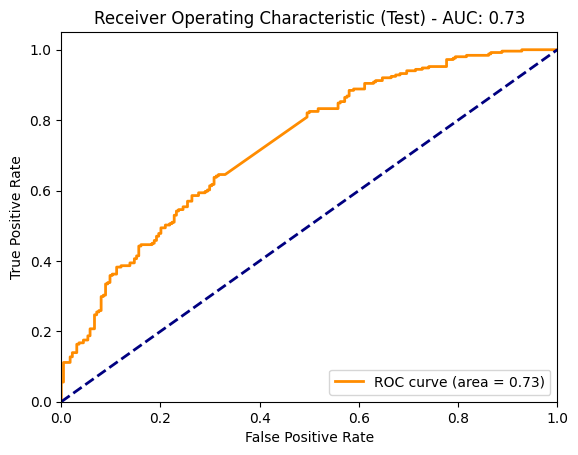

Confusion Matrix (Test):
 [[103 121]
 [ 42 209]]
Classification Report (Test):
               precision    recall  f1-score   support

         0.0       0.71      0.46      0.56       224
         1.0       0.63      0.83      0.72       251

    accuracy                           0.66       475
   macro avg       0.67      0.65      0.64       475
weighted avg       0.67      0.66      0.64       475



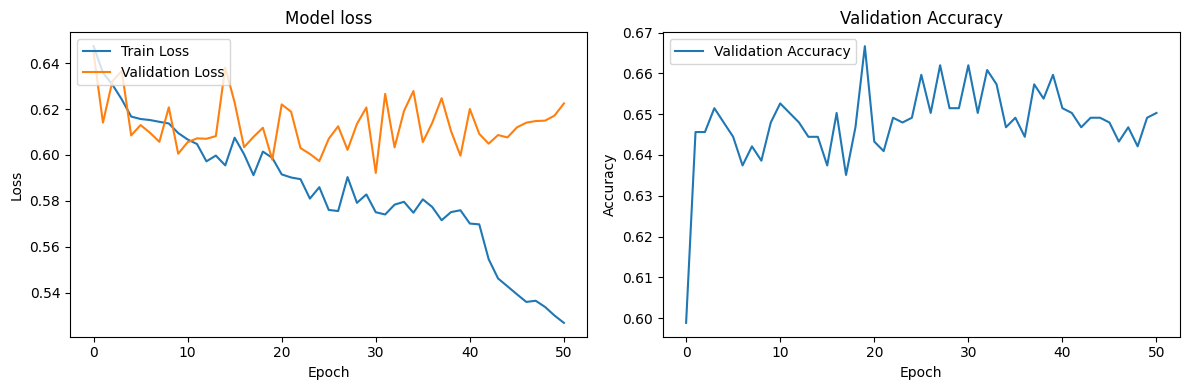

In [180]:
# Define the hyperparameters grid
param_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [50, 100],
    'layers': [(1024, 512, 256), (256, 128, 64), (512, 256, 128)],
    'dropout_rate': [0.1, 0.2]
}

# Function to train and evaluate the model with given parameters
def train_evaluate(params):
    input_dim = X_train.shape[1]
    model = create_model(input_dim, params['layers'], params['dropout_rate'])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=params['epochs'] // 10, verbose=True)

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    best_val_loss = float('inf')
    early_stopping_patience = params['epochs'] // 5
    early_stopping_counter = 0
    num_epochs = params['epochs']

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_val_loss += loss.item() * X_batch.size(0)

                preds = (outputs > 0.5).float()
                correct_predictions += (preds == y_batch).sum().item()
                total_predictions += y_batch.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct_predictions / total_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

        scheduler.step(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping")
                break

    model.load_state_dict(torch.load('best_model.pth'))

    return model, train_losses, val_losses, val_accuracies

# Perform grid search
best_params = None
best_accuracy = 0

for lr in param_grid['learning_rate']:
    for bs in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            for layers in param_grid['layers']:
                for dropout_rate in param_grid['dropout_rate']:
                    params = {
                        'learning_rate': lr,
                        'batch_size': bs,
                        'epochs': epochs,
                        'layers': layers,
                        'dropout_rate': dropout_rate
                    }
                    model, train_losses, val_losses, val_accuracies = train_evaluate(params)
                    model.eval()
                    y_test_pred_prob = []
                    y_test_true = []
                    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)  # Ensure test_loader here as well
                    with torch.no_grad():
                        for X_batch, y_batch in test_loader:
                            outputs = model(X_batch)
                            y_test_pred_prob.append(outputs.numpy())
                            y_test_true.append(y_batch.numpy())
                    y_test_pred_prob = np.vstack(y_test_pred_prob).ravel()
                    y_test_true = np.vstack(y_test_true).ravel()
                    y_test_pred = (y_test_pred_prob > 0.5).astype(int)
                    test_accuracy = accuracy_score(y_test_true, y_test_pred)
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        best_params = params
                    print(f"Params: {params}, Test Accuracy: {test_accuracy}")

print(f"Best Params: {best_params}, Best Accuracy: {best_accuracy}")

# Loading best model
model, train_losses, val_losses, val_accuracies = train_evaluate(best_params)
model.eval()

# Evaluate best model on the test set
y_test_pred_prob = []
y_test_true = []
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)  # Ensure test_loader here as well
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        y_test_pred_prob.append(outputs.numpy())
        y_test_true.append(y_batch.numpy())
y_test_pred_prob = np.vstack(y_test_pred_prob).ravel()
y_test_true = np.vstack(y_test_true).ravel()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

test_accuracy = accuracy_score(y_test_true, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test_true, y_test_pred)
print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test_true, y_test_pred))

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Results (Test Accuracy):


**1. feature_dataset_list_env_rms**

*  SVM: 0.52
*  MLP: 0.53

  Epoch 24/50, Train Loss: 0.6328, Val Loss: 0.6836, Val Accuracy: 0.5906


**2. feature_dataset_list_cwt**

*  SVM: 0.52
*  MLP: 0.56

Epoch 19/50, Train Loss: 0.5143, Val Loss: 0.8116, Val Accuracy: 0.5427
bad with PCA


**3. feature_dataset_list_FFTstat**
*  SVM: 0.58
*  MLP: 0.61

Epoch 20/50, Train Loss: 0.6269, Val Loss: 0.6290, Val Accuracy: 0.6246


**4. feature_dataset_list_FFT_entropy**
*  SVM: 0.61
*  MLP: 0.61


**5. feature_dataset_list_DWTstat**
*  SVM: 0.61
*  MLP: 0.63


**6. feature_data_list_combine_features**
*  SVM: 0.55
*  MLP: 0.58


**7. principal_df** - with ALL FEATURES

*  **SVM: 0.66**

*  **MLP: 0.68**

*  **MLP (hyper parameter tune): 0.65**



# 7. Conclusions

1. Linear classifier not idea for this case, when data points are too close to each other. Would need non-linear classification and decision trees for dealing with non-linear data. Based on "extra attempts" below, random forest and XGBoost models were producing > 70 % accuracy.
2. Data points too close to each other, need to use clustering technique to see how close the two classes are. It is possible that some eeg signals have 40-50 % fatigue and non-fatigue classes. For such similar cases, the data should be removed. Or the label classes could be in a range from 0 to 1 instead of having strict 2 classes.
3. Best performing data is with ALL features with PCA reduction - shows that only relevant features are important.
4. Data could be improved by implementing more robust denoising techniques to clean signals, and extract stronger features
5. More complex models required, such as a deeper network, or CNN, ResNet.

# 8. Extra Attempts

Test with feature_dataset_list_DWTstat data

Test Accuracy: 0.6458333333333334


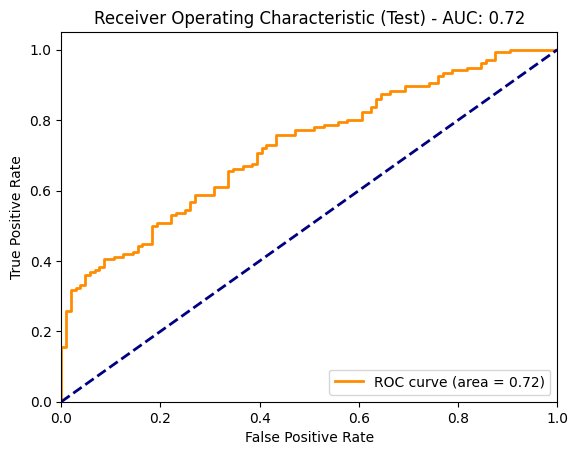

Confusion Matrix (Test):
 [[63 41]
 [44 92]]
Classification Report (Test):
               precision    recall  f1-score   support

         0.0       0.59      0.61      0.60       104
         1.0       0.69      0.68      0.68       136

    accuracy                           0.65       240
   macro avg       0.64      0.64      0.64       240
weighted avg       0.65      0.65      0.65       240



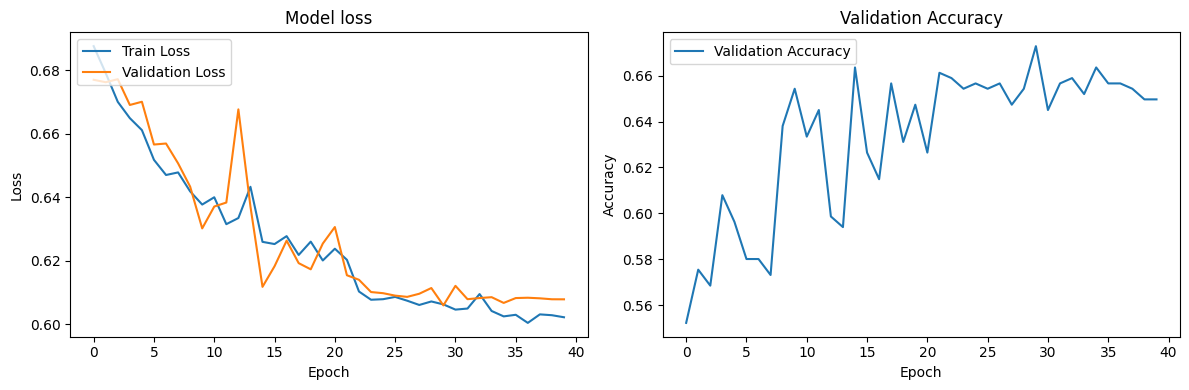

In [ ]:
# Load the best model
model.eval()

# Evaluate the best model on the test set
y_test_pred_prob = []
y_test_true = []
test_loader = DataLoader(test_dataset, batch_size= batch, shuffle=False)  # Ensure test_loader here as well
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        y_test_pred_prob.append(outputs.numpy())
        y_test_true.append(y_batch.numpy())
y_test_pred_prob = np.vstack(y_test_pred_prob).ravel()
y_test_true = np.vstack(y_test_true).ravel()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

test_accuracy = accuracy_score(y_test_true, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test_true, y_test_pred)
print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test_true, y_test_pred))

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Test with principal_df data

Test Accuracy: 0.6291666666666667


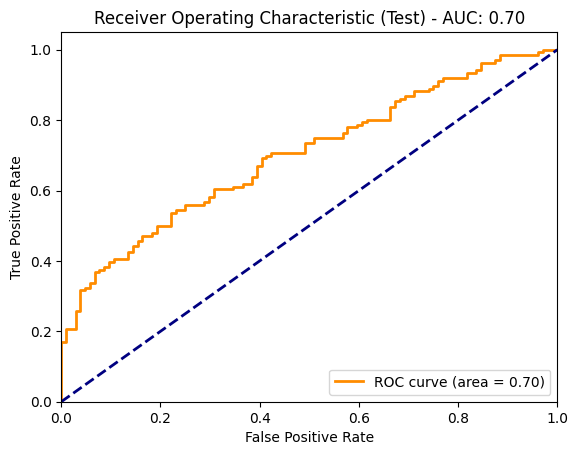

Confusion Matrix (Test):
 [[55 49]
 [40 96]]
Classification Report (Test):
               precision    recall  f1-score   support

         0.0       0.58      0.53      0.55       104
         1.0       0.66      0.71      0.68       136

    accuracy                           0.63       240
   macro avg       0.62      0.62      0.62       240
weighted avg       0.63      0.63      0.63       240



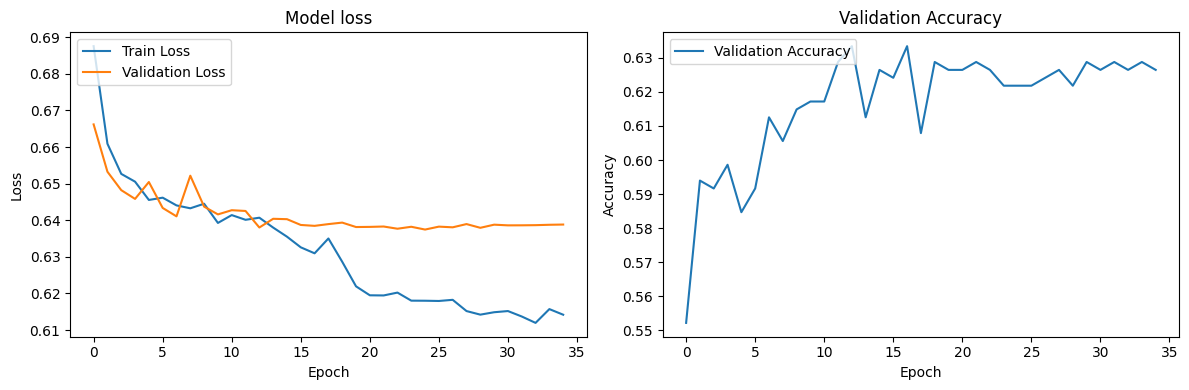

In [ ]:
# Load the best model
model.eval()

# Evaluate the best model on the test set
y_test_pred_prob = []
y_test_true = []
test_loader = DataLoader(test_dataset, batch_size= batch, shuffle=False)  # Ensure test_loader here as well
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        y_test_pred_prob.append(outputs.numpy())
        y_test_true.append(y_batch.numpy())
y_test_pred_prob = np.vstack(y_test_pred_prob).ravel()
y_test_true = np.vstack(y_test_true).ravel()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

test_accuracy = accuracy_score(y_test_true, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test_true, y_test_pred)
print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test_true, y_test_pred))

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#**Ablation 0: Combining all Features and PCA**


### Logistic Regression

Best Hyperparameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Test Accuracy: 0.6625


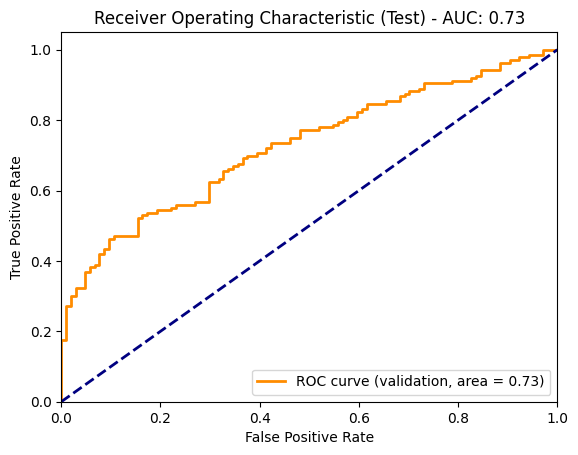

Confusion Matrix (Test):
 [[63 41]
 [40 96]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.61      0.61      0.61       104
           1       0.70      0.71      0.70       136

    accuracy                           0.66       240
   macro avg       0.66      0.66      0.66       240
weighted avg       0.66      0.66      0.66       240



In [ ]:
# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Different solvers
    'penalty': ['l1', 'l2'],  # Different regularization penalties
    'max_iter': [100, 500, 1000]  # Maximum number of iterations
}

# Initialize logistic regression model
logistic_model = LogisticRegression(random_state=42)

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_val, y_train_val)

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Train the model with the best hyperparameters on the entire training+validation set
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
y_test_prob = best_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (validation, area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))

### Random Forest

Best Hyperparameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Test Accuracy: 0.7166666666666667


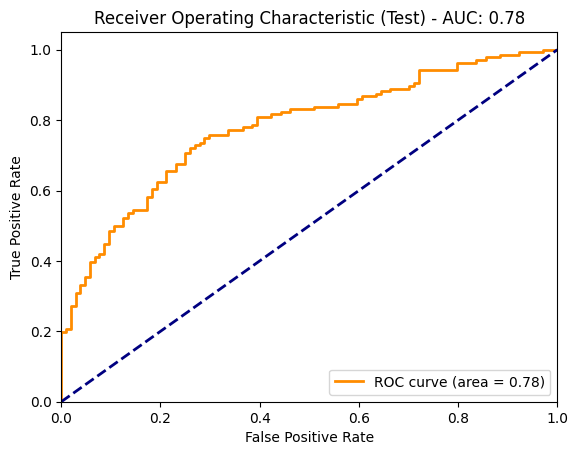

Confusion Matrix (Test):
 [[ 69  35]
 [ 33 103]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.68      0.66      0.67       104
           1       0.75      0.76      0.75       136

    accuracy                           0.72       240
   macro avg       0.71      0.71      0.71       240
weighted avg       0.72      0.72      0.72       240



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_val, y_train_val)

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Train the model with the best hyperparameters on the entire training+validation set
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
y_test_prob = best_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))


### XGBoost

Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.6}
Test Accuracy: 0.725


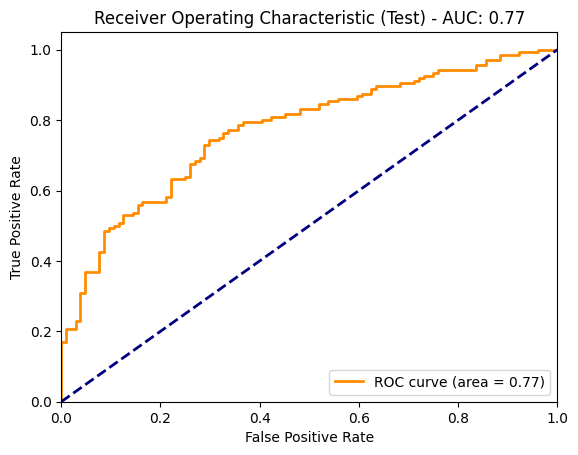

Confusion Matrix (Test):
 [[ 66  38]
 [ 28 108]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.70      0.63      0.67       104
           1       0.74      0.79      0.77       136

    accuracy                           0.73       240
   macro avg       0.72      0.71      0.72       240
weighted avg       0.72      0.72      0.72       240



In [ ]:
from xgboost import XGBClassifier

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'max_depth': [3, 6, 9],  # Maximum tree depth for base learners
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instance
    'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2]  # Minimum loss reduction required to make a further partition on a leaf node
}

# Initialize XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_val, y_train_val)

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Train the model with the best hyperparameters on the entire training+validation set
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
y_test_prob = best_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))

### Deep Learning Classification

In [ ]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6573, Val Loss: 0.6180, Val Accuracy: 0.6497
Epoch 2/50, Train Loss: 0.6187, Val Loss: 0.6139, Val Accuracy: 0.6520
Epoch 3/50, Train Loss: 0.6110, Val Loss: 0.6152, Val Accuracy: 0.6427
Epoch 4/50, Train Loss: 0.6005, Val Loss: 0.6033, Val Accuracy: 0.6566
Epoch 5/50, Train Loss: 0.5918, Val Loss: 0.5964, Val Accuracy: 0.6543
Epoch 6/50, Train Loss: 0.5968, Val Loss: 0.5921, Val Accuracy: 0.6775
Epoch 7/50, Train Loss: 0.5880, Val Loss: 0.5901, Val Accuracy: 0.6682
Epoch 8/50, Train Loss: 0.5786, Val Loss: 0.5870, Val Accuracy: 0.6682
Epoch 9/50, Train Loss: 0.5683, Val Loss: 0.5863, Val Accuracy: 0.6682
Epoch 10/50, Train Loss: 0.5689, Val Loss: 0.5780, Val Accuracy: 0.6937
Epoch 11/50, Train Loss: 0.5579, Val Loss: 0.5905, Val Accuracy: 0.6729
Epoch 12/50, Train Loss: 0.5612, Val Loss: 0.5802, Val Accuracy: 0.6891
Epoch 13/50, Train Loss: 0.5505, Val Loss: 0.5861, Val Accuracy: 0.6914
Epoch 14/50, Train Loss: 0.5382, Val Loss: 0.5799, Val Accuracy: 0.6984
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6671, Val Loss: 0.6251, Val Accuracy: 0.6265
Epoch 2/50, Train Loss: 0.6327, Val Loss: 0.6127, Val Accuracy: 0.6427
Epoch 3/50, Train Loss: 0.6174, Val Loss: 0.6171, Val Accuracy: 0.6241
Epoch 4/50, Train Loss: 0.6166, Val Loss: 0.6025, Val Accuracy: 0.6636
Epoch 5/50, Train Loss: 0.6122, Val Loss: 0.5973, Val Accuracy: 0.6613
Epoch 6/50, Train Loss: 0.6133, Val Loss: 0.5995, Val Accuracy: 0.6636
Epoch 7/50, Train Loss: 0.5995, Val Loss: 0.5964, Val Accuracy: 0.6752
Epoch 8/50, Train Loss: 0.5981, Val Loss: 0.5920, Val Accuracy: 0.6705
Epoch 9/50, Train Loss: 0.6037, Val Loss: 0.5893, Val Accuracy: 0.6752
Epoch 10/50, Train Loss: 0.5936, Val Loss: 0.5900, Val Accuracy: 0.6914
Epoch 11/50, Train Loss: 0.5937, Val Loss: 0.5854, Val Accuracy: 0.6868
Epoch 12/50, Train Loss: 0.5813, Val Loss: 0.5882, Val Accuracy: 0.6659
Epoch 13/50, Train Loss: 0.5933, Val Loss: 0.5839, Val Accuracy: 0.6752
Epoch 14/50, Train Loss: 0.5933, Val Loss: 0.5844, Val Accuracy: 0.6775
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6498, Val Loss: 0.6061, Val Accuracy: 0.6520
Epoch 2/50, Train Loss: 0.6193, Val Loss: 0.5976, Val Accuracy: 0.6752
Epoch 3/50, Train Loss: 0.6031, Val Loss: 0.5914, Val Accuracy: 0.6891
Epoch 4/50, Train Loss: 0.5988, Val Loss: 0.5910, Val Accuracy: 0.6775
Epoch 5/50, Train Loss: 0.5821, Val Loss: 0.6030, Val Accuracy: 0.6543
Epoch 6/50, Train Loss: 0.5729, Val Loss: 0.5879, Val Accuracy: 0.6682
Epoch 7/50, Train Loss: 0.5597, Val Loss: 0.5797, Val Accuracy: 0.6775
Epoch 8/50, Train Loss: 0.5593, Val Loss: 0.6104, Val Accuracy: 0.6427
Epoch 9/50, Train Loss: 0.5514, Val Loss: 0.6046, Val Accuracy: 0.6845
Epoch 10/50, Train Loss: 0.5462, Val Loss: 0.6047, Val Accuracy: 0.6937
Epoch 11/50, Train Loss: 0.5381, Val Loss: 0.5916, Val Accuracy: 0.6775
Epoch 12/50, Train Loss: 0.5274, Val Loss: 0.6557, Val Accuracy: 0.6636
Epoch 13/50, Train Loss: 0.5261, Val Loss: 0.5983, Val Accuracy: 0.6868
Epoch 14/50, Train Loss: 0.5029, Val Loss: 0.5987, Val Accuracy: 0.6891
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6577, Val Loss: 0.6144, Val Accuracy: 0.6381
Epoch 2/50, Train Loss: 0.6244, Val Loss: 0.6037, Val Accuracy: 0.6520
Epoch 3/50, Train Loss: 0.6175, Val Loss: 0.6017, Val Accuracy: 0.6729
Epoch 4/50, Train Loss: 0.6083, Val Loss: 0.5966, Val Accuracy: 0.6752
Epoch 5/50, Train Loss: 0.6075, Val Loss: 0.5962, Val Accuracy: 0.6775
Epoch 6/50, Train Loss: 0.6024, Val Loss: 0.5927, Val Accuracy: 0.6775
Epoch 7/50, Train Loss: 0.5984, Val Loss: 0.5916, Val Accuracy: 0.6659
Epoch 8/50, Train Loss: 0.5953, Val Loss: 0.5922, Val Accuracy: 0.6868
Epoch 9/50, Train Loss: 0.5849, Val Loss: 0.5902, Val Accuracy: 0.6775
Epoch 10/50, Train Loss: 0.5812, Val Loss: 0.5866, Val Accuracy: 0.6845
Epoch 11/50, Train Loss: 0.5765, Val Loss: 0.5856, Val Accuracy: 0.6636
Epoch 12/50, Train Loss: 0.5707, Val Loss: 0.5865, Val Accuracy: 0.6868
Epoch 13/50, Train Loss: 0.5709, Val Loss: 0.5822, Val Accuracy: 0.6775
Epoch 14/50, Train Loss: 0.5684, Val Loss: 0.5842, Val Accuracy: 0.6682
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6506, Val Loss: 0.6161, Val Accuracy: 0.6427
Epoch 2/100, Train Loss: 0.6213, Val Loss: 0.6147, Val Accuracy: 0.6334
Epoch 3/100, Train Loss: 0.6120, Val Loss: 0.6072, Val Accuracy: 0.6682
Epoch 4/100, Train Loss: 0.6044, Val Loss: 0.6069, Val Accuracy: 0.6682
Epoch 5/100, Train Loss: 0.5946, Val Loss: 0.5975, Val Accuracy: 0.6705
Epoch 6/100, Train Loss: 0.5915, Val Loss: 0.5936, Val Accuracy: 0.6775
Epoch 7/100, Train Loss: 0.5870, Val Loss: 0.5919, Val Accuracy: 0.6566
Epoch 8/100, Train Loss: 0.5773, Val Loss: 0.6003, Val Accuracy: 0.6613
Epoch 9/100, Train Loss: 0.5729, Val Loss: 0.6053, Val Accuracy: 0.6752
Epoch 10/100, Train Loss: 0.5642, Val Loss: 0.5957, Val Accuracy: 0.6775
Epoch 11/100, Train Loss: 0.5637, Val Loss: 0.5885, Val Accuracy: 0.6775
Epoch 12/100, Train Loss: 0.5594, Val Loss: 0.5852, Val Accuracy: 0.6914
Epoch 13/100, Train Loss: 0.5550, Val Loss: 0.5871, Val Accuracy: 0.6891
Epoch 14/100, Train Loss: 0.5488, Val Loss: 0.5713, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6652, Val Loss: 0.6163, Val Accuracy: 0.6659
Epoch 2/100, Train Loss: 0.6339, Val Loss: 0.6164, Val Accuracy: 0.6218
Epoch 3/100, Train Loss: 0.6175, Val Loss: 0.6123, Val Accuracy: 0.6404
Epoch 4/100, Train Loss: 0.6219, Val Loss: 0.6041, Val Accuracy: 0.6566
Epoch 5/100, Train Loss: 0.6112, Val Loss: 0.6081, Val Accuracy: 0.6543
Epoch 6/100, Train Loss: 0.6061, Val Loss: 0.5974, Val Accuracy: 0.6566
Epoch 7/100, Train Loss: 0.6059, Val Loss: 0.5986, Val Accuracy: 0.6613
Epoch 8/100, Train Loss: 0.6077, Val Loss: 0.5904, Val Accuracy: 0.6636
Epoch 9/100, Train Loss: 0.6008, Val Loss: 0.5896, Val Accuracy: 0.6636
Epoch 10/100, Train Loss: 0.5937, Val Loss: 0.5903, Val Accuracy: 0.6682
Epoch 11/100, Train Loss: 0.5902, Val Loss: 0.5896, Val Accuracy: 0.6613
Epoch 12/100, Train Loss: 0.5879, Val Loss: 0.5831, Val Accuracy: 0.6682
Epoch 13/100, Train Loss: 0.5889, Val Loss: 0.5881, Val Accuracy: 0.6682
Epoch 14/100, Train Loss: 0.5825, Val Loss: 0.5846, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6436, Val Loss: 0.6042, Val Accuracy: 0.6566
Epoch 2/100, Train Loss: 0.6125, Val Loss: 0.6024, Val Accuracy: 0.6566
Epoch 3/100, Train Loss: 0.6028, Val Loss: 0.6006, Val Accuracy: 0.6566
Epoch 4/100, Train Loss: 0.5944, Val Loss: 0.5896, Val Accuracy: 0.6752
Epoch 5/100, Train Loss: 0.5901, Val Loss: 0.5969, Val Accuracy: 0.6845
Epoch 6/100, Train Loss: 0.5733, Val Loss: 0.5827, Val Accuracy: 0.6937
Epoch 7/100, Train Loss: 0.5688, Val Loss: 0.5856, Val Accuracy: 0.6775
Epoch 8/100, Train Loss: 0.5683, Val Loss: 0.5819, Val Accuracy: 0.6845
Epoch 9/100, Train Loss: 0.5550, Val Loss: 0.5889, Val Accuracy: 0.7007
Epoch 10/100, Train Loss: 0.5536, Val Loss: 0.5798, Val Accuracy: 0.6845
Epoch 11/100, Train Loss: 0.5354, Val Loss: 0.5834, Val Accuracy: 0.6961
Epoch 12/100, Train Loss: 0.5358, Val Loss: 0.6007, Val Accuracy: 0.6821
Epoch 13/100, Train Loss: 0.5336, Val Loss: 0.6056, Val Accuracy: 0.6798
Epoch 14/100, Train Loss: 0.5235, Val Loss: 0.5896, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6507, Val Loss: 0.6168, Val Accuracy: 0.6334
Epoch 2/100, Train Loss: 0.6260, Val Loss: 0.6050, Val Accuracy: 0.6473
Epoch 3/100, Train Loss: 0.6173, Val Loss: 0.6001, Val Accuracy: 0.6427
Epoch 4/100, Train Loss: 0.6051, Val Loss: 0.5962, Val Accuracy: 0.6636
Epoch 5/100, Train Loss: 0.6105, Val Loss: 0.5913, Val Accuracy: 0.6752
Epoch 6/100, Train Loss: 0.6030, Val Loss: 0.5931, Val Accuracy: 0.6682
Epoch 7/100, Train Loss: 0.5949, Val Loss: 0.5866, Val Accuracy: 0.6729
Epoch 8/100, Train Loss: 0.5925, Val Loss: 0.5955, Val Accuracy: 0.6961
Epoch 9/100, Train Loss: 0.5845, Val Loss: 0.5884, Val Accuracy: 0.6705
Epoch 10/100, Train Loss: 0.5777, Val Loss: 0.5787, Val Accuracy: 0.6682
Epoch 11/100, Train Loss: 0.5765, Val Loss: 0.5807, Val Accuracy: 0.6961
Epoch 12/100, Train Loss: 0.5756, Val Loss: 0.5901, Val Accuracy: 0.6798
Epoch 13/100, Train Loss: 0.5667, Val Loss: 0.5951, Val Accuracy: 0.6798
Epoch 14/100, Train Loss: 0.5630, Val Loss: 0.5946, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/50, Train Loss: 0.6240, Val Loss: 0.6103, Val Accuracy: 0.6473
Epoch 3/50, Train Loss: 0.6166, Val Loss: 0.6035, Val Accuracy: 0.6752
Epoch 4/50, Train Loss: 0.6050, Val Loss: 0.5994, Val Accuracy: 0.6636
Epoch 5/50, Train Loss: 0.6030, Val Loss: 0.5949, Val Accuracy: 0.6589
Epoch 6/50, Train Loss: 0.5969, Val Loss: 0.5931, Val Accuracy: 0.6636
Epoch 7/50, Train Loss: 0.5871, Val Loss: 0.5866, Val Accuracy: 0.6821
Epoch 8/50, Train Loss: 0.5818, Val Loss: 0.5852, Val Accuracy: 0.6775
Epoch 9/50, Train Loss: 0.5782, Val Loss: 0.5857, Val Accuracy: 0.6914
Epoch 10/50, Train Loss: 0.5756, Val Loss: 0.5864, Val Accuracy: 0.6845
Epoch 11/50, Train Loss: 0.5736, Val Loss: 0.5943, Val Accuracy: 0.6705
Epoch 12/50, Train Loss: 0.5654, Val Loss: 0.5863, Val Accuracy: 0.6868
Epoch 13/50, Train Loss: 0.5683, Val Loss: 0.5832, Val Accuracy: 0.7007
Epoch 14/50, Train Loss: 0.5513, Val Loss: 0.5792, Val Accuracy: 0.6845
Epoch 15/50, Train Loss: 0.5446, Val Loss: 0.5783, Val Accuracy: 0.6845


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6763, Val Loss: 0.6483, Val Accuracy: 0.6381
Epoch 2/50, Train Loss: 0.6391, Val Loss: 0.6255, Val Accuracy: 0.6334
Epoch 3/50, Train Loss: 0.6230, Val Loss: 0.6159, Val Accuracy: 0.6566
Epoch 4/50, Train Loss: 0.6242, Val Loss: 0.6135, Val Accuracy: 0.6404
Epoch 5/50, Train Loss: 0.6143, Val Loss: 0.6075, Val Accuracy: 0.6659
Epoch 6/50, Train Loss: 0.6153, Val Loss: 0.6118, Val Accuracy: 0.6473
Epoch 7/50, Train Loss: 0.6111, Val Loss: 0.6037, Val Accuracy: 0.6682
Epoch 8/50, Train Loss: 0.5991, Val Loss: 0.6008, Val Accuracy: 0.6705
Epoch 9/50, Train Loss: 0.6089, Val Loss: 0.6132, Val Accuracy: 0.6473
Epoch 10/50, Train Loss: 0.6027, Val Loss: 0.5982, Val Accuracy: 0.6705
Epoch 11/50, Train Loss: 0.5985, Val Loss: 0.6039, Val Accuracy: 0.6705
Epoch 12/50, Train Loss: 0.5998, Val Loss: 0.6034, Val Accuracy: 0.6613
Epoch 13/50, Train Loss: 0.5904, Val Loss: 0.5943, Val Accuracy: 0.6636
Epoch 14/50, Train Loss: 0.5870, Val Loss: 0.5909, Val Accuracy: 0.6566
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6465, Val Loss: 0.6170, Val Accuracy: 0.6427
Epoch 2/50, Train Loss: 0.6238, Val Loss: 0.6060, Val Accuracy: 0.6543
Epoch 3/50, Train Loss: 0.6109, Val Loss: 0.6045, Val Accuracy: 0.6589
Epoch 4/50, Train Loss: 0.5990, Val Loss: 0.5932, Val Accuracy: 0.6775
Epoch 5/50, Train Loss: 0.5886, Val Loss: 0.5935, Val Accuracy: 0.6821
Epoch 6/50, Train Loss: 0.5850, Val Loss: 0.5885, Val Accuracy: 0.6613
Epoch 7/50, Train Loss: 0.5741, Val Loss: 0.5820, Val Accuracy: 0.6752
Epoch 8/50, Train Loss: 0.5710, Val Loss: 0.5740, Val Accuracy: 0.6821
Epoch 9/50, Train Loss: 0.5652, Val Loss: 0.5941, Val Accuracy: 0.6798
Epoch 10/50, Train Loss: 0.5557, Val Loss: 0.5815, Val Accuracy: 0.6845
Epoch 11/50, Train Loss: 0.5498, Val Loss: 0.5860, Val Accuracy: 0.7007
Epoch 12/50, Train Loss: 0.5448, Val Loss: 0.5864, Val Accuracy: 0.6798
Epoch 13/50, Train Loss: 0.5337, Val Loss: 0.5980, Val Accuracy: 0.6775
Epoch 14/50, Train Loss: 0.5398, Val Loss: 0.5914, Val Accuracy: 0.6961
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6643, Val Loss: 0.6248, Val Accuracy: 0.6265
Epoch 2/50, Train Loss: 0.6292, Val Loss: 0.6120, Val Accuracy: 0.6334
Epoch 3/50, Train Loss: 0.6195, Val Loss: 0.6149, Val Accuracy: 0.6450
Epoch 4/50, Train Loss: 0.6059, Val Loss: 0.6003, Val Accuracy: 0.6636
Epoch 5/50, Train Loss: 0.6056, Val Loss: 0.5904, Val Accuracy: 0.6752
Epoch 6/50, Train Loss: 0.5991, Val Loss: 0.5955, Val Accuracy: 0.6636
Epoch 7/50, Train Loss: 0.5986, Val Loss: 0.5989, Val Accuracy: 0.6566
Epoch 8/50, Train Loss: 0.5938, Val Loss: 0.5966, Val Accuracy: 0.6613
Epoch 9/50, Train Loss: 0.5917, Val Loss: 0.5899, Val Accuracy: 0.6821
Epoch 10/50, Train Loss: 0.5866, Val Loss: 0.5858, Val Accuracy: 0.6891
Epoch 11/50, Train Loss: 0.5812, Val Loss: 0.5839, Val Accuracy: 0.6798
Epoch 12/50, Train Loss: 0.5815, Val Loss: 0.5832, Val Accuracy: 0.6891
Epoch 13/50, Train Loss: 0.5816, Val Loss: 0.5876, Val Accuracy: 0.6752
Epoch 14/50, Train Loss: 0.5711, Val Loss: 0.5956, Val Accuracy: 0.6775
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/100, Train Loss: 0.6232, Val Loss: 0.6112, Val Accuracy: 0.6497
Epoch 3/100, Train Loss: 0.6095, Val Loss: 0.6028, Val Accuracy: 0.6705
Epoch 4/100, Train Loss: 0.6072, Val Loss: 0.5997, Val Accuracy: 0.6659
Epoch 5/100, Train Loss: 0.6036, Val Loss: 0.5972, Val Accuracy: 0.6613
Epoch 6/100, Train Loss: 0.5974, Val Loss: 0.5963, Val Accuracy: 0.6729
Epoch 7/100, Train Loss: 0.5914, Val Loss: 0.5942, Val Accuracy: 0.6659
Epoch 8/100, Train Loss: 0.5896, Val Loss: 0.5882, Val Accuracy: 0.6775
Epoch 9/100, Train Loss: 0.5920, Val Loss: 0.5849, Val Accuracy: 0.6636
Epoch 10/100, Train Loss: 0.5767, Val Loss: 0.5829, Val Accuracy: 0.6729
Epoch 11/100, Train Loss: 0.5760, Val Loss: 0.5810, Val Accuracy: 0.6752
Epoch 12/100, Train Loss: 0.5727, Val Loss: 0.5804, Val Accuracy: 0.6752
Epoch 13/100, Train Loss: 0.5742, Val Loss: 0.5838, Val Accuracy: 0.6752
Epoch 14/100, Train Loss: 0.5699, Val Loss: 0.5804, Val Accuracy: 0.6798
Epoch 15/100, Train Loss: 0.5551, Val Loss: 0.5837, Val Acc

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6789, Val Loss: 0.6450, Val Accuracy: 0.6497
Epoch 2/100, Train Loss: 0.6419, Val Loss: 0.6192, Val Accuracy: 0.6381
Epoch 3/100, Train Loss: 0.6218, Val Loss: 0.6173, Val Accuracy: 0.6241
Epoch 4/100, Train Loss: 0.6168, Val Loss: 0.6068, Val Accuracy: 0.6613
Epoch 5/100, Train Loss: 0.6226, Val Loss: 0.6016, Val Accuracy: 0.6705
Epoch 6/100, Train Loss: 0.6120, Val Loss: 0.6006, Val Accuracy: 0.6613
Epoch 7/100, Train Loss: 0.6054, Val Loss: 0.5965, Val Accuracy: 0.6705
Epoch 8/100, Train Loss: 0.6012, Val Loss: 0.5981, Val Accuracy: 0.6636
Epoch 9/100, Train Loss: 0.6045, Val Loss: 0.5949, Val Accuracy: 0.6613
Epoch 10/100, Train Loss: 0.6020, Val Loss: 0.5905, Val Accuracy: 0.6659
Epoch 11/100, Train Loss: 0.5997, Val Loss: 0.5971, Val Accuracy: 0.6589
Epoch 12/100, Train Loss: 0.5905, Val Loss: 0.5892, Val Accuracy: 0.6682
Epoch 13/100, Train Loss: 0.5870, Val Loss: 0.5878, Val Accuracy: 0.6821
Epoch 14/100, Train Loss: 0.5927, Val Loss: 0.5860, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6417, Val Loss: 0.6070, Val Accuracy: 0.6497
Epoch 2/100, Train Loss: 0.6183, Val Loss: 0.6029, Val Accuracy: 0.6543
Epoch 3/100, Train Loss: 0.6138, Val Loss: 0.6032, Val Accuracy: 0.6729
Epoch 4/100, Train Loss: 0.5966, Val Loss: 0.5904, Val Accuracy: 0.6659
Epoch 5/100, Train Loss: 0.5889, Val Loss: 0.5786, Val Accuracy: 0.6937
Epoch 6/100, Train Loss: 0.5842, Val Loss: 0.5786, Val Accuracy: 0.6984
Epoch 7/100, Train Loss: 0.5756, Val Loss: 0.5808, Val Accuracy: 0.6821
Epoch 8/100, Train Loss: 0.5691, Val Loss: 0.5731, Val Accuracy: 0.6868
Epoch 9/100, Train Loss: 0.5602, Val Loss: 0.5838, Val Accuracy: 0.6891
Epoch 10/100, Train Loss: 0.5679, Val Loss: 0.5702, Val Accuracy: 0.6868
Epoch 11/100, Train Loss: 0.5534, Val Loss: 0.5788, Val Accuracy: 0.6775
Epoch 12/100, Train Loss: 0.5446, Val Loss: 0.5796, Val Accuracy: 0.6659
Epoch 13/100, Train Loss: 0.5457, Val Loss: 0.5761, Val Accuracy: 0.6705
Epoch 14/100, Train Loss: 0.5382, Val Loss: 0.5789, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6578, Val Loss: 0.6103, Val Accuracy: 0.6473
Epoch 2/100, Train Loss: 0.6297, Val Loss: 0.6134, Val Accuracy: 0.6705
Epoch 3/100, Train Loss: 0.6212, Val Loss: 0.6070, Val Accuracy: 0.6613
Epoch 4/100, Train Loss: 0.6105, Val Loss: 0.6026, Val Accuracy: 0.6613
Epoch 5/100, Train Loss: 0.6066, Val Loss: 0.5930, Val Accuracy: 0.6682
Epoch 6/100, Train Loss: 0.6004, Val Loss: 0.5927, Val Accuracy: 0.6659
Epoch 7/100, Train Loss: 0.5987, Val Loss: 0.5899, Val Accuracy: 0.6566
Epoch 8/100, Train Loss: 0.5940, Val Loss: 0.5892, Val Accuracy: 0.6775
Epoch 9/100, Train Loss: 0.5953, Val Loss: 0.5931, Val Accuracy: 0.6705
Epoch 10/100, Train Loss: 0.5842, Val Loss: 0.5924, Val Accuracy: 0.6845
Epoch 11/100, Train Loss: 0.5781, Val Loss: 0.5921, Val Accuracy: 0.6775
Epoch 12/100, Train Loss: 0.5748, Val Loss: 0.5816, Val Accuracy: 0.6891
Epoch 13/100, Train Loss: 0.5709, Val Loss: 0.5798, Val Accuracy: 0.6845
Epoch 14/100, Train Loss: 0.5822, Val Loss: 0.5799, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6409, Val Loss: 0.6260, Val Accuracy: 0.6381
Epoch 2/50, Train Loss: 0.6298, Val Loss: 0.6309, Val Accuracy: 0.6705
Epoch 3/50, Train Loss: 0.6106, Val Loss: 0.5991, Val Accuracy: 0.6659
Epoch 4/50, Train Loss: 0.6024, Val Loss: 0.5976, Val Accuracy: 0.6636
Epoch 5/50, Train Loss: 0.6065, Val Loss: 0.5983, Val Accuracy: 0.6566
Epoch 6/50, Train Loss: 0.5971, Val Loss: 0.5944, Val Accuracy: 0.6705
Epoch 7/50, Train Loss: 0.5934, Val Loss: 0.6013, Val Accuracy: 0.6798
Epoch 8/50, Train Loss: 0.5904, Val Loss: 0.6148, Val Accuracy: 0.6682
Epoch 9/50, Train Loss: 0.5909, Val Loss: 0.5956, Val Accuracy: 0.6798
Epoch 10/50, Train Loss: 0.5959, Val Loss: 0.6088, Val Accuracy: 0.6775
Epoch 11/50, Train Loss: 0.5827, Val Loss: 0.5879, Val Accuracy: 0.6729
Epoch 12/50, Train Loss: 0.5861, Val Loss: 0.6030, Val Accuracy: 0.6729
Epoch 13/50, Train Loss: 0.5913, Val Loss: 0.6043, Val Accuracy: 0.6543
Epoch 14/50, Train Loss: 0.5837, Val Loss: 0.5968, Val Accuracy: 0.6659
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6578, Val Loss: 0.6076, Val Accuracy: 0.6682
Epoch 2/50, Train Loss: 0.6288, Val Loss: 0.6118, Val Accuracy: 0.6543
Epoch 3/50, Train Loss: 0.6279, Val Loss: 0.6201, Val Accuracy: 0.6659
Epoch 4/50, Train Loss: 0.6194, Val Loss: 0.6010, Val Accuracy: 0.6752
Epoch 5/50, Train Loss: 0.6320, Val Loss: 0.6272, Val Accuracy: 0.6473
Epoch 6/50, Train Loss: 0.6276, Val Loss: 0.6050, Val Accuracy: 0.6659
Epoch 7/50, Train Loss: 0.6141, Val Loss: 0.6115, Val Accuracy: 0.6636
Epoch 8/50, Train Loss: 0.6248, Val Loss: 0.6153, Val Accuracy: 0.6473
Epoch 9/50, Train Loss: 0.6274, Val Loss: 0.6136, Val Accuracy: 0.6659
Epoch 10/50, Train Loss: 0.6231, Val Loss: 0.5992, Val Accuracy: 0.6543
Epoch 11/50, Train Loss: 0.6167, Val Loss: 0.5878, Val Accuracy: 0.6659
Epoch 12/50, Train Loss: 0.6136, Val Loss: 0.6109, Val Accuracy: 0.6891
Epoch 13/50, Train Loss: 0.6012, Val Loss: 0.5976, Val Accuracy: 0.6613
Epoch 14/50, Train Loss: 0.6114, Val Loss: 0.5997, Val Accuracy: 0.6705
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6632, Val Loss: 0.6113, Val Accuracy: 0.6636
Epoch 2/50, Train Loss: 0.6298, Val Loss: 0.5929, Val Accuracy: 0.6729
Epoch 3/50, Train Loss: 0.6206, Val Loss: 0.6095, Val Accuracy: 0.6334
Epoch 4/50, Train Loss: 0.6211, Val Loss: 0.6014, Val Accuracy: 0.6868
Epoch 5/50, Train Loss: 0.6203, Val Loss: 0.6079, Val Accuracy: 0.6497
Epoch 6/50, Train Loss: 0.6153, Val Loss: 0.6157, Val Accuracy: 0.6659
Epoch 7/50, Train Loss: 0.6018, Val Loss: 0.6079, Val Accuracy: 0.6659
Epoch 8/50, Train Loss: 0.6037, Val Loss: 0.6324, Val Accuracy: 0.6636
Epoch 9/50, Train Loss: 0.5641, Val Loss: 0.5928, Val Accuracy: 0.6868
Epoch 10/50, Train Loss: 0.5584, Val Loss: 0.5863, Val Accuracy: 0.6868
Epoch 11/50, Train Loss: 0.5411, Val Loss: 0.5881, Val Accuracy: 0.6914
Epoch 12/50, Train Loss: 0.5293, Val Loss: 0.5938, Val Accuracy: 0.6891
Epoch 13/50, Train Loss: 0.5345, Val Loss: 0.5969, Val Accuracy: 0.6937
Epoch 14/50, Train Loss: 0.5264, Val Loss: 0.5917, Val Accuracy: 0.7007
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6701, Val Loss: 0.6524, Val Accuracy: 0.6311
Epoch 2/50, Train Loss: 0.6419, Val Loss: 0.6133, Val Accuracy: 0.6682
Epoch 3/50, Train Loss: 0.6329, Val Loss: 0.6064, Val Accuracy: 0.6497
Epoch 4/50, Train Loss: 0.6254, Val Loss: 0.6100, Val Accuracy: 0.6427
Epoch 5/50, Train Loss: 0.6284, Val Loss: 0.6603, Val Accuracy: 0.6821
Epoch 6/50, Train Loss: 0.6252, Val Loss: 0.6043, Val Accuracy: 0.6961
Epoch 7/50, Train Loss: 0.6266, Val Loss: 0.6164, Val Accuracy: 0.6752
Epoch 8/50, Train Loss: 0.6310, Val Loss: 0.5989, Val Accuracy: 0.6659
Epoch 9/50, Train Loss: 0.6186, Val Loss: 0.5959, Val Accuracy: 0.6613
Epoch 10/50, Train Loss: 0.6376, Val Loss: 0.5979, Val Accuracy: 0.6566
Epoch 11/50, Train Loss: 0.6376, Val Loss: 0.5914, Val Accuracy: 0.6636
Epoch 12/50, Train Loss: 0.6323, Val Loss: 0.5999, Val Accuracy: 0.6937
Epoch 13/50, Train Loss: 0.6323, Val Loss: 0.6112, Val Accuracy: 0.6566
Epoch 14/50, Train Loss: 0.6435, Val Loss: 0.6167, Val Accuracy: 0.6520
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6582, Val Loss: 0.6214, Val Accuracy: 0.6265
Epoch 2/100, Train Loss: 0.6256, Val Loss: 0.6115, Val Accuracy: 0.6404
Epoch 3/100, Train Loss: 0.6153, Val Loss: 0.6107, Val Accuracy: 0.6357
Epoch 4/100, Train Loss: 0.6094, Val Loss: 0.6166, Val Accuracy: 0.6334
Epoch 5/100, Train Loss: 0.5959, Val Loss: 0.6055, Val Accuracy: 0.6705
Epoch 6/100, Train Loss: 0.6030, Val Loss: 0.6050, Val Accuracy: 0.6775
Epoch 7/100, Train Loss: 0.6144, Val Loss: 0.6016, Val Accuracy: 0.6520
Epoch 8/100, Train Loss: 0.6074, Val Loss: 0.6451, Val Accuracy: 0.6450
Epoch 9/100, Train Loss: 0.6259, Val Loss: 0.5903, Val Accuracy: 0.6566
Epoch 10/100, Train Loss: 0.5963, Val Loss: 0.6245, Val Accuracy: 0.6613
Epoch 11/100, Train Loss: 0.5886, Val Loss: 0.6084, Val Accuracy: 0.6589
Epoch 12/100, Train Loss: 0.5943, Val Loss: 0.5971, Val Accuracy: 0.6636
Epoch 13/100, Train Loss: 0.5803, Val Loss: 0.6043, Val Accuracy: 0.6729
Epoch 14/100, Train Loss: 0.5886, Val Loss: 0.5951, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6580, Val Loss: 0.6171, Val Accuracy: 0.6520
Epoch 2/100, Train Loss: 0.6389, Val Loss: 0.6394, Val Accuracy: 0.5754
Epoch 3/100, Train Loss: 0.6284, Val Loss: 0.6117, Val Accuracy: 0.6497
Epoch 4/100, Train Loss: 0.6264, Val Loss: 0.6114, Val Accuracy: 0.6659
Epoch 5/100, Train Loss: 0.6270, Val Loss: 0.6156, Val Accuracy: 0.6520
Epoch 6/100, Train Loss: 0.6159, Val Loss: 0.6058, Val Accuracy: 0.6589
Epoch 7/100, Train Loss: 0.6206, Val Loss: 0.6895, Val Accuracy: 0.6265
Epoch 8/100, Train Loss: 0.6762, Val Loss: 0.5916, Val Accuracy: 0.6775
Epoch 9/100, Train Loss: 0.6277, Val Loss: 0.6042, Val Accuracy: 0.6613
Epoch 10/100, Train Loss: 0.6130, Val Loss: 0.5984, Val Accuracy: 0.6636
Epoch 11/100, Train Loss: 0.6102, Val Loss: 0.6185, Val Accuracy: 0.6566
Epoch 12/100, Train Loss: 0.6153, Val Loss: 0.6219, Val Accuracy: 0.6682
Epoch 13/100, Train Loss: 0.6166, Val Loss: 0.6031, Val Accuracy: 0.6659
Epoch 14/100, Train Loss: 0.6097, Val Loss: 0.6012, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6670, Val Loss: 0.6129, Val Accuracy: 0.6705
Epoch 2/100, Train Loss: 0.6183, Val Loss: 0.6037, Val Accuracy: 0.6497
Epoch 3/100, Train Loss: 0.6239, Val Loss: 0.6228, Val Accuracy: 0.6752
Epoch 4/100, Train Loss: 0.6171, Val Loss: 0.6262, Val Accuracy: 0.6613
Epoch 5/100, Train Loss: 0.6185, Val Loss: 0.6220, Val Accuracy: 0.6659
Epoch 6/100, Train Loss: 0.6110, Val Loss: 0.5932, Val Accuracy: 0.6497
Epoch 7/100, Train Loss: 0.5895, Val Loss: 0.6010, Val Accuracy: 0.6566
Epoch 8/100, Train Loss: 0.5870, Val Loss: 0.5951, Val Accuracy: 0.6752
Epoch 9/100, Train Loss: 0.5851, Val Loss: 0.6080, Val Accuracy: 0.6961
Epoch 10/100, Train Loss: 0.5911, Val Loss: 0.6103, Val Accuracy: 0.6450
Epoch 11/100, Train Loss: 0.5857, Val Loss: 0.5949, Val Accuracy: 0.6891
Epoch 12/100, Train Loss: 0.5669, Val Loss: 0.6164, Val Accuracy: 0.6566
Epoch 13/100, Train Loss: 0.6274, Val Loss: 0.5649, Val Accuracy: 0.6729
Epoch 14/100, Train Loss: 0.5735, Val Loss: 0.6428, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6745, Val Loss: 0.6562, Val Accuracy: 0.6357
Epoch 2/100, Train Loss: 0.6401, Val Loss: 0.6137, Val Accuracy: 0.6497
Epoch 3/100, Train Loss: 0.6421, Val Loss: 0.6136, Val Accuracy: 0.6473
Epoch 4/100, Train Loss: 0.6475, Val Loss: 0.6062, Val Accuracy: 0.6357
Epoch 5/100, Train Loss: 0.6274, Val Loss: 0.5978, Val Accuracy: 0.6589
Epoch 6/100, Train Loss: 0.6433, Val Loss: 0.6138, Val Accuracy: 0.6265
Epoch 7/100, Train Loss: 0.6415, Val Loss: 0.5947, Val Accuracy: 0.6775
Epoch 8/100, Train Loss: 0.6286, Val Loss: 0.6056, Val Accuracy: 0.6775
Epoch 9/100, Train Loss: 0.6339, Val Loss: 0.6237, Val Accuracy: 0.6404
Epoch 10/100, Train Loss: 0.6302, Val Loss: 0.6161, Val Accuracy: 0.6497
Epoch 11/100, Train Loss: 0.6263, Val Loss: 0.6032, Val Accuracy: 0.6566
Epoch 12/100, Train Loss: 0.6436, Val Loss: 0.5980, Val Accuracy: 0.6543
Epoch 13/100, Train Loss: 0.6214, Val Loss: 0.6059, Val Accuracy: 0.6566
Epoch 14/100, Train Loss: 0.6416, Val Loss: 0.6334, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6533, Val Loss: 0.6138, Val Accuracy: 0.6334
Epoch 2/50, Train Loss: 0.6163, Val Loss: 0.6173, Val Accuracy: 0.6427
Epoch 3/50, Train Loss: 0.6059, Val Loss: 0.5997, Val Accuracy: 0.6798
Epoch 4/50, Train Loss: 0.6121, Val Loss: 0.6038, Val Accuracy: 0.6636
Epoch 5/50, Train Loss: 0.5903, Val Loss: 0.5811, Val Accuracy: 0.6821
Epoch 6/50, Train Loss: 0.5904, Val Loss: 0.5867, Val Accuracy: 0.7007
Epoch 7/50, Train Loss: 0.5815, Val Loss: 0.6121, Val Accuracy: 0.6404
Epoch 8/50, Train Loss: 0.5752, Val Loss: 0.5879, Val Accuracy: 0.6961
Epoch 9/50, Train Loss: 0.5778, Val Loss: 0.5744, Val Accuracy: 0.6821
Epoch 10/50, Train Loss: 0.5636, Val Loss: 0.5878, Val Accuracy: 0.6752
Epoch 11/50, Train Loss: 0.5649, Val Loss: 0.5888, Val Accuracy: 0.6636
Epoch 12/50, Train Loss: 0.5604, Val Loss: 0.5995, Val Accuracy: 0.6705
Epoch 13/50, Train Loss: 0.5591, Val Loss: 0.5982, Val Accuracy: 0.6914
Epoch 14/50, Train Loss: 0.5512, Val Loss: 0.6158, Val Accuracy: 0.6845
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6583, Val Loss: 0.6157, Val Accuracy: 0.6520
Epoch 2/50, Train Loss: 0.6252, Val Loss: 0.5999, Val Accuracy: 0.6636
Epoch 3/50, Train Loss: 0.6189, Val Loss: 0.6071, Val Accuracy: 0.6543
Epoch 4/50, Train Loss: 0.6103, Val Loss: 0.5962, Val Accuracy: 0.6845
Epoch 5/50, Train Loss: 0.6128, Val Loss: 0.5900, Val Accuracy: 0.6613
Epoch 6/50, Train Loss: 0.5970, Val Loss: 0.6034, Val Accuracy: 0.6450
Epoch 7/50, Train Loss: 0.6068, Val Loss: 0.5976, Val Accuracy: 0.6613
Epoch 8/50, Train Loss: 0.6019, Val Loss: 0.6007, Val Accuracy: 0.6543
Epoch 9/50, Train Loss: 0.5968, Val Loss: 0.5995, Val Accuracy: 0.6798
Epoch 10/50, Train Loss: 0.5967, Val Loss: 0.5917, Val Accuracy: 0.6752
Epoch 11/50, Train Loss: 0.5925, Val Loss: 0.5965, Val Accuracy: 0.6705
Epoch 12/50, Train Loss: 0.5871, Val Loss: 0.5858, Val Accuracy: 0.6752
Epoch 13/50, Train Loss: 0.5803, Val Loss: 0.5865, Val Accuracy: 0.6821
Epoch 14/50, Train Loss: 0.5729, Val Loss: 0.5883, Val Accuracy: 0.6775
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6658, Val Loss: 0.6146, Val Accuracy: 0.6775
Epoch 2/50, Train Loss: 0.6205, Val Loss: 0.6157, Val Accuracy: 0.6566
Epoch 3/50, Train Loss: 0.6097, Val Loss: 0.5998, Val Accuracy: 0.6613
Epoch 4/50, Train Loss: 0.6069, Val Loss: 0.5937, Val Accuracy: 0.6473
Epoch 5/50, Train Loss: 0.5920, Val Loss: 0.5995, Val Accuracy: 0.6659
Epoch 6/50, Train Loss: 0.5800, Val Loss: 0.5903, Val Accuracy: 0.6705
Epoch 7/50, Train Loss: 0.5815, Val Loss: 0.5973, Val Accuracy: 0.6798
Epoch 8/50, Train Loss: 0.5862, Val Loss: 0.5815, Val Accuracy: 0.6891
Epoch 9/50, Train Loss: 0.5681, Val Loss: 0.6006, Val Accuracy: 0.6682
Epoch 10/50, Train Loss: 0.5707, Val Loss: 0.5799, Val Accuracy: 0.6961
Epoch 11/50, Train Loss: 0.5605, Val Loss: 0.6021, Val Accuracy: 0.6821
Epoch 12/50, Train Loss: 0.5650, Val Loss: 0.6089, Val Accuracy: 0.6729
Epoch 13/50, Train Loss: 0.5473, Val Loss: 0.5869, Val Accuracy: 0.6729
Epoch 14/50, Train Loss: 0.5365, Val Loss: 0.5825, Val Accuracy: 0.6821
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/50, Train Loss: 0.6331, Val Loss: 0.6073, Val Accuracy: 0.6589
Epoch 3/50, Train Loss: 0.6275, Val Loss: 0.6135, Val Accuracy: 0.6427
Epoch 4/50, Train Loss: 0.6066, Val Loss: 0.6219, Val Accuracy: 0.6520
Epoch 5/50, Train Loss: 0.6145, Val Loss: 0.6156, Val Accuracy: 0.6148
Epoch 6/50, Train Loss: 0.6250, Val Loss: 0.6170, Val Accuracy: 0.6404
Epoch 7/50, Train Loss: 0.6066, Val Loss: 0.6107, Val Accuracy: 0.6543
Epoch 8/50, Train Loss: 0.6067, Val Loss: 0.6104, Val Accuracy: 0.6659
Epoch 9/50, Train Loss: 0.5880, Val Loss: 0.6036, Val Accuracy: 0.6636
Epoch 10/50, Train Loss: 0.5870, Val Loss: 0.6002, Val Accuracy: 0.6659
Epoch 11/50, Train Loss: 0.5850, Val Loss: 0.5937, Val Accuracy: 0.6659
Epoch 12/50, Train Loss: 0.5736, Val Loss: 0.5939, Val Accuracy: 0.6775
Epoch 13/50, Train Loss: 0.5752, Val Loss: 0.5967, Val Accuracy: 0.6845
Epoch 14/50, Train Loss: 0.5726, Val Loss: 0.5941, Val Accuracy: 0.6775
Epoch 15/50, Train Loss: 0.5725, Val Loss: 0.5911, Val Accuracy: 0.6868


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6480, Val Loss: 0.6107, Val Accuracy: 0.6357
Epoch 2/100, Train Loss: 0.6201, Val Loss: 0.6186, Val Accuracy: 0.6357
Epoch 3/100, Train Loss: 0.6075, Val Loss: 0.6177, Val Accuracy: 0.6682
Epoch 4/100, Train Loss: 0.6052, Val Loss: 0.5961, Val Accuracy: 0.6682
Epoch 5/100, Train Loss: 0.5969, Val Loss: 0.6059, Val Accuracy: 0.6636
Epoch 6/100, Train Loss: 0.5939, Val Loss: 0.5898, Val Accuracy: 0.6752
Epoch 7/100, Train Loss: 0.5939, Val Loss: 0.5801, Val Accuracy: 0.6891
Epoch 8/100, Train Loss: 0.5823, Val Loss: 0.5884, Val Accuracy: 0.6914
Epoch 9/100, Train Loss: 0.5761, Val Loss: 0.6071, Val Accuracy: 0.6821
Epoch 10/100, Train Loss: 0.5685, Val Loss: 0.6007, Val Accuracy: 0.6821
Epoch 11/100, Train Loss: 0.5601, Val Loss: 0.5918, Val Accuracy: 0.6891
Epoch 12/100, Train Loss: 0.5525, Val Loss: 0.5984, Val Accuracy: 0.6682
Epoch 13/100, Train Loss: 0.5561, Val Loss: 0.6113, Val Accuracy: 0.6961
Epoch 14/100, Train Loss: 0.5442, Val Loss: 0.6325, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/100, Train Loss: 0.6276, Val Loss: 0.6118, Val Accuracy: 0.6473
Epoch 3/100, Train Loss: 0.6140, Val Loss: 0.5984, Val Accuracy: 0.6543
Epoch 4/100, Train Loss: 0.6210, Val Loss: 0.6104, Val Accuracy: 0.6543
Epoch 5/100, Train Loss: 0.6133, Val Loss: 0.6206, Val Accuracy: 0.6473
Epoch 6/100, Train Loss: 0.6135, Val Loss: 0.6007, Val Accuracy: 0.6566
Epoch 7/100, Train Loss: 0.6055, Val Loss: 0.6041, Val Accuracy: 0.6682
Epoch 8/100, Train Loss: 0.5978, Val Loss: 0.6039, Val Accuracy: 0.6682
Epoch 9/100, Train Loss: 0.6066, Val Loss: 0.5975, Val Accuracy: 0.6636
Epoch 10/100, Train Loss: 0.5974, Val Loss: 0.5975, Val Accuracy: 0.6682
Epoch 11/100, Train Loss: 0.6154, Val Loss: 0.6108, Val Accuracy: 0.6613
Epoch 12/100, Train Loss: 0.6025, Val Loss: 0.5984, Val Accuracy: 0.6705
Epoch 13/100, Train Loss: 0.5906, Val Loss: 0.6172, Val Accuracy: 0.6729
Epoch 14/100, Train Loss: 0.5958, Val Loss: 0.5893, Val Accuracy: 0.6798
Epoch 15/100, Train Loss: 0.5856, Val Loss: 0.6290, Val Acc

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6561, Val Loss: 0.6102, Val Accuracy: 0.6497
Epoch 2/100, Train Loss: 0.6177, Val Loss: 0.6292, Val Accuracy: 0.6032
Epoch 3/100, Train Loss: 0.6149, Val Loss: 0.5990, Val Accuracy: 0.6566
Epoch 4/100, Train Loss: 0.6107, Val Loss: 0.6141, Val Accuracy: 0.6613
Epoch 5/100, Train Loss: 0.6049, Val Loss: 0.6019, Val Accuracy: 0.6636
Epoch 6/100, Train Loss: 0.5924, Val Loss: 0.6039, Val Accuracy: 0.6845
Epoch 7/100, Train Loss: 0.5902, Val Loss: 0.5826, Val Accuracy: 0.6891
Epoch 8/100, Train Loss: 0.5769, Val Loss: 0.6128, Val Accuracy: 0.6705
Epoch 9/100, Train Loss: 0.5769, Val Loss: 0.6020, Val Accuracy: 0.6891
Epoch 10/100, Train Loss: 0.5842, Val Loss: 0.6040, Val Accuracy: 0.6705
Epoch 11/100, Train Loss: 0.5616, Val Loss: 0.5791, Val Accuracy: 0.6845
Epoch 12/100, Train Loss: 0.5488, Val Loss: 0.6296, Val Accuracy: 0.6845
Epoch 13/100, Train Loss: 0.5570, Val Loss: 0.5873, Val Accuracy: 0.7030
Epoch 14/100, Train Loss: 0.5556, Val Loss: 0.6008, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6634, Val Loss: 0.6130, Val Accuracy: 0.6288
Epoch 2/100, Train Loss: 0.6327, Val Loss: 0.6124, Val Accuracy: 0.6613
Epoch 3/100, Train Loss: 0.6232, Val Loss: 0.6176, Val Accuracy: 0.6729
Epoch 4/100, Train Loss: 0.6124, Val Loss: 0.6118, Val Accuracy: 0.6427
Epoch 5/100, Train Loss: 0.6188, Val Loss: 0.6126, Val Accuracy: 0.6729
Epoch 6/100, Train Loss: 0.6121, Val Loss: 0.6103, Val Accuracy: 0.6566
Epoch 7/100, Train Loss: 0.5989, Val Loss: 0.6043, Val Accuracy: 0.6613
Epoch 8/100, Train Loss: 0.6054, Val Loss: 0.5900, Val Accuracy: 0.6682
Epoch 9/100, Train Loss: 0.6085, Val Loss: 0.6301, Val Accuracy: 0.6613
Epoch 10/100, Train Loss: 0.6001, Val Loss: 0.5989, Val Accuracy: 0.6914
Epoch 11/100, Train Loss: 0.6153, Val Loss: 0.5957, Val Accuracy: 0.6868
Epoch 12/100, Train Loss: 0.6028, Val Loss: 0.6312, Val Accuracy: 0.6821
Epoch 13/100, Train Loss: 0.6130, Val Loss: 0.5916, Val Accuracy: 0.6937
Epoch 14/100, Train Loss: 0.5979, Val Loss: 0.6005, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6573, Val Loss: 0.6106, Val Accuracy: 0.6427
Epoch 2/50, Train Loss: 0.6281, Val Loss: 0.6042, Val Accuracy: 0.6404
Epoch 3/50, Train Loss: 0.6202, Val Loss: 0.5981, Val Accuracy: 0.6729
Epoch 4/50, Train Loss: 0.6072, Val Loss: 0.5918, Val Accuracy: 0.6868
Epoch 5/50, Train Loss: 0.6077, Val Loss: 0.5927, Val Accuracy: 0.6520
Epoch 6/50, Train Loss: 0.5969, Val Loss: 0.5874, Val Accuracy: 0.6589
Epoch 7/50, Train Loss: 0.5866, Val Loss: 0.5926, Val Accuracy: 0.6821
Epoch 8/50, Train Loss: 0.5911, Val Loss: 0.5841, Val Accuracy: 0.6752
Epoch 9/50, Train Loss: 0.5836, Val Loss: 0.5801, Val Accuracy: 0.6613
Epoch 10/50, Train Loss: 0.5853, Val Loss: 0.5823, Val Accuracy: 0.6752
Epoch 11/50, Train Loss: 0.5741, Val Loss: 0.5741, Val Accuracy: 0.6868
Epoch 12/50, Train Loss: 0.5641, Val Loss: 0.5839, Val Accuracy: 0.6845
Epoch 13/50, Train Loss: 0.5619, Val Loss: 0.5829, Val Accuracy: 0.6775
Epoch 14/50, Train Loss: 0.5635, Val Loss: 0.5883, Val Accuracy: 0.6891
E

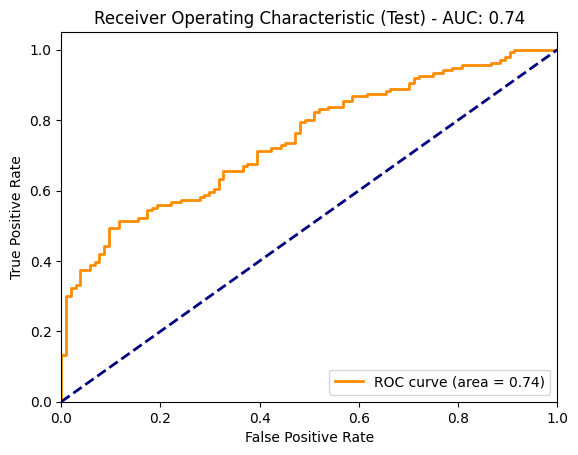

Confusion Matrix (Test):
 [[ 55  49]
 [ 36 100]]
Classification Report (Test):
               precision    recall  f1-score   support

         0.0       0.60      0.53      0.56       104
         1.0       0.67      0.74      0.70       136

    accuracy                           0.65       240
   macro avg       0.64      0.63      0.63       240
weighted avg       0.64      0.65      0.64       240



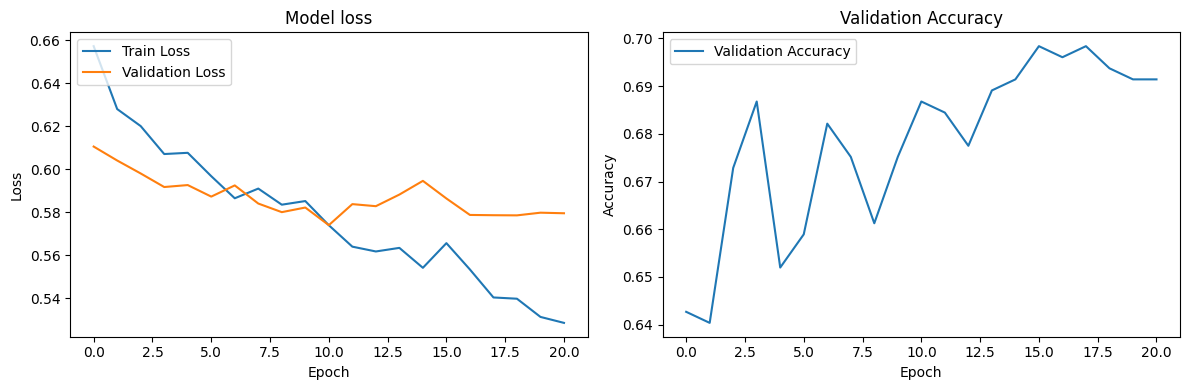

In [ ]:
import torch
import wandb
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Function to create the MLP model
def create_model(input_dim, layers, dropout_rate):
    class DynamicMLP(nn.Module):
        def __init__(self, input_dim, layers, dropout_rate):
            super(DynamicMLP, self).__init__()
            self.layers = nn.ModuleList()
            prev_dim = input_dim
            for layer_size in layers:
                self.layers.append(nn.Linear(prev_dim, layer_size))
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(dropout_rate))
                prev_dim = layer_size
            self.layers.append(nn.Linear(prev_dim, 1))
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            for layer in self.layers:
                x = layer(x)
            x = self.sigmoid(x)
            return x

    return DynamicMLP(input_dim, layers, dropout_rate)

# Define the hyperparameters grid
param_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [50, 100],
    'layers': [(256, 128, 64), (512, 256, 128)],
    'dropout_rate': [0.2, 0.4]
}

# Function to train and evaluate the model with given parameters
def train_evaluate(params):
    input_dim = X_train.shape[1]
    model = create_model(input_dim, params['layers'], params['dropout_rate'])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=params['epochs'] // 10, verbose=True)

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    best_val_loss = float('inf')
    early_stopping_patience = params['epochs'] // 5
    early_stopping_counter = 0
    num_epochs = params['epochs']

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_val_loss += loss.item() * X_batch.size(0)

                preds = (outputs > 0.5).float()
                correct_predictions += (preds == y_batch).sum().item()
                total_predictions += y_batch.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct_predictions / total_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

        scheduler.step(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping")
                break

    model.load_state_dict(torch.load('best_model.pth'))

    return model, train_losses, val_losses, val_accuracies

# Splitting dataset into training, validation, and test sets
X = principal_df.values
y = y_data.values

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Perform grid search
best_params = None
best_accuracy = 0

for lr in param_grid['learning_rate']:
    for bs in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            for layers in param_grid['layers']:
                for dropout_rate in param_grid['dropout_rate']:
                    params = {
                        'learning_rate': lr,
                        'batch_size': bs,
                        'epochs': epochs,
                        'layers': layers,
                        'dropout_rate': dropout_rate
                    }
                    model, train_losses, val_losses, val_accuracies = train_evaluate(params)
                    model.eval()
                    y_test_pred_prob = []
                    y_test_true = []
                    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)  # Ensure test_loader here as well
                    with torch.no_grad():
                        for X_batch, y_batch in test_loader:
                            outputs = model(X_batch)
                            y_test_pred_prob.append(outputs.numpy())
                            y_test_true.append(y_batch.numpy())
                    y_test_pred_prob = np.vstack(y_test_pred_prob).ravel()
                    y_test_true = np.vstack(y_test_true).ravel()
                    y_test_pred = (y_test_pred_prob > 0.5).astype(int)
                    test_accuracy = accuracy_score(y_test_true, y_test_pred)
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        best_params = params
                    print(f"Params: {params}, Test Accuracy: {test_accuracy}")

print(f"Best Params: {best_params}, Best Accuracy: {best_accuracy}")

# Load the best model
model, train_losses, val_losses, val_accuracies = train_evaluate(best_params)
model.eval()

# Evaluate the best model on the test set
y_test_pred_prob = []
y_test_true = []
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)  # Ensure test_loader here as well
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        y_test_pred_prob.append(outputs.numpy())
        y_test_true.append(y_batch.numpy())
y_test_pred_prob = np.vstack(y_test_pred_prob).ravel()
y_test_true = np.vstack(y_test_true).ravel()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

test_accuracy = accuracy_score(y_test_true, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test_true, y_test_pred)
print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test_true, y_test_pred))

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#**Ablation 1: Env_RMS**

Splitting dataset into training, validation, testing


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

n_components = 10  # Adjust based on your preference
pc_envrms = apply_pca(feature_dataset_list_env_rms.iloc[:,:], n_components=n_components)
principal_env_rms = pd.DataFrame(principal_components)
# Splitting dataset into training and test sets
X = principal_env_rms.values
y = y_data.values

# Split into training and test sets (90% training, 10% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print("Training-Val set size:", X_train_val.shape, y_train_val.shape)
print("Test set size:", X_test.shape, y_test.shape)

# Standardize the data
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

Training-Val set size: (2153, 10) (2153,)
Test set size: (240, 10) (240,)


### Logistic Regression

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Hyperparameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Test Accuracy: 0.6625


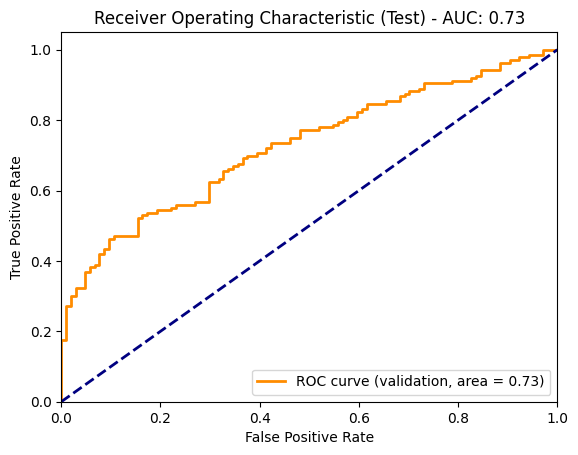

Confusion Matrix (Test):
 [[63 41]
 [40 96]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.61      0.61      0.61       104
           1       0.70      0.71      0.70       136

    accuracy                           0.66       240
   macro avg       0.66      0.66      0.66       240
weighted avg       0.66      0.66      0.66       240



In [ ]:
# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Different solvers
    'penalty': ['l1', 'l2'],  # Different regularization penalties
    'max_iter': [100, 500, 1000]  # Maximum number of iterations
}

# Initialize logistic regression model
logistic_model = LogisticRegression(random_state=42)

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_val, y_train_val)

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Train the model with the best hyperparameters on the entire training+validation set
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
y_test_prob = best_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (validation, area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))

### SVM

Best Hyperparameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Test Accuracy: 0.6791666666666667


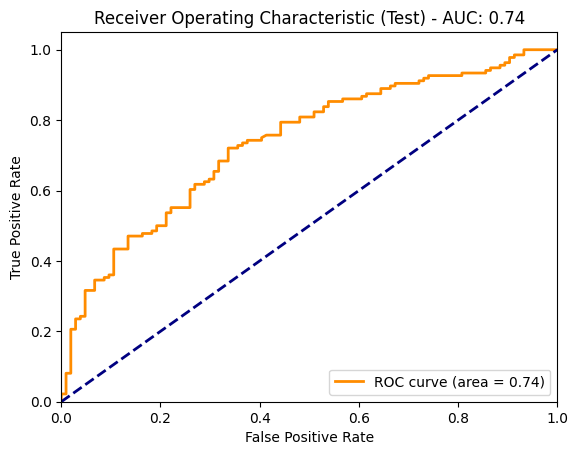

Confusion Matrix (Test):
 [[ 62  42]
 [ 35 101]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.64      0.60      0.62       104
           1       0.71      0.74      0.72       136

    accuracy                           0.68       240
   macro avg       0.67      0.67      0.67       240
weighted avg       0.68      0.68      0.68       240



In [ ]:
from sklearn.svm import SVC
# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],  # Linear and RBF kernels
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf'
}

# Initialize SVM model
svm_model = SVC(probability=True, random_state=42)

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_val, y_train_val)

print("Best Hyperparameters:", grid_search.best_params_)

# Train the model with the best hyperparameters on the entire training+validation set
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
y_test_prob = best_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))

### Random Forest

Best Hyperparameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Test Accuracy: 0.7166666666666667


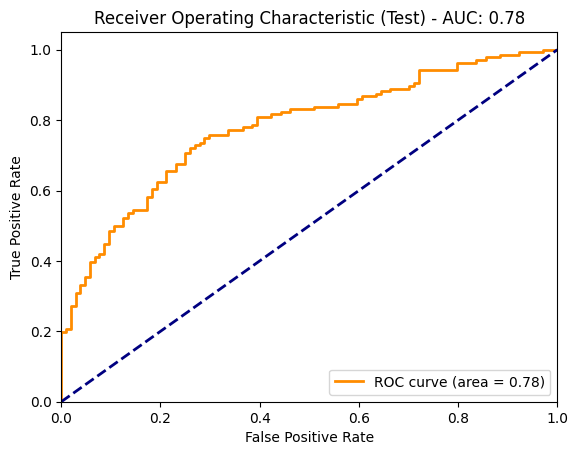

Confusion Matrix (Test):
 [[ 69  35]
 [ 33 103]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.68      0.66      0.67       104
           1       0.75      0.76      0.75       136

    accuracy                           0.72       240
   macro avg       0.71      0.71      0.71       240
weighted avg       0.72      0.72      0.72       240



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_val, y_train_val)

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Train the model with the best hyperparameters on the entire training+validation set
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
y_test_prob = best_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))


### XGBoost

Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.6}
Test Accuracy: 0.725


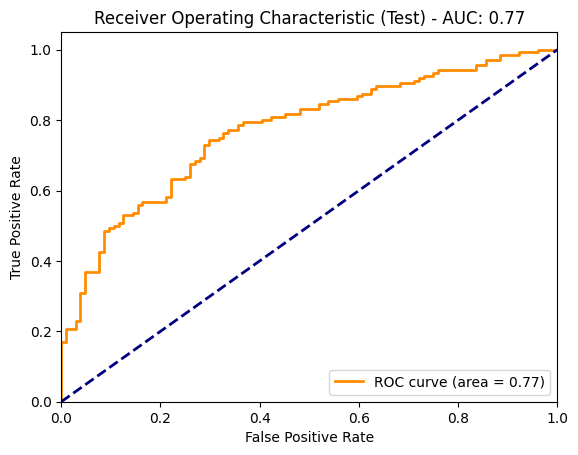

Confusion Matrix (Test):
 [[ 66  38]
 [ 28 108]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.70      0.63      0.67       104
           1       0.74      0.79      0.77       136

    accuracy                           0.73       240
   macro avg       0.72      0.71      0.72       240
weighted avg       0.72      0.72      0.72       240



In [ ]:
from xgboost import XGBClassifier

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'max_depth': [3, 6, 9],  # Maximum tree depth for base learners
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instance
    'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2]  # Minimum loss reduction required to make a further partition on a leaf node
}

# Initialize XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Set up GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_val, y_train_val)

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Train the model with the best hyperparameters on the entire training+validation set
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
y_test_prob = best_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))

### Deep Learning Classification

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6569, Val Loss: 0.6192, Val Accuracy: 0.6357
Epoch 2/50, Train Loss: 0.6210, Val Loss: 0.6045, Val Accuracy: 0.6682
Epoch 3/50, Train Loss: 0.6078, Val Loss: 0.6018, Val Accuracy: 0.6682
Epoch 4/50, Train Loss: 0.6007, Val Loss: 0.5936, Val Accuracy: 0.6636
Epoch 5/50, Train Loss: 0.5953, Val Loss: 0.5922, Val Accuracy: 0.6868
Epoch 6/50, Train Loss: 0.5916, Val Loss: 0.5824, Val Accuracy: 0.6937
Epoch 7/50, Train Loss: 0.5769, Val Loss: 0.5870, Val Accuracy: 0.6845
Epoch 8/50, Train Loss: 0.5824, Val Loss: 0.5821, Val Accuracy: 0.6914
Epoch 9/50, Train Loss: 0.5736, Val Loss: 0.5747, Val Accuracy: 0.7007
Epoch 10/50, Train Loss: 0.5639, Val Loss: 0.5922, Val Accuracy: 0.6682
Epoch 11/50, Train Loss: 0.5653, Val Loss: 0.5727, Val Accuracy: 0.6798
Epoch 12/50, Train Loss: 0.5519, Val Loss: 0.5869, Val Accuracy: 0.6821
Epoch 13/50, Train Loss: 0.5619, Val Loss: 0.5772, Val Accuracy: 0.6868
Epoch 14/50, Train Loss: 0.5369, Val Loss: 0.5815, Val Accuracy: 0.6891
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6653, Val Loss: 0.6259, Val Accuracy: 0.6473
Epoch 2/50, Train Loss: 0.6328, Val Loss: 0.6110, Val Accuracy: 0.6450
Epoch 3/50, Train Loss: 0.6200, Val Loss: 0.6105, Val Accuracy: 0.6497
Epoch 4/50, Train Loss: 0.6172, Val Loss: 0.6068, Val Accuracy: 0.6543
Epoch 5/50, Train Loss: 0.6113, Val Loss: 0.6016, Val Accuracy: 0.6705
Epoch 6/50, Train Loss: 0.6050, Val Loss: 0.5954, Val Accuracy: 0.6682
Epoch 7/50, Train Loss: 0.6121, Val Loss: 0.5938, Val Accuracy: 0.6752
Epoch 8/50, Train Loss: 0.5983, Val Loss: 0.5907, Val Accuracy: 0.6705
Epoch 9/50, Train Loss: 0.5969, Val Loss: 0.5903, Val Accuracy: 0.6682
Epoch 10/50, Train Loss: 0.5912, Val Loss: 0.5844, Val Accuracy: 0.6798
Epoch 11/50, Train Loss: 0.5899, Val Loss: 0.5816, Val Accuracy: 0.6845
Epoch 12/50, Train Loss: 0.5917, Val Loss: 0.5880, Val Accuracy: 0.6821
Epoch 13/50, Train Loss: 0.5824, Val Loss: 0.5846, Val Accuracy: 0.6891
Epoch 14/50, Train Loss: 0.5819, Val Loss: 0.5834, Val Accuracy: 0.6705
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6444, Val Loss: 0.6102, Val Accuracy: 0.6381
Epoch 2/50, Train Loss: 0.6200, Val Loss: 0.5976, Val Accuracy: 0.6705
Epoch 3/50, Train Loss: 0.6068, Val Loss: 0.5962, Val Accuracy: 0.6729
Epoch 4/50, Train Loss: 0.6014, Val Loss: 0.5948, Val Accuracy: 0.6705
Epoch 5/50, Train Loss: 0.5932, Val Loss: 0.5872, Val Accuracy: 0.6937
Epoch 6/50, Train Loss: 0.5787, Val Loss: 0.5848, Val Accuracy: 0.6868
Epoch 7/50, Train Loss: 0.5725, Val Loss: 0.5829, Val Accuracy: 0.6937
Epoch 8/50, Train Loss: 0.5666, Val Loss: 0.5861, Val Accuracy: 0.6775
Epoch 9/50, Train Loss: 0.5557, Val Loss: 0.5900, Val Accuracy: 0.6798
Epoch 10/50, Train Loss: 0.5544, Val Loss: 0.5863, Val Accuracy: 0.6914
Epoch 11/50, Train Loss: 0.5579, Val Loss: 0.5746, Val Accuracy: 0.6845
Epoch 12/50, Train Loss: 0.5411, Val Loss: 0.5822, Val Accuracy: 0.6891
Epoch 13/50, Train Loss: 0.5274, Val Loss: 0.5849, Val Accuracy: 0.6729
Epoch 14/50, Train Loss: 0.5255, Val Loss: 0.5982, Val Accuracy: 0.6729
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6497, Val Loss: 0.6130, Val Accuracy: 0.6381
Epoch 2/50, Train Loss: 0.6216, Val Loss: 0.5987, Val Accuracy: 0.6589
Epoch 3/50, Train Loss: 0.6137, Val Loss: 0.5977, Val Accuracy: 0.6589
Epoch 4/50, Train Loss: 0.6108, Val Loss: 0.5908, Val Accuracy: 0.6775
Epoch 5/50, Train Loss: 0.6035, Val Loss: 0.5858, Val Accuracy: 0.6775
Epoch 6/50, Train Loss: 0.5947, Val Loss: 0.5847, Val Accuracy: 0.6659
Epoch 7/50, Train Loss: 0.5891, Val Loss: 0.5979, Val Accuracy: 0.6589
Epoch 8/50, Train Loss: 0.5878, Val Loss: 0.5883, Val Accuracy: 0.6914
Epoch 9/50, Train Loss: 0.5841, Val Loss: 0.5955, Val Accuracy: 0.6659
Epoch 10/50, Train Loss: 0.5811, Val Loss: 0.5830, Val Accuracy: 0.6984
Epoch 11/50, Train Loss: 0.5768, Val Loss: 0.5816, Val Accuracy: 0.6705
Epoch 12/50, Train Loss: 0.5750, Val Loss: 0.5767, Val Accuracy: 0.6961
Epoch 13/50, Train Loss: 0.5628, Val Loss: 0.5832, Val Accuracy: 0.6891
Epoch 14/50, Train Loss: 0.5700, Val Loss: 0.5908, Val Accuracy: 0.6798
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6599, Val Loss: 0.6219, Val Accuracy: 0.6311
Epoch 2/100, Train Loss: 0.6259, Val Loss: 0.6091, Val Accuracy: 0.6497
Epoch 3/100, Train Loss: 0.6132, Val Loss: 0.6014, Val Accuracy: 0.6497
Epoch 4/100, Train Loss: 0.6062, Val Loss: 0.5999, Val Accuracy: 0.6566
Epoch 5/100, Train Loss: 0.5953, Val Loss: 0.5968, Val Accuracy: 0.6589
Epoch 6/100, Train Loss: 0.5908, Val Loss: 0.5877, Val Accuracy: 0.6845
Epoch 7/100, Train Loss: 0.5887, Val Loss: 0.5890, Val Accuracy: 0.6752
Epoch 8/100, Train Loss: 0.5803, Val Loss: 0.5870, Val Accuracy: 0.6705
Epoch 9/100, Train Loss: 0.5742, Val Loss: 0.5853, Val Accuracy: 0.6798
Epoch 10/100, Train Loss: 0.5681, Val Loss: 0.5834, Val Accuracy: 0.6798
Epoch 11/100, Train Loss: 0.5692, Val Loss: 0.5821, Val Accuracy: 0.6543
Epoch 12/100, Train Loss: 0.5608, Val Loss: 0.5816, Val Accuracy: 0.6729
Epoch 13/100, Train Loss: 0.5491, Val Loss: 0.5887, Val Accuracy: 0.6798
Epoch 14/100, Train Loss: 0.5443, Val Loss: 0.5854, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/100, Train Loss: 0.6309, Val Loss: 0.6084, Val Accuracy: 0.6311
Epoch 3/100, Train Loss: 0.6216, Val Loss: 0.6035, Val Accuracy: 0.6404
Epoch 4/100, Train Loss: 0.6207, Val Loss: 0.6054, Val Accuracy: 0.6520
Epoch 5/100, Train Loss: 0.6115, Val Loss: 0.6012, Val Accuracy: 0.6636
Epoch 6/100, Train Loss: 0.6050, Val Loss: 0.5979, Val Accuracy: 0.6613
Epoch 7/100, Train Loss: 0.6054, Val Loss: 0.5954, Val Accuracy: 0.6566
Epoch 8/100, Train Loss: 0.6024, Val Loss: 0.5933, Val Accuracy: 0.6543
Epoch 9/100, Train Loss: 0.6059, Val Loss: 0.5946, Val Accuracy: 0.6682
Epoch 10/100, Train Loss: 0.5988, Val Loss: 0.5937, Val Accuracy: 0.6705
Epoch 11/100, Train Loss: 0.5939, Val Loss: 0.5938, Val Accuracy: 0.6659
Epoch 12/100, Train Loss: 0.5858, Val Loss: 0.5901, Val Accuracy: 0.6659
Epoch 13/100, Train Loss: 0.5921, Val Loss: 0.5929, Val Accuracy: 0.6705
Epoch 14/100, Train Loss: 0.5794, Val Loss: 0.5922, Val Accuracy: 0.6705
Epoch 15/100, Train Loss: 0.5794, Val Loss: 0.5965, Val Acc

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6444, Val Loss: 0.6170, Val Accuracy: 0.6288
Epoch 2/100, Train Loss: 0.6120, Val Loss: 0.5979, Val Accuracy: 0.6729
Epoch 3/100, Train Loss: 0.5989, Val Loss: 0.5952, Val Accuracy: 0.6729
Epoch 4/100, Train Loss: 0.5905, Val Loss: 0.5915, Val Accuracy: 0.6729
Epoch 5/100, Train Loss: 0.5942, Val Loss: 0.5840, Val Accuracy: 0.6775
Epoch 6/100, Train Loss: 0.5767, Val Loss: 0.5933, Val Accuracy: 0.6868
Epoch 7/100, Train Loss: 0.5726, Val Loss: 0.5883, Val Accuracy: 0.6868
Epoch 8/100, Train Loss: 0.5612, Val Loss: 0.5845, Val Accuracy: 0.6961
Epoch 9/100, Train Loss: 0.5573, Val Loss: 0.5908, Val Accuracy: 0.6961
Epoch 10/100, Train Loss: 0.5514, Val Loss: 0.5768, Val Accuracy: 0.7030
Epoch 11/100, Train Loss: 0.5421, Val Loss: 0.6025, Val Accuracy: 0.6798
Epoch 12/100, Train Loss: 0.5441, Val Loss: 0.6029, Val Accuracy: 0.6682
Epoch 13/100, Train Loss: 0.5303, Val Loss: 0.6035, Val Accuracy: 0.6914
Epoch 14/100, Train Loss: 0.5269, Val Loss: 0.5922, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6499, Val Loss: 0.6202, Val Accuracy: 0.6288
Epoch 2/100, Train Loss: 0.6222, Val Loss: 0.6093, Val Accuracy: 0.6705
Epoch 3/100, Train Loss: 0.6194, Val Loss: 0.6024, Val Accuracy: 0.6613
Epoch 4/100, Train Loss: 0.6088, Val Loss: 0.5957, Val Accuracy: 0.6589
Epoch 5/100, Train Loss: 0.6050, Val Loss: 0.5936, Val Accuracy: 0.6705
Epoch 6/100, Train Loss: 0.6003, Val Loss: 0.5989, Val Accuracy: 0.6636
Epoch 7/100, Train Loss: 0.5943, Val Loss: 0.5918, Val Accuracy: 0.6682
Epoch 8/100, Train Loss: 0.5990, Val Loss: 0.5871, Val Accuracy: 0.6613
Epoch 9/100, Train Loss: 0.5883, Val Loss: 0.5882, Val Accuracy: 0.6705
Epoch 10/100, Train Loss: 0.5800, Val Loss: 0.5830, Val Accuracy: 0.6798
Epoch 11/100, Train Loss: 0.5821, Val Loss: 0.5912, Val Accuracy: 0.6775
Epoch 12/100, Train Loss: 0.5718, Val Loss: 0.5800, Val Accuracy: 0.6845
Epoch 13/100, Train Loss: 0.5680, Val Loss: 0.5834, Val Accuracy: 0.7030
Epoch 14/100, Train Loss: 0.5703, Val Loss: 0.5955, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/50, Train Loss: 0.6270, Val Loss: 0.6220, Val Accuracy: 0.6357
Epoch 3/50, Train Loss: 0.6130, Val Loss: 0.6060, Val Accuracy: 0.6543
Epoch 4/50, Train Loss: 0.6064, Val Loss: 0.6000, Val Accuracy: 0.6729
Epoch 5/50, Train Loss: 0.6008, Val Loss: 0.5887, Val Accuracy: 0.6705
Epoch 6/50, Train Loss: 0.5961, Val Loss: 0.5910, Val Accuracy: 0.6589
Epoch 7/50, Train Loss: 0.5895, Val Loss: 0.5871, Val Accuracy: 0.6891
Epoch 8/50, Train Loss: 0.5834, Val Loss: 0.5816, Val Accuracy: 0.6729
Epoch 9/50, Train Loss: 0.5809, Val Loss: 0.5841, Val Accuracy: 0.6775
Epoch 10/50, Train Loss: 0.5711, Val Loss: 0.5820, Val Accuracy: 0.6775
Epoch 11/50, Train Loss: 0.5594, Val Loss: 0.5780, Val Accuracy: 0.6845
Epoch 12/50, Train Loss: 0.5609, Val Loss: 0.5831, Val Accuracy: 0.6798
Epoch 13/50, Train Loss: 0.5614, Val Loss: 0.5798, Val Accuracy: 0.6798
Epoch 14/50, Train Loss: 0.5503, Val Loss: 0.5810, Val Accuracy: 0.6752
Epoch 15/50, Train Loss: 0.5492, Val Loss: 0.5805, Val Accuracy: 0.6798


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6716, Val Loss: 0.6341, Val Accuracy: 0.6404
Epoch 2/50, Train Loss: 0.6407, Val Loss: 0.6151, Val Accuracy: 0.6450
Epoch 3/50, Train Loss: 0.6281, Val Loss: 0.6076, Val Accuracy: 0.6543
Epoch 4/50, Train Loss: 0.6256, Val Loss: 0.6048, Val Accuracy: 0.6566
Epoch 5/50, Train Loss: 0.6155, Val Loss: 0.6069, Val Accuracy: 0.6427
Epoch 6/50, Train Loss: 0.6078, Val Loss: 0.5993, Val Accuracy: 0.6566
Epoch 7/50, Train Loss: 0.6088, Val Loss: 0.5988, Val Accuracy: 0.6682
Epoch 8/50, Train Loss: 0.6017, Val Loss: 0.5932, Val Accuracy: 0.6543
Epoch 9/50, Train Loss: 0.6048, Val Loss: 0.5934, Val Accuracy: 0.6613
Epoch 10/50, Train Loss: 0.6059, Val Loss: 0.5973, Val Accuracy: 0.6752
Epoch 11/50, Train Loss: 0.6000, Val Loss: 0.5881, Val Accuracy: 0.6659
Epoch 12/50, Train Loss: 0.5990, Val Loss: 0.5918, Val Accuracy: 0.6729
Epoch 13/50, Train Loss: 0.5948, Val Loss: 0.5939, Val Accuracy: 0.6798
Epoch 14/50, Train Loss: 0.5850, Val Loss: 0.5843, Val Accuracy: 0.6752
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6456, Val Loss: 0.6250, Val Accuracy: 0.6265
Epoch 2/50, Train Loss: 0.6212, Val Loss: 0.6092, Val Accuracy: 0.6404
Epoch 3/50, Train Loss: 0.6038, Val Loss: 0.5982, Val Accuracy: 0.6566
Epoch 4/50, Train Loss: 0.5935, Val Loss: 0.5962, Val Accuracy: 0.6589
Epoch 5/50, Train Loss: 0.5876, Val Loss: 0.5867, Val Accuracy: 0.6845
Epoch 6/50, Train Loss: 0.5758, Val Loss: 0.5972, Val Accuracy: 0.6682
Epoch 7/50, Train Loss: 0.5731, Val Loss: 0.5846, Val Accuracy: 0.6984
Epoch 8/50, Train Loss: 0.5675, Val Loss: 0.5967, Val Accuracy: 0.6821
Epoch 9/50, Train Loss: 0.5586, Val Loss: 0.5750, Val Accuracy: 0.6914
Epoch 10/50, Train Loss: 0.5464, Val Loss: 0.6002, Val Accuracy: 0.6821
Epoch 11/50, Train Loss: 0.5476, Val Loss: 0.5916, Val Accuracy: 0.6937
Epoch 12/50, Train Loss: 0.5361, Val Loss: 0.5888, Val Accuracy: 0.6845
Epoch 13/50, Train Loss: 0.5248, Val Loss: 0.5956, Val Accuracy: 0.6845
Epoch 14/50, Train Loss: 0.5197, Val Loss: 0.6245, Val Accuracy: 0.6752
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/50, Train Loss: 0.6316, Val Loss: 0.6088, Val Accuracy: 0.6543
Epoch 3/50, Train Loss: 0.6214, Val Loss: 0.6061, Val Accuracy: 0.6497
Epoch 4/50, Train Loss: 0.6063, Val Loss: 0.5944, Val Accuracy: 0.6705
Epoch 5/50, Train Loss: 0.6059, Val Loss: 0.5897, Val Accuracy: 0.6752
Epoch 6/50, Train Loss: 0.5993, Val Loss: 0.5956, Val Accuracy: 0.6659
Epoch 7/50, Train Loss: 0.5982, Val Loss: 0.5856, Val Accuracy: 0.6868
Epoch 8/50, Train Loss: 0.5810, Val Loss: 0.5874, Val Accuracy: 0.6729
Epoch 9/50, Train Loss: 0.5918, Val Loss: 0.5896, Val Accuracy: 0.6798
Epoch 10/50, Train Loss: 0.5869, Val Loss: 0.5856, Val Accuracy: 0.6798
Epoch 11/50, Train Loss: 0.5819, Val Loss: 0.5815, Val Accuracy: 0.6821
Epoch 12/50, Train Loss: 0.5816, Val Loss: 0.5878, Val Accuracy: 0.6798
Epoch 13/50, Train Loss: 0.5763, Val Loss: 0.5798, Val Accuracy: 0.6821
Epoch 14/50, Train Loss: 0.5652, Val Loss: 0.5944, Val Accuracy: 0.6798
Epoch 15/50, Train Loss: 0.5700, Val Loss: 0.5768, Val Accuracy: 0.6961


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/100, Train Loss: 0.6237, Val Loss: 0.6169, Val Accuracy: 0.6357
Epoch 3/100, Train Loss: 0.6089, Val Loss: 0.6052, Val Accuracy: 0.6589
Epoch 4/100, Train Loss: 0.5999, Val Loss: 0.5971, Val Accuracy: 0.6613
Epoch 5/100, Train Loss: 0.6061, Val Loss: 0.5982, Val Accuracy: 0.6636
Epoch 6/100, Train Loss: 0.5991, Val Loss: 0.5946, Val Accuracy: 0.6775
Epoch 7/100, Train Loss: 0.5999, Val Loss: 0.5951, Val Accuracy: 0.6497
Epoch 8/100, Train Loss: 0.5867, Val Loss: 0.5868, Val Accuracy: 0.6752
Epoch 9/100, Train Loss: 0.5864, Val Loss: 0.5870, Val Accuracy: 0.6705
Epoch 10/100, Train Loss: 0.5768, Val Loss: 0.5847, Val Accuracy: 0.6752
Epoch 11/100, Train Loss: 0.5753, Val Loss: 0.5831, Val Accuracy: 0.6775
Epoch 12/100, Train Loss: 0.5699, Val Loss: 0.5781, Val Accuracy: 0.6984
Epoch 13/100, Train Loss: 0.5664, Val Loss: 0.5928, Val Accuracy: 0.6752
Epoch 14/100, Train Loss: 0.5612, Val Loss: 0.5846, Val Accuracy: 0.6868
Epoch 15/100, Train Loss: 0.5491, Val Loss: 0.5827, Val Acc

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6798, Val Loss: 0.6488, Val Accuracy: 0.6520
Epoch 2/100, Train Loss: 0.6355, Val Loss: 0.6161, Val Accuracy: 0.6288
Epoch 3/100, Train Loss: 0.6288, Val Loss: 0.6107, Val Accuracy: 0.6381
Epoch 4/100, Train Loss: 0.6180, Val Loss: 0.6068, Val Accuracy: 0.6566
Epoch 5/100, Train Loss: 0.6215, Val Loss: 0.6031, Val Accuracy: 0.6729
Epoch 6/100, Train Loss: 0.6183, Val Loss: 0.5977, Val Accuracy: 0.6613
Epoch 7/100, Train Loss: 0.6070, Val Loss: 0.5953, Val Accuracy: 0.6636
Epoch 8/100, Train Loss: 0.6057, Val Loss: 0.5981, Val Accuracy: 0.6705
Epoch 9/100, Train Loss: 0.6020, Val Loss: 0.5874, Val Accuracy: 0.6798
Epoch 10/100, Train Loss: 0.5961, Val Loss: 0.5867, Val Accuracy: 0.6868
Epoch 11/100, Train Loss: 0.5949, Val Loss: 0.5834, Val Accuracy: 0.6659
Epoch 12/100, Train Loss: 0.5987, Val Loss: 0.5819, Val Accuracy: 0.6729
Epoch 13/100, Train Loss: 0.5867, Val Loss: 0.5822, Val Accuracy: 0.6845
Epoch 14/100, Train Loss: 0.5969, Val Loss: 0.5913, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6540, Val Loss: 0.6155, Val Accuracy: 0.6334
Epoch 2/100, Train Loss: 0.6209, Val Loss: 0.6094, Val Accuracy: 0.6520
Epoch 3/100, Train Loss: 0.6057, Val Loss: 0.6016, Val Accuracy: 0.6589
Epoch 4/100, Train Loss: 0.5937, Val Loss: 0.5889, Val Accuracy: 0.6729
Epoch 5/100, Train Loss: 0.5871, Val Loss: 0.5891, Val Accuracy: 0.6729
Epoch 6/100, Train Loss: 0.5840, Val Loss: 0.5899, Val Accuracy: 0.6868
Epoch 7/100, Train Loss: 0.5748, Val Loss: 0.5838, Val Accuracy: 0.6821
Epoch 8/100, Train Loss: 0.5635, Val Loss: 0.5836, Val Accuracy: 0.6845
Epoch 9/100, Train Loss: 0.5639, Val Loss: 0.5813, Val Accuracy: 0.6984
Epoch 10/100, Train Loss: 0.5520, Val Loss: 0.5901, Val Accuracy: 0.6891
Epoch 11/100, Train Loss: 0.5437, Val Loss: 0.5749, Val Accuracy: 0.6821
Epoch 12/100, Train Loss: 0.5330, Val Loss: 0.5919, Val Accuracy: 0.6868
Epoch 13/100, Train Loss: 0.5401, Val Loss: 0.5911, Val Accuracy: 0.6868
Epoch 14/100, Train Loss: 0.5263, Val Loss: 0.5823, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6599, Val Loss: 0.6261, Val Accuracy: 0.6288
Epoch 2/100, Train Loss: 0.6221, Val Loss: 0.6098, Val Accuracy: 0.6450
Epoch 3/100, Train Loss: 0.6220, Val Loss: 0.6122, Val Accuracy: 0.6497
Epoch 4/100, Train Loss: 0.6080, Val Loss: 0.6039, Val Accuracy: 0.6613
Epoch 5/100, Train Loss: 0.6086, Val Loss: 0.5976, Val Accuracy: 0.6636
Epoch 6/100, Train Loss: 0.6001, Val Loss: 0.5973, Val Accuracy: 0.6682
Epoch 7/100, Train Loss: 0.5962, Val Loss: 0.5977, Val Accuracy: 0.6752
Epoch 8/100, Train Loss: 0.5829, Val Loss: 0.5927, Val Accuracy: 0.6705
Epoch 9/100, Train Loss: 0.5841, Val Loss: 0.5896, Val Accuracy: 0.6636
Epoch 10/100, Train Loss: 0.5804, Val Loss: 0.5897, Val Accuracy: 0.6798
Epoch 11/100, Train Loss: 0.5815, Val Loss: 0.5913, Val Accuracy: 0.6752
Epoch 12/100, Train Loss: 0.5790, Val Loss: 0.5904, Val Accuracy: 0.6775
Epoch 13/100, Train Loss: 0.5700, Val Loss: 0.5904, Val Accuracy: 0.6868
Epoch 14/100, Train Loss: 0.5593, Val Loss: 0.5844, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6511, Val Loss: 0.6215, Val Accuracy: 0.6543
Epoch 2/50, Train Loss: 0.6275, Val Loss: 0.6232, Val Accuracy: 0.6589
Epoch 3/50, Train Loss: 0.6268, Val Loss: 0.6103, Val Accuracy: 0.6682
Epoch 4/50, Train Loss: 0.6084, Val Loss: 0.5868, Val Accuracy: 0.6821
Epoch 5/50, Train Loss: 0.5992, Val Loss: 0.5903, Val Accuracy: 0.6729
Epoch 6/50, Train Loss: 0.5947, Val Loss: 0.6081, Val Accuracy: 0.6682
Epoch 7/50, Train Loss: 0.6038, Val Loss: 0.5982, Val Accuracy: 0.6775
Epoch 8/50, Train Loss: 0.5935, Val Loss: 0.6110, Val Accuracy: 0.6613
Epoch 9/50, Train Loss: 0.5932, Val Loss: 0.5948, Val Accuracy: 0.6636
Epoch 10/50, Train Loss: 0.5880, Val Loss: 0.5937, Val Accuracy: 0.6729
Epoch 11/50, Train Loss: 0.5597, Val Loss: 0.5856, Val Accuracy: 0.6845
Epoch 12/50, Train Loss: 0.5444, Val Loss: 0.5894, Val Accuracy: 0.6821
Epoch 13/50, Train Loss: 0.5353, Val Loss: 0.5908, Val Accuracy: 0.6821
Epoch 14/50, Train Loss: 0.5359, Val Loss: 0.5882, Val Accuracy: 0.6868
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6677, Val Loss: 0.6129, Val Accuracy: 0.6450
Epoch 2/50, Train Loss: 0.6418, Val Loss: 0.6230, Val Accuracy: 0.6705
Epoch 3/50, Train Loss: 0.6323, Val Loss: 0.6103, Val Accuracy: 0.6497
Epoch 4/50, Train Loss: 0.6279, Val Loss: 0.6301, Val Accuracy: 0.6589
Epoch 5/50, Train Loss: 0.6278, Val Loss: 0.6029, Val Accuracy: 0.6682
Epoch 6/50, Train Loss: 0.6164, Val Loss: 0.6065, Val Accuracy: 0.6705
Epoch 7/50, Train Loss: 0.6240, Val Loss: 0.6152, Val Accuracy: 0.6659
Epoch 8/50, Train Loss: 0.6246, Val Loss: 0.6226, Val Accuracy: 0.6914
Epoch 9/50, Train Loss: 0.6161, Val Loss: 0.6006, Val Accuracy: 0.6798
Epoch 10/50, Train Loss: 0.6186, Val Loss: 0.6053, Val Accuracy: 0.6682
Epoch 11/50, Train Loss: 0.6107, Val Loss: 0.6229, Val Accuracy: 0.6589
Epoch 12/50, Train Loss: 0.6185, Val Loss: 0.6202, Val Accuracy: 0.6752
Epoch 13/50, Train Loss: 0.6306, Val Loss: 0.6191, Val Accuracy: 0.6520
Epoch 14/50, Train Loss: 0.6017, Val Loss: 0.6068, Val Accuracy: 0.6775
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6615, Val Loss: 0.6030, Val Accuracy: 0.6566
Epoch 2/50, Train Loss: 0.6301, Val Loss: 0.6042, Val Accuracy: 0.6891
Epoch 3/50, Train Loss: 0.6203, Val Loss: 0.6024, Val Accuracy: 0.6729
Epoch 4/50, Train Loss: 0.6134, Val Loss: 0.6334, Val Accuracy: 0.6195
Epoch 5/50, Train Loss: 0.6059, Val Loss: 0.6024, Val Accuracy: 0.6798
Epoch 6/50, Train Loss: 0.6084, Val Loss: 0.6183, Val Accuracy: 0.6497
Epoch 7/50, Train Loss: 0.6108, Val Loss: 0.6322, Val Accuracy: 0.6450
Epoch 8/50, Train Loss: 0.6122, Val Loss: 0.5981, Val Accuracy: 0.6775
Epoch 9/50, Train Loss: 0.6051, Val Loss: 0.6090, Val Accuracy: 0.6566
Epoch 10/50, Train Loss: 0.6032, Val Loss: 0.6425, Val Accuracy: 0.6659
Epoch 11/50, Train Loss: 0.5970, Val Loss: 0.6423, Val Accuracy: 0.6705
Epoch 12/50, Train Loss: 0.5754, Val Loss: 0.5991, Val Accuracy: 0.6798
Epoch 13/50, Train Loss: 0.5834, Val Loss: 0.6166, Val Accuracy: 0.6241
Epoch 14/50, Train Loss: 0.5849, Val Loss: 0.6258, Val Accuracy: 0.6868
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6757, Val Loss: 0.6165, Val Accuracy: 0.6311
Epoch 2/50, Train Loss: 0.6412, Val Loss: 0.6119, Val Accuracy: 0.6288
Epoch 3/50, Train Loss: 0.6285, Val Loss: 0.6054, Val Accuracy: 0.6566
Epoch 4/50, Train Loss: 0.6340, Val Loss: 0.6180, Val Accuracy: 0.6497
Epoch 5/50, Train Loss: 0.6259, Val Loss: 0.6176, Val Accuracy: 0.6334
Epoch 6/50, Train Loss: 0.6451, Val Loss: 0.6071, Val Accuracy: 0.6473
Epoch 7/50, Train Loss: 0.6360, Val Loss: 0.6434, Val Accuracy: 0.6450
Epoch 8/50, Train Loss: 0.6318, Val Loss: 0.6191, Val Accuracy: 0.5684
Epoch 9/50, Train Loss: 0.6301, Val Loss: 0.6128, Val Accuracy: 0.6450
Epoch 10/50, Train Loss: 0.6125, Val Loss: 0.5986, Val Accuracy: 0.6497
Epoch 11/50, Train Loss: 0.6059, Val Loss: 0.5965, Val Accuracy: 0.6543
Epoch 12/50, Train Loss: 0.5854, Val Loss: 0.5877, Val Accuracy: 0.6682
Epoch 13/50, Train Loss: 0.5846, Val Loss: 0.5871, Val Accuracy: 0.6613
Epoch 14/50, Train Loss: 0.5888, Val Loss: 0.5862, Val Accuracy: 0.6659
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6569, Val Loss: 0.6092, Val Accuracy: 0.6473
Epoch 2/100, Train Loss: 0.6218, Val Loss: 0.6261, Val Accuracy: 0.6566
Epoch 3/100, Train Loss: 0.6129, Val Loss: 0.6035, Val Accuracy: 0.6775
Epoch 4/100, Train Loss: 0.6013, Val Loss: 0.6006, Val Accuracy: 0.6705
Epoch 5/100, Train Loss: 0.5976, Val Loss: 0.5936, Val Accuracy: 0.6589
Epoch 6/100, Train Loss: 0.6064, Val Loss: 0.5943, Val Accuracy: 0.6729
Epoch 7/100, Train Loss: 0.6086, Val Loss: 0.6040, Val Accuracy: 0.6729
Epoch 8/100, Train Loss: 0.5987, Val Loss: 0.6186, Val Accuracy: 0.6543
Epoch 9/100, Train Loss: 0.5874, Val Loss: 0.6092, Val Accuracy: 0.6659
Epoch 10/100, Train Loss: 0.6061, Val Loss: 0.5940, Val Accuracy: 0.6682
Epoch 11/100, Train Loss: 0.5723, Val Loss: 0.6150, Val Accuracy: 0.6821
Epoch 12/100, Train Loss: 0.5821, Val Loss: 0.5855, Val Accuracy: 0.6821
Epoch 13/100, Train Loss: 0.5721, Val Loss: 0.5956, Val Accuracy: 0.6845
Epoch 14/100, Train Loss: 0.5729, Val Loss: 0.6338, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/100, Train Loss: 0.6352, Val Loss: 0.6189, Val Accuracy: 0.6497
Epoch 3/100, Train Loss: 0.6232, Val Loss: 0.6153, Val Accuracy: 0.6589
Epoch 4/100, Train Loss: 0.6255, Val Loss: 0.5853, Val Accuracy: 0.6659
Epoch 5/100, Train Loss: 0.6344, Val Loss: 0.5980, Val Accuracy: 0.6752
Epoch 6/100, Train Loss: 0.6155, Val Loss: 0.6126, Val Accuracy: 0.6636
Epoch 7/100, Train Loss: 0.6261, Val Loss: 0.6137, Val Accuracy: 0.6636
Epoch 8/100, Train Loss: 0.6146, Val Loss: 0.6042, Val Accuracy: 0.6752
Epoch 9/100, Train Loss: 0.6169, Val Loss: 0.5920, Val Accuracy: 0.6752
Epoch 10/100, Train Loss: 0.6107, Val Loss: 0.6087, Val Accuracy: 0.6589
Epoch 11/100, Train Loss: 0.6244, Val Loss: 0.5956, Val Accuracy: 0.6775
Epoch 12/100, Train Loss: 0.6171, Val Loss: 0.5880, Val Accuracy: 0.6775
Epoch 13/100, Train Loss: 0.6100, Val Loss: 0.5854, Val Accuracy: 0.6705
Epoch 14/100, Train Loss: 0.6224, Val Loss: 0.6161, Val Accuracy: 0.6729
Epoch 15/100, Train Loss: 0.6066, Val Loss: 0.6133, Val Acc

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6574, Val Loss: 0.6150, Val Accuracy: 0.6450
Epoch 2/100, Train Loss: 0.6174, Val Loss: 0.6177, Val Accuracy: 0.6473
Epoch 3/100, Train Loss: 0.6152, Val Loss: 0.6012, Val Accuracy: 0.6984
Epoch 4/100, Train Loss: 0.6066, Val Loss: 0.6268, Val Accuracy: 0.6589
Epoch 5/100, Train Loss: 0.6159, Val Loss: 0.5858, Val Accuracy: 0.6659
Epoch 6/100, Train Loss: 0.5966, Val Loss: 0.6290, Val Accuracy: 0.6752
Epoch 7/100, Train Loss: 0.6141, Val Loss: 0.6003, Val Accuracy: 0.6682
Epoch 8/100, Train Loss: 0.6071, Val Loss: 0.6036, Val Accuracy: 0.6752
Epoch 9/100, Train Loss: 0.5888, Val Loss: 0.6429, Val Accuracy: 0.6705
Epoch 10/100, Train Loss: 0.6023, Val Loss: 0.5807, Val Accuracy: 0.6821
Epoch 11/100, Train Loss: 0.5988, Val Loss: 0.6489, Val Accuracy: 0.6659
Epoch 12/100, Train Loss: 0.5815, Val Loss: 0.5979, Val Accuracy: 0.6636
Epoch 13/100, Train Loss: 0.5883, Val Loss: 0.5949, Val Accuracy: 0.6845
Epoch 14/100, Train Loss: 0.5908, Val Loss: 0.6071, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6626, Val Loss: 0.6092, Val Accuracy: 0.6172
Epoch 2/100, Train Loss: 0.6442, Val Loss: 0.6081, Val Accuracy: 0.6473
Epoch 3/100, Train Loss: 0.6282, Val Loss: 0.6320, Val Accuracy: 0.6079
Epoch 4/100, Train Loss: 0.6476, Val Loss: 0.6096, Val Accuracy: 0.6543
Epoch 5/100, Train Loss: 0.6253, Val Loss: 0.5940, Val Accuracy: 0.6589
Epoch 6/100, Train Loss: 0.6344, Val Loss: 0.6269, Val Accuracy: 0.6636
Epoch 7/100, Train Loss: 0.6296, Val Loss: 0.6518, Val Accuracy: 0.6450
Epoch 8/100, Train Loss: 0.6418, Val Loss: 0.6300, Val Accuracy: 0.6357
Epoch 9/100, Train Loss: 0.7058, Val Loss: 0.6294, Val Accuracy: 0.6589
Epoch 10/100, Train Loss: 0.6495, Val Loss: 0.6504, Val Accuracy: 0.6636
Epoch 11/100, Train Loss: 0.6482, Val Loss: 0.6128, Val Accuracy: 0.6775
Epoch 12/100, Train Loss: 0.6483, Val Loss: 0.6544, Val Accuracy: 0.6311
Epoch 13/100, Train Loss: 0.6541, Val Loss: 0.6291, Val Accuracy: 0.6520
Epoch 14/100, Train Loss: 0.7150, Val Loss: 0.6215, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/50, Train Loss: 0.6118, Val Loss: 0.6163, Val Accuracy: 0.6659
Epoch 3/50, Train Loss: 0.6061, Val Loss: 0.5949, Val Accuracy: 0.6636
Epoch 4/50, Train Loss: 0.5965, Val Loss: 0.5915, Val Accuracy: 0.6705
Epoch 5/50, Train Loss: 0.6037, Val Loss: 0.5980, Val Accuracy: 0.6914
Epoch 6/50, Train Loss: 0.5890, Val Loss: 0.6138, Val Accuracy: 0.6613
Epoch 7/50, Train Loss: 0.5894, Val Loss: 0.6056, Val Accuracy: 0.6821
Epoch 8/50, Train Loss: 0.5939, Val Loss: 0.5996, Val Accuracy: 0.6775
Epoch 9/50, Train Loss: 0.5654, Val Loss: 0.5864, Val Accuracy: 0.6752
Epoch 10/50, Train Loss: 0.5616, Val Loss: 0.6241, Val Accuracy: 0.6752
Epoch 11/50, Train Loss: 0.5575, Val Loss: 0.5885, Val Accuracy: 0.6891
Epoch 12/50, Train Loss: 0.5450, Val Loss: 0.6101, Val Accuracy: 0.6914
Epoch 13/50, Train Loss: 0.5587, Val Loss: 0.6034, Val Accuracy: 0.6729
Epoch 14/50, Train Loss: 0.5489, Val Loss: 0.6031, Val Accuracy: 0.6752
Epoch 15/50, Train Loss: 0.5380, Val Loss: 0.6087, Val Accuracy: 0.6798


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6660, Val Loss: 0.6270, Val Accuracy: 0.6381
Epoch 2/50, Train Loss: 0.6300, Val Loss: 0.6068, Val Accuracy: 0.6520
Epoch 3/50, Train Loss: 0.6140, Val Loss: 0.6033, Val Accuracy: 0.6497
Epoch 4/50, Train Loss: 0.6153, Val Loss: 0.6079, Val Accuracy: 0.6427
Epoch 5/50, Train Loss: 0.6073, Val Loss: 0.5936, Val Accuracy: 0.6752
Epoch 6/50, Train Loss: 0.6071, Val Loss: 0.5989, Val Accuracy: 0.6636
Epoch 7/50, Train Loss: 0.5995, Val Loss: 0.6008, Val Accuracy: 0.6613
Epoch 8/50, Train Loss: 0.5984, Val Loss: 0.5872, Val Accuracy: 0.6821
Epoch 9/50, Train Loss: 0.5913, Val Loss: 0.5901, Val Accuracy: 0.6752
Epoch 10/50, Train Loss: 0.5994, Val Loss: 0.6073, Val Accuracy: 0.6914
Epoch 11/50, Train Loss: 0.5927, Val Loss: 0.6116, Val Accuracy: 0.6821
Epoch 12/50, Train Loss: 0.6025, Val Loss: 0.5768, Val Accuracy: 0.6798
Epoch 13/50, Train Loss: 0.5878, Val Loss: 0.6030, Val Accuracy: 0.7007
Epoch 14/50, Train Loss: 0.5863, Val Loss: 0.5945, Val Accuracy: 0.6729
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6657, Val Loss: 0.6222, Val Accuracy: 0.6659
Epoch 2/50, Train Loss: 0.6226, Val Loss: 0.6075, Val Accuracy: 0.6729
Epoch 3/50, Train Loss: 0.6005, Val Loss: 0.5992, Val Accuracy: 0.6682
Epoch 4/50, Train Loss: 0.6100, Val Loss: 0.6087, Val Accuracy: 0.6589
Epoch 5/50, Train Loss: 0.6028, Val Loss: 0.5872, Val Accuracy: 0.6775
Epoch 6/50, Train Loss: 0.5915, Val Loss: 0.5950, Val Accuracy: 0.6682
Epoch 7/50, Train Loss: 0.5825, Val Loss: 0.5949, Val Accuracy: 0.7053
Epoch 8/50, Train Loss: 0.5883, Val Loss: 0.5946, Val Accuracy: 0.6845
Epoch 9/50, Train Loss: 0.5812, Val Loss: 0.5772, Val Accuracy: 0.6798
Epoch 10/50, Train Loss: 0.5651, Val Loss: 0.5827, Val Accuracy: 0.6775
Epoch 11/50, Train Loss: 0.5627, Val Loss: 0.5717, Val Accuracy: 0.6961
Epoch 12/50, Train Loss: 0.5632, Val Loss: 0.5904, Val Accuracy: 0.6821
Epoch 13/50, Train Loss: 0.5608, Val Loss: 0.5985, Val Accuracy: 0.6775
Epoch 14/50, Train Loss: 0.5700, Val Loss: 0.5932, Val Accuracy: 0.6798
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6609, Val Loss: 0.6238, Val Accuracy: 0.6311
Epoch 2/50, Train Loss: 0.6203, Val Loss: 0.6063, Val Accuracy: 0.6497
Epoch 3/50, Train Loss: 0.6153, Val Loss: 0.6203, Val Accuracy: 0.6821
Epoch 4/50, Train Loss: 0.6225, Val Loss: 0.6008, Val Accuracy: 0.6636
Epoch 5/50, Train Loss: 0.6101, Val Loss: 0.5995, Val Accuracy: 0.6613
Epoch 6/50, Train Loss: 0.6007, Val Loss: 0.6085, Val Accuracy: 0.6659
Epoch 7/50, Train Loss: 0.6041, Val Loss: 0.5993, Val Accuracy: 0.6752
Epoch 8/50, Train Loss: 0.6119, Val Loss: 0.6012, Val Accuracy: 0.6798
Epoch 9/50, Train Loss: 0.5904, Val Loss: 0.6019, Val Accuracy: 0.7007
Epoch 10/50, Train Loss: 0.6071, Val Loss: 0.6055, Val Accuracy: 0.6914
Epoch 11/50, Train Loss: 0.6100, Val Loss: 0.5969, Val Accuracy: 0.6659
Epoch 12/50, Train Loss: 0.5936, Val Loss: 0.6088, Val Accuracy: 0.6729
Epoch 13/50, Train Loss: 0.5967, Val Loss: 0.6098, Val Accuracy: 0.6705
Epoch 14/50, Train Loss: 0.6097, Val Loss: 0.6061, Val Accuracy: 0.6821
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/100, Train Loss: 0.6213, Val Loss: 0.5982, Val Accuracy: 0.6636
Epoch 3/100, Train Loss: 0.6089, Val Loss: 0.6163, Val Accuracy: 0.6729
Epoch 4/100, Train Loss: 0.5991, Val Loss: 0.6007, Val Accuracy: 0.6613
Epoch 5/100, Train Loss: 0.5947, Val Loss: 0.5955, Val Accuracy: 0.6798
Epoch 6/100, Train Loss: 0.5974, Val Loss: 0.5913, Val Accuracy: 0.6705
Epoch 7/100, Train Loss: 0.5911, Val Loss: 0.5845, Val Accuracy: 0.6589
Epoch 8/100, Train Loss: 0.5713, Val Loss: 0.6119, Val Accuracy: 0.6636
Epoch 9/100, Train Loss: 0.5915, Val Loss: 0.6078, Val Accuracy: 0.6868
Epoch 10/100, Train Loss: 0.5700, Val Loss: 0.6017, Val Accuracy: 0.6705
Epoch 11/100, Train Loss: 0.5682, Val Loss: 0.5859, Val Accuracy: 0.6821
Epoch 12/100, Train Loss: 0.5596, Val Loss: 0.6138, Val Accuracy: 0.6775
Epoch 13/100, Train Loss: 0.5557, Val Loss: 0.6226, Val Accuracy: 0.6845
Epoch 14/100, Train Loss: 0.5411, Val Loss: 0.5936, Val Accuracy: 0.6613
Epoch 15/100, Train Loss: 0.5524, Val Loss: 0.6225, Val Acc

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6464, Val Loss: 0.6577, Val Accuracy: 0.6009
Epoch 2/100, Train Loss: 0.6376, Val Loss: 0.6026, Val Accuracy: 0.6566
Epoch 3/100, Train Loss: 0.6211, Val Loss: 0.6158, Val Accuracy: 0.6682
Epoch 4/100, Train Loss: 0.6224, Val Loss: 0.6001, Val Accuracy: 0.6427
Epoch 5/100, Train Loss: 0.6160, Val Loss: 0.5948, Val Accuracy: 0.6729
Epoch 6/100, Train Loss: 0.6156, Val Loss: 0.6044, Val Accuracy: 0.6636
Epoch 7/100, Train Loss: 0.5983, Val Loss: 0.5901, Val Accuracy: 0.6682
Epoch 8/100, Train Loss: 0.6059, Val Loss: 0.5995, Val Accuracy: 0.6497
Epoch 9/100, Train Loss: 0.6109, Val Loss: 0.6132, Val Accuracy: 0.6705
Epoch 10/100, Train Loss: 0.6133, Val Loss: 0.5880, Val Accuracy: 0.6705
Epoch 11/100, Train Loss: 0.5876, Val Loss: 0.5892, Val Accuracy: 0.6543
Epoch 12/100, Train Loss: 0.6026, Val Loss: 0.5943, Val Accuracy: 0.6914
Epoch 13/100, Train Loss: 0.6058, Val Loss: 0.5857, Val Accuracy: 0.6613
Epoch 14/100, Train Loss: 0.6023, Val Loss: 0.5940, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6833, Val Loss: 0.6160, Val Accuracy: 0.6497
Epoch 2/100, Train Loss: 0.6142, Val Loss: 0.5946, Val Accuracy: 0.6613
Epoch 3/100, Train Loss: 0.5986, Val Loss: 0.6082, Val Accuracy: 0.6450
Epoch 4/100, Train Loss: 0.5989, Val Loss: 0.5985, Val Accuracy: 0.6520
Epoch 5/100, Train Loss: 0.5869, Val Loss: 0.5764, Val Accuracy: 0.6775
Epoch 6/100, Train Loss: 0.5896, Val Loss: 0.5791, Val Accuracy: 0.6682
Epoch 7/100, Train Loss: 0.5816, Val Loss: 0.5891, Val Accuracy: 0.6729
Epoch 8/100, Train Loss: 0.5857, Val Loss: 0.5936, Val Accuracy: 0.6845
Epoch 9/100, Train Loss: 0.5779, Val Loss: 0.6067, Val Accuracy: 0.6729
Epoch 10/100, Train Loss: 0.5780, Val Loss: 0.5851, Val Accuracy: 0.6868
Epoch 11/100, Train Loss: 0.5651, Val Loss: 0.5906, Val Accuracy: 0.6705
Epoch 12/100, Train Loss: 0.5798, Val Loss: 0.5833, Val Accuracy: 0.6613
Epoch 13/100, Train Loss: 0.5656, Val Loss: 0.6184, Val Accuracy: 0.6682
Epoch 14/100, Train Loss: 0.5499, Val Loss: 0.6054, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6757, Val Loss: 0.6183, Val Accuracy: 0.6218
Epoch 2/100, Train Loss: 0.6292, Val Loss: 0.6252, Val Accuracy: 0.6450
Epoch 3/100, Train Loss: 0.6302, Val Loss: 0.6034, Val Accuracy: 0.6752
Epoch 4/100, Train Loss: 0.6212, Val Loss: 0.5984, Val Accuracy: 0.6682
Epoch 5/100, Train Loss: 0.6140, Val Loss: 0.6015, Val Accuracy: 0.6636
Epoch 6/100, Train Loss: 0.6192, Val Loss: 0.6136, Val Accuracy: 0.6543
Epoch 7/100, Train Loss: 0.6079, Val Loss: 0.5932, Val Accuracy: 0.6729
Epoch 8/100, Train Loss: 0.6070, Val Loss: 0.5932, Val Accuracy: 0.6729
Epoch 9/100, Train Loss: 0.6132, Val Loss: 0.5889, Val Accuracy: 0.6798
Epoch 10/100, Train Loss: 0.6062, Val Loss: 0.6018, Val Accuracy: 0.6636
Epoch 11/100, Train Loss: 0.5967, Val Loss: 0.6301, Val Accuracy: 0.6450
Epoch 12/100, Train Loss: 0.6117, Val Loss: 0.6116, Val Accuracy: 0.6613
Epoch 13/100, Train Loss: 0.6609, Val Loss: 0.5915, Val Accuracy: 0.6845
Epoch 14/100, Train Loss: 0.5971, Val Loss: 0.6551, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6647, Val Loss: 0.6271, Val Accuracy: 0.6265
Epoch 2/100, Train Loss: 0.6307, Val Loss: 0.6213, Val Accuracy: 0.6265
Epoch 3/100, Train Loss: 0.6207, Val Loss: 0.6235, Val Accuracy: 0.6311
Epoch 4/100, Train Loss: 0.6214, Val Loss: 0.6081, Val Accuracy: 0.6589
Epoch 5/100, Train Loss: 0.6121, Val Loss: 0.6065, Val Accuracy: 0.6520
Epoch 6/100, Train Loss: 0.6091, Val Loss: 0.6019, Val Accuracy: 0.6543
Epoch 7/100, Train Loss: 0.6038, Val Loss: 0.5942, Val Accuracy: 0.6729
Epoch 8/100, Train Loss: 0.6034, Val Loss: 0.5933, Val Accuracy: 0.6752
Epoch 9/100, Train Loss: 0.5909, Val Loss: 0.5932, Val Accuracy: 0.6798
Epoch 10/100, Train Loss: 0.5944, Val Loss: 0.5901, Val Accuracy: 0.6752
Epoch 11/100, Train Loss: 0.5892, Val Loss: 0.5890, Val Accuracy: 0.6775
Epoch 12/100, Train Loss: 0.5858, Val Loss: 0.5853, Val Accuracy: 0.6682
Epoch 13/100, Train Loss: 0.5848, Val Loss: 0.5875, Val Accuracy: 0.6659
Epoch 14/100, Train Loss: 0.5794, Val Loss: 0.5839, Val Accu

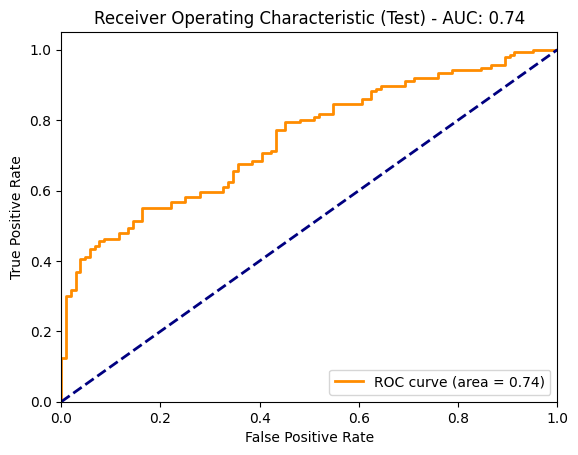

Confusion Matrix (Test):
 [[65 39]
 [44 92]]
Classification Report (Test):
               precision    recall  f1-score   support

         0.0       0.60      0.62      0.61       104
         1.0       0.70      0.68      0.69       136

    accuracy                           0.65       240
   macro avg       0.65      0.65      0.65       240
weighted avg       0.66      0.65      0.65       240



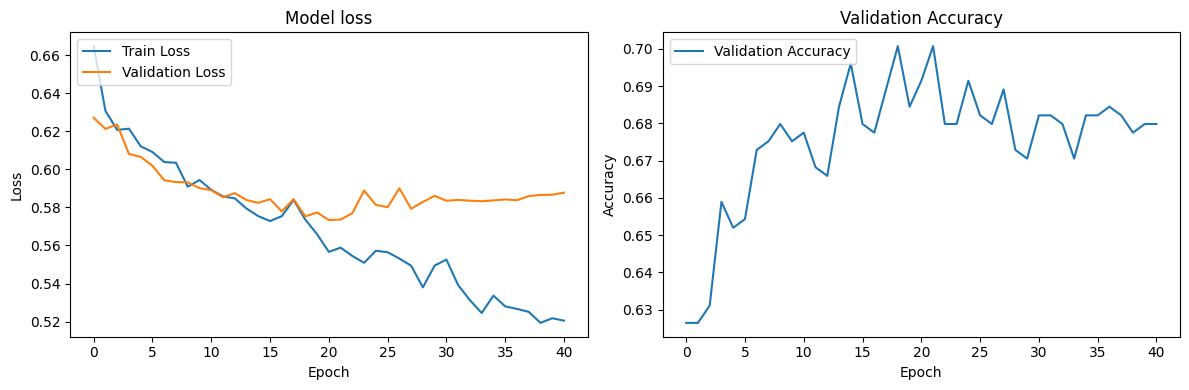

In [ ]:
import torch
import wandb
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Function to create the MLP model
def create_model(input_dim, layers, dropout_rate):
    class DynamicMLP(nn.Module):
        def __init__(self, input_dim, layers, dropout_rate):
            super(DynamicMLP, self).__init__()
            self.layers = nn.ModuleList()
            prev_dim = input_dim
            for layer_size in layers:
                self.layers.append(nn.Linear(prev_dim, layer_size))
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(dropout_rate))
                prev_dim = layer_size
            self.layers.append(nn.Linear(prev_dim, 1))
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            for layer in self.layers:
                x = layer(x)
            x = self.sigmoid(x)
            return x

    return DynamicMLP(input_dim, layers, dropout_rate)

# Define the hyperparameters grid
param_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [50, 100],
    'layers': [(256, 128, 64), (512, 256, 128)],
    'dropout_rate': [0.2, 0.4]
}

# Function to train and evaluate the model with given parameters
def train_evaluate(params):
    input_dim = X_train.shape[1]
    model = create_model(input_dim, params['layers'], params['dropout_rate'])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=params['epochs'] // 10, verbose=True)

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    best_val_loss = float('inf')
    early_stopping_patience = params['epochs'] // 5
    early_stopping_counter = 0
    num_epochs = params['epochs']

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_val_loss += loss.item() * X_batch.size(0)

                preds = (outputs > 0.5).float()
                correct_predictions += (preds == y_batch).sum().item()
                total_predictions += y_batch.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct_predictions / total_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

        scheduler.step(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping")
                break

    model.load_state_dict(torch.load('best_model.pth'))

    return model, train_losses, val_losses, val_accuracies

# Splitting dataset into training, validation, and test sets
X = principal_df.values
y = y_data.values

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Perform grid search
best_params = None
best_accuracy = 0

for lr in param_grid['learning_rate']:
    for bs in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            for layers in param_grid['layers']:
                for dropout_rate in param_grid['dropout_rate']:
                    params = {
                        'learning_rate': lr,
                        'batch_size': bs,
                        'epochs': epochs,
                        'layers': layers,
                        'dropout_rate': dropout_rate
                    }
                    model, train_losses, val_losses, val_accuracies = train_evaluate(params)
                    model.eval()
                    y_test_pred_prob = []
                    y_test_true = []
                    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)  # Ensure test_loader here as well
                    with torch.no_grad():
                        for X_batch, y_batch in test_loader:
                            outputs = model(X_batch)
                            y_test_pred_prob.append(outputs.numpy())
                            y_test_true.append(y_batch.numpy())
                    y_test_pred_prob = np.vstack(y_test_pred_prob).ravel()
                    y_test_true = np.vstack(y_test_true).ravel()
                    y_test_pred = (y_test_pred_prob > 0.5).astype(int)
                    test_accuracy = accuracy_score(y_test_true, y_test_pred)
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        best_params = params
                    print(f"Params: {params}, Test Accuracy: {test_accuracy}")

print(f"Best Params: {best_params}, Best Accuracy: {best_accuracy}")

# Load the best model
model, train_losses, val_losses, val_accuracies = train_evaluate(best_params)
model.eval()

# Evaluate the best model on the test set
y_test_pred_prob = []
y_test_true = []
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)  # Ensure test_loader here as well
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        y_test_pred_prob.append(outputs.numpy())
        y_test_true.append(y_batch.numpy())
y_test_pred_prob = np.vstack(y_test_pred_prob).ravel()
y_test_true = np.vstack(y_test_true).ravel()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

test_accuracy = accuracy_score(y_test_true, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test_true, y_test_pred)
print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test_true, y_test_pred))

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#**Ablation 2: CWT**

Splitting dataset into training, validation, testing


In [ ]:
X = feature_dataset_list_cwt.values
y = y_data

from sklearn.model_selection import train_test_split

# First, split into training+validation and test sets (80% training+validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then, split the training+validation set into separate training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (305, 200) (305,)
Validation set size: (102, 200) (102,)
Test set size: (102, 200) (102,)


#**Ablation 3: FFTStat**

Splitting dataset into training, validation, testing


In [ ]:
X = feature_dataset_list_FFTstat.values
y = y_data

from sklearn.model_selection import train_test_split

# First, split into training+validation and test sets (80% training+validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then, split the training+validation set into separate training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (305, 4) (305,)
Validation set size: (102, 4) (102,)
Test set size: (102, 4) (102,)


### Logistic Regression

Validation Accuracy: 0.5588235294117647


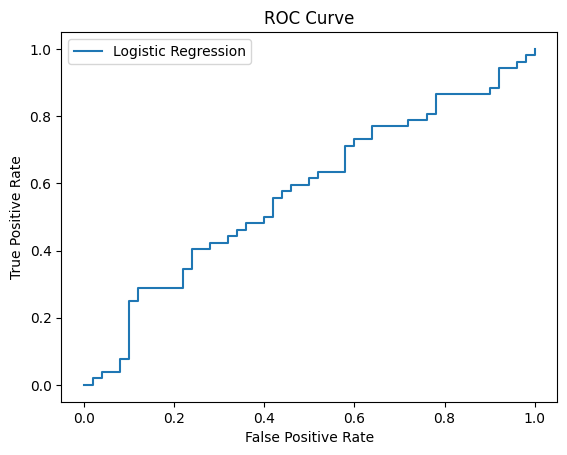

Confusion Matrix:
 [[21 29]
 [16 36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.42      0.48        50
           1       0.55      0.69      0.62        52

    accuracy                           0.56       102
   macro avg       0.56      0.56      0.55       102
weighted avg       0.56      0.56      0.55       102



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

# Initialize and train the logistic regression model
# logistic_model = LogisticRegression(C=1.0, solver='liblinear', max_iter=1000, random_state=42)
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = logistic_model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy}")

# Generate ROC curve
y_val_prob = logistic_model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_val, y_val_pred))

#**Ablation 4: Env_RMS_CWT**

Splitting dataset into training, validation, testing


In [ ]:
X = feature_dataset_list_env_rms_cwt.values
y = y_data

from sklearn.model_selection import train_test_split

# First, split into training+validation and test sets (80% training+validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then, split the training+validation set into separate training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (305, 200) (305,)
Validation set size: (102, 200) (102,)
Test set size: (102, 200) (102,)


### Logistic Regression

Validation Accuracy: 0.4803921568627451


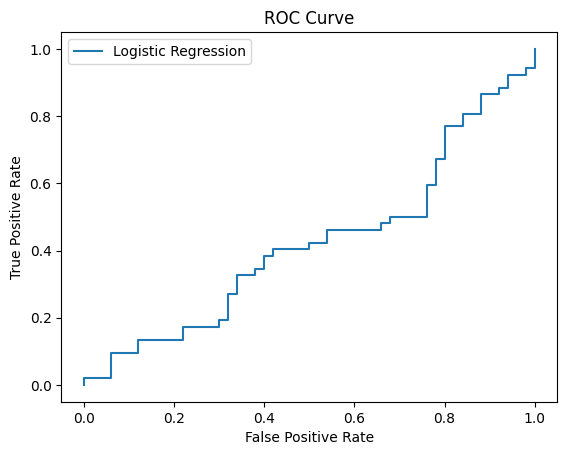

Confusion Matrix:
 [[ 8 42]
 [11 41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.16      0.23        50
           1       0.49      0.79      0.61        52

    accuracy                           0.48       102
   macro avg       0.46      0.47      0.42       102
weighted avg       0.46      0.48      0.42       102



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Initialize and train the logistic regression model
logistic_model = LogisticRegression(C=1, solver='liblinear', max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = logistic_model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy}")

# Generate ROC curve
y_val_prob = logistic_model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_val, y_val_pred))

#**Ablation 5: FFT entropy**

Splitting dataset into training, validation, testing


In [ ]:
X = feature_dataset_list_FFT_entropy.values
y = y_data

from sklearn.model_selection import train_test_split

# First, split into training+validation and test sets (80% training+validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then, split the training+validation set into separate training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (305, 5) (305,)
Validation set size: (102, 5) (102,)
Test set size: (102, 5) (102,)


## Linear Classification Model

Validation Accuracy: 0.5784313725490197


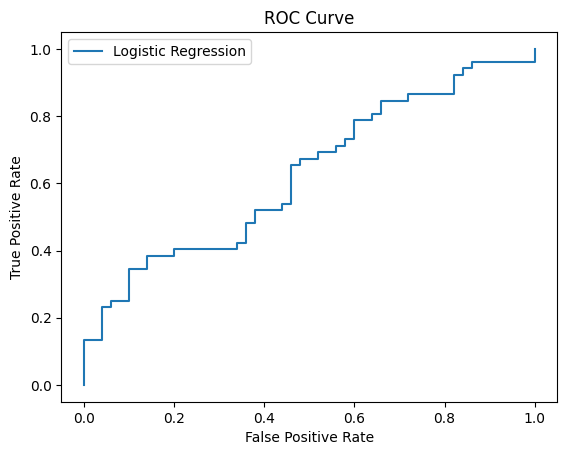

Confusion Matrix:
 [[24 26]
 [17 35]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.48      0.53        50
           1       0.57      0.67      0.62        52

    accuracy                           0.58       102
   macro avg       0.58      0.58      0.57       102
weighted avg       0.58      0.58      0.57       102



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Initialize and train the logistic regression model
logistic_model = LogisticRegression(C=1, solver='liblinear', max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = logistic_model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy}")

# Generate ROC curve
y_val_prob = logistic_model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_val, y_val_pred))